# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os

In [2]:

emulator_path=['/research/astro/fir/HELP/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']
field=['Lockman-SWIRE']

In [3]:
# Parameters
emulator_path = [
    "/research/astro/fir/HELP/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz"
]
field = ["Lockman-SWIRE"]


In [4]:
source = [np.int(os.environ['SGE_TASK_ID'])-1]

In [5]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')

In [6]:
priors,_=xidplus.load('XID+CIGALE_ESB_'+esb['field'][source[0]]+'_'+str(source[0])+'.pkl')

In [7]:
prior_list=Table.read('prior_list_'+esb['field'][source[0]]+'_'+str(source[0])+'.ascii',format='ascii')


In [8]:
z_mu=np.empty((priors[1].nsrc))
z_sig=np.empty((priors[1].nsrc))

for x,i in enumerate(priors[1].ID):
    ind=prior_list['help_id']==str(i)
    z_mu[x]=prior_list['redshift'][ind]
    z_sig[x]=prior_list['redshift_unc'][ind]

    

sfr_mu=1.5*z_mu+1.0
sfr_sig=np.full(priors[1].nsrc,0.5)

agn_frac_mu=np.full(priors[1].nsrc,-1)
agn_frac_sig=np.full(priors[1].nsrc,1)

In [9]:
params_mu=np.vstack((sfr_mu,z_mu)).T
params_sig=np.vstack((sfr_sig,z_sig)).T
params_names=['log10sfr','z']
hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}


In [10]:
phys_prior=xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

In [11]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [12]:

## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [13]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)

CPU times: user 7.72 s, sys: 113 ms, total: 7.83 s
Wall time: 7.81 s


## Fit Real data

In [14]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(os.cpu_count())
from operator import attrgetter
nuts_kernel = NUTS(SED_prior.spire_model_CIGALE,init_strategy=numpyro.infer.init_to_feasible())
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500,num_chains=4,chain_method='parallel')
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors,phys_prior,hier_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:51:51,  6.72s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<1:18:05,  4.71s/it, 91 steps of size 1.92e-03. acc. prob=0.33]

warmup:   1%|          | 7/1000 [00:08<1:01:44,  3.73s/it, 1023 steps of size 2.28e-04. acc. prob=0.31]

warmup:   1%|          | 8/1000 [00:09<50:06,  3.03s/it, 1023 steps of size 2.29e-04. acc. prob=0.38]  

warmup:   1%|          | 9/1000 [00:11<42:22,  2.57s/it, 1023 steps of size 3.92e-04. acc. prob=0.44]

warmup:   1%|          | 10/1000 [00:12<36:23,  2.21s/it, 1023 steps of size 7.09e-04. acc. prob=0.50]

warmup:   1%|          | 11/1000 [00:13<32:19,  1.96s/it, 1023 steps of size 4.27e-04. acc. prob=0.51]

warmup:   1%|          | 12/1000 [00:15<29:10,  1.77s/it, 1023 steps of size 7.56e-04. acc. prob=0.55]

warmup:   1%|▏         | 13/1000 [00:16<27:04,  1.65s/it, 1023 steps of size 7.20e-04. acc. prob=0.57]

warmup:   1%|▏         | 14/1000 [00:18<26:00,  1.58s/it, 1023 steps of size 1.40e-03. acc. prob=0.60]

warmup:   2%|▏         | 15/1000 [00:19<25:07,  1.53s/it, 1023 steps of size 2.46e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:20<24:14,  1.48s/it, 1023 steps of size 3.74e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:22<23:47,  1.45s/it, 1023 steps of size 6.57e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:23<23:10,  1.42s/it, 1023 steps of size 2.28e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:24<23:06,  1.41s/it, 1023 steps of size 3.93e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:26<23:24,  1.43s/it, 1023 steps of size 3.77e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:27<23:09,  1.42s/it, 1023 steps of size 7.05e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:29<23:04,  1.42s/it, 1023 steps of size 7.12e-03. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:30<22:52,  1.40s/it, 1023 steps of size 5.19e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:32<22:54,  1.41s/it, 1023 steps of size 3.86e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:33<22:47,  1.40s/it, 1023 steps of size 2.37e-03. acc. prob=0.68]

warmup:   3%|▎         | 26/1000 [00:34<22:54,  1.41s/it, 1023 steps of size 4.06e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:36<22:59,  1.42s/it, 1023 steps of size 4.36e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:37<22:52,  1.41s/it, 1023 steps of size 7.00e-03. acc. prob=0.71]

warmup:   3%|▎         | 29/1000 [00:39<22:42,  1.40s/it, 1023 steps of size 5.65e-03. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:40<22:44,  1.41s/it, 1023 steps of size 2.41e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:41<22:23,  1.39s/it, 1023 steps of size 3.93e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:43<22:36,  1.40s/it, 1023 steps of size 7.18e-03. acc. prob=0.72]

warmup:   3%|▎         | 33/1000 [00:44<22:40,  1.41s/it, 1023 steps of size 4.33e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:46<23:00,  1.43s/it, 1023 steps of size 7.34e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:47<23:05,  1.44s/it, 1023 steps of size 7.82e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:49<23:10,  1.44s/it, 1023 steps of size 1.35e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:50<23:14,  1.45s/it, 1023 steps of size 2.38e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:51<23:02,  1.44s/it, 1023 steps of size 2.46e-03. acc. prob=0.71]

warmup:   4%|▍         | 39/1000 [00:53<23:03,  1.44s/it, 1023 steps of size 3.65e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:54<23:07,  1.45s/it, 1023 steps of size 5.61e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:56<23:03,  1.44s/it, 1023 steps of size 4.82e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:57<23:16,  1.46s/it, 1023 steps of size 6.08e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:59<23:08,  1.45s/it, 1023 steps of size 2.59e-03. acc. prob=0.72]

warmup:   4%|▍         | 44/1000 [01:00<22:54,  1.44s/it, 1023 steps of size 3.23e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [01:02<23:02,  1.45s/it, 1023 steps of size 5.27e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [01:03<23:04,  1.45s/it, 1023 steps of size 3.24e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [01:04<22:59,  1.45s/it, 1023 steps of size 4.90e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [01:06<22:50,  1.44s/it, 1023 steps of size 7.05e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [01:07<22:47,  1.44s/it, 1023 steps of size 4.93e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [01:09<22:26,  1.42s/it, 1023 steps of size 3.26e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [01:10<22:26,  1.42s/it, 1023 steps of size 4.98e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [01:12<22:38,  1.43s/it, 1023 steps of size 3.49e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [01:13<22:32,  1.43s/it, 1023 steps of size 5.03e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:14<22:12,  1.41s/it, 1023 steps of size 3.66e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:16<22:06,  1.40s/it, 1023 steps of size 4.38e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [01:17<22:19,  1.42s/it, 1023 steps of size 6.71e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:19<22:29,  1.43s/it, 1023 steps of size 3.08e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [01:20<22:42,  1.45s/it, 1023 steps of size 4.72e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:22<22:32,  1.44s/it, 1023 steps of size 4.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [01:23<22:17,  1.42s/it, 1023 steps of size 5.92e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [01:24<22:22,  1.43s/it, 1023 steps of size 7.61e-03. acc. prob=0.75]

warmup:   6%|▌         | 62/1000 [01:26<22:21,  1.43s/it, 1023 steps of size 4.83e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:27<22:27,  1.44s/it, 1023 steps of size 7.41e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [01:29<22:32,  1.44s/it, 1023 steps of size 3.42e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:30<22:27,  1.44s/it, 1023 steps of size 4.99e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:32<22:11,  1.43s/it, 1023 steps of size 4.23e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [01:33<22:04,  1.42s/it, 1023 steps of size 1.89e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:34<22:03,  1.42s/it, 1023 steps of size 2.66e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:36<22:11,  1.43s/it, 1023 steps of size 4.08e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:37<22:22,  1.44s/it, 1023 steps of size 5.54e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:39<22:26,  1.45s/it, 1023 steps of size 8.52e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:40<19:06,  1.24s/it, 511 steps of size 6.65e-03. acc. prob=0.75] 

warmup:   7%|▋         | 73/1000 [01:41<20:12,  1.31s/it, 1023 steps of size 9.80e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:41<14:56,  1.03it/s, 117 steps of size 3.89e-03. acc. prob=0.75] 

warmup:   8%|▊         | 75/1000 [01:43<17:08,  1.11s/it, 1023 steps of size 4.84e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:44<18:36,  1.21s/it, 1023 steps of size 6.06e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:46<19:34,  1.27s/it, 1023 steps of size 7.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:46<17:07,  1.11s/it, 511 steps of size 7.76e-03. acc. prob=0.75] 

warmup:   8%|▊         | 79/1000 [01:47<15:12,  1.01it/s, 511 steps of size 1.16e-02. acc. prob=0.76]

warmup:   8%|▊         | 81/1000 [01:48<13:54,  1.10it/s, 1023 steps of size 2.68e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:50<16:23,  1.07s/it, 1023 steps of size 3.04e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:51<18:04,  1.18s/it, 1023 steps of size 4.59e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:53<19:14,  1.26s/it, 1023 steps of size 6.07e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:54<19:36,  1.29s/it, 1023 steps of size 5.55e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:55<20:02,  1.32s/it, 1023 steps of size 7.56e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:57<20:14,  1.33s/it, 1023 steps of size 3.22e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:58<20:43,  1.36s/it, 1023 steps of size 4.86e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [02:00<20:59,  1.38s/it, 1023 steps of size 3.22e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [02:01<21:11,  1.40s/it, 1023 steps of size 3.99e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [02:03<21:39,  1.43s/it, 1023 steps of size 5.19e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [02:04<21:45,  1.44s/it, 1023 steps of size 7.55e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [02:05<21:36,  1.43s/it, 1023 steps of size 2.80e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [02:07<21:36,  1.43s/it, 1023 steps of size 4.20e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [02:08<21:25,  1.42s/it, 1023 steps of size 3.64e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [02:10<21:39,  1.44s/it, 1023 steps of size 5.39e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:11<21:43,  1.44s/it, 1023 steps of size 8.00e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [02:12<18:24,  1.22s/it, 511 steps of size 9.12e-03. acc. prob=0.76] 

warmup:  10%|▉         | 99/1000 [02:13<15:44,  1.05s/it, 446 steps of size 5.15e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:14<17:29,  1.17s/it, 1023 steps of size 3.86e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:15<18:21,  1.22s/it, 1023 steps of size 5.44e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:16<14:40,  1.02it/s, 511 steps of size 1.53e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [02:17<11:55,  1.25it/s, 255 steps of size 1.33e-02. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [02:17<11:34,  1.29it/s, 511 steps of size 1.31e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:18<11:19,  1.31it/s, 511 steps of size 2.29e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:18<09:33,  1.56it/s, 255 steps of size 1.79e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [02:19<08:17,  1.79it/s, 255 steps of size 2.97e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [02:19<06:31,  2.28it/s, 123 steps of size 2.46e-03. acc. prob=0.75]

warmup:  11%|█         | 110/1000 [02:20<10:52,  1.36it/s, 1023 steps of size 4.13e-03. acc. prob=0.75]

warmup:  11%|█         | 111/1000 [02:22<14:05,  1.05it/s, 1023 steps of size 7.15e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:23<15:49,  1.07s/it, 1023 steps of size 1.19e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:24<14:18,  1.03it/s, 511 steps of size 1.64e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 114/1000 [02:24<11:41,  1.26it/s, 255 steps of size 1.60e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [02:25<09:46,  1.51it/s, 255 steps of size 2.83e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:26<10:00,  1.47it/s, 1023 steps of size 4.55e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [02:28<13:24,  1.10it/s, 1023 steps of size 8.45e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:28<12:27,  1.18it/s, 511 steps of size 1.41e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 120/1000 [02:29<11:53,  1.23it/s, 511 steps of size 2.49e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:29<09:52,  1.48it/s, 255 steps of size 2.99e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:29<07:35,  1.93it/s, 117 steps of size 8.35e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:30<08:17,  1.76it/s, 511 steps of size 1.44e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:30<07:19,  1.99it/s, 255 steps of size 2.26e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [02:31<06:39,  2.19it/s, 255 steps of size 1.33e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [02:32<07:51,  1.85it/s, 511 steps of size 1.97e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [02:32<07:09,  2.03it/s, 255 steps of size 2.56e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [02:32<06:33,  2.22it/s, 255 steps of size 1.43e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [02:33<07:43,  1.88it/s, 511 steps of size 1.82e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [02:33<07:00,  2.07it/s, 255 steps of size 1.86e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [02:34<06:27,  2.24it/s, 255 steps of size 3.12e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [02:35<07:40,  1.88it/s, 1023 steps of size 6.16e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [02:37<11:24,  1.26it/s, 1023 steps of size 1.03e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [02:37<10:49,  1.33it/s, 511 steps of size 1.68e-02. acc. prob=0.77] 

warmup:  14%|█▎        | 136/1000 [02:38<09:10,  1.57it/s, 255 steps of size 2.79e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [02:38<07:59,  1.80it/s, 255 steps of size 6.64e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [02:40<12:09,  1.18it/s, 1023 steps of size 9.88e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [02:40<11:29,  1.25it/s, 511 steps of size 1.29e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 140/1000 [02:41<11:00,  1.30it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [02:41<09:13,  1.55it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:42<07:56,  1.80it/s, 255 steps of size 2.27e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:42<06:53,  2.07it/s, 255 steps of size 1.10e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:43<07:55,  1.80it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:43<08:22,  1.70it/s, 511 steps of size 9.67e-03. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:44<08:49,  1.61it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [02:45<09:11,  1.55it/s, 511 steps of size 1.70e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:45<07:56,  1.79it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:45<07:07,  1.99it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:46<06:30,  2.18it/s, 255 steps of size 2.43e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:46<06:07,  2.31it/s, 255 steps of size 1.84e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:47<05:01,  2.81it/s, 255 steps of size 9.81e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:47<06:42,  2.10it/s, 511 steps of size 1.16e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:48<07:39,  1.84it/s, 511 steps of size 1.50e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [02:48<06:50,  2.05it/s, 255 steps of size 1.66e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [02:49<06:21,  2.21it/s, 255 steps of size 2.30e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [02:49<06:00,  2.33it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [02:50<07:14,  1.94it/s, 511 steps of size 2.42e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [02:50<06:35,  2.13it/s, 255 steps of size 3.75e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [02:52<07:42,  1.81it/s, 1023 steps of size 6.72e-03. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:53<11:11,  1.25it/s, 1023 steps of size 1.21e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:54<10:53,  1.28it/s, 511 steps of size 1.92e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 165/1000 [02:54<09:08,  1.52it/s, 255 steps of size 3.60e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:54<07:07,  1.95it/s, 127 steps of size 5.30e-03. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:56<10:51,  1.28it/s, 1023 steps of size 9.04e-03. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:56<10:29,  1.32it/s, 511 steps of size 1.29e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 169/1000 [02:57<10:11,  1.36it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:58<10:03,  1.38it/s, 511 steps of size 1.86e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:58<08:26,  1.64it/s, 255 steps of size 1.30e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:59<07:23,  1.87it/s, 255 steps of size 1.80e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:59<06:39,  2.07it/s, 255 steps of size 2.83e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:59<05:21,  2.57it/s, 127 steps of size 3.10e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:59<04:29,  3.07it/s, 127 steps of size 1.89e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [03:00<04:35,  2.99it/s, 255 steps of size 2.57e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [03:00<04:38,  2.96it/s, 255 steps of size 3.55e-03. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [03:01<09:18,  1.47it/s, 1023 steps of size 6.38e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [03:03<12:37,  1.08it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [03:04<11:57,  1.14it/s, 511 steps of size 1.46e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 181/1000 [03:04<09:52,  1.38it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [03:04<08:22,  1.63it/s, 255 steps of size 3.26e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:05<06:36,  2.06it/s, 127 steps of size 1.23e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [03:05<07:27,  1.82it/s, 511 steps of size 2.09e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:06<06:43,  2.02it/s, 255 steps of size 2.94e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:06<05:24,  2.51it/s, 127 steps of size 4.58e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:06<04:27,  3.03it/s, 127 steps of size 2.48e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:06<04:35,  2.95it/s, 255 steps of size 1.29e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:07<06:05,  2.22it/s, 511 steps of size 1.99e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [03:07<05:45,  2.34it/s, 255 steps of size 2.99e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:08<04:46,  2.83it/s, 127 steps of size 3.60e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:08<04:03,  3.31it/s, 127 steps of size 1.66e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [03:08<04:11,  3.21it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [03:08<03:41,  3.65it/s, 127 steps of size 3.68e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:09<03:20,  4.02it/s, 127 steps of size 6.94e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:09<05:11,  2.58it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [03:10<06:32,  2.05it/s, 511 steps of size 8.23e-03. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:11<07:18,  1.83it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:11<07:59,  1.67it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:12<07:02,  1.89it/s, 255 steps of size 9.08e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [03:12<07:49,  1.70it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:13<06:55,  1.92it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:13<06:09,  2.15it/s, 255 steps of size 2.61e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:14<05:51,  2.26it/s, 255 steps of size 1.44e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:14<05:28,  2.42it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:14<05:16,  2.50it/s, 255 steps of size 2.92e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:14<04:22,  3.02it/s, 127 steps of size 7.94e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:15<05:42,  2.31it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:16<06:50,  1.93it/s, 511 steps of size 1.70e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:16<06:11,  2.12it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [03:17<07:08,  1.84it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [03:18<07:39,  1.72it/s, 511 steps of size 1.22e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:18<08:15,  1.59it/s, 511 steps of size 1.80e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:19<07:12,  1.82it/s, 255 steps of size 1.95e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:19<06:26,  2.03it/s, 255 steps of size 2.89e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [03:19<05:12,  2.51it/s, 127 steps of size 2.40e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:20<05:00,  2.60it/s, 255 steps of size 2.60e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:20<04:54,  2.66it/s, 255 steps of size 1.07e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:21<06:12,  2.10it/s, 511 steps of size 1.64e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [03:21<05:43,  2.27it/s, 255 steps of size 2.24e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:21<05:23,  2.41it/s, 255 steps of size 7.77e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:22<06:39,  1.95it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [03:23<07:32,  1.72it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:23<06:35,  1.96it/s, 255 steps of size 1.93e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:24<05:59,  2.15it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [03:24<05:37,  2.29it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [03:24<05:16,  2.44it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [03:25<05:00,  2.57it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  23%|██▎       | 229/1000 [03:25<04:56,  2.60it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [03:25<04:48,  2.67it/s, 255 steps of size 1.89e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [03:26<04:45,  2.69it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [03:26<04:45,  2.69it/s, 255 steps of size 1.85e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [03:26<04:44,  2.70it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [03:27<04:40,  2.73it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [03:27<04:39,  2.74it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [03:27<04:35,  2.77it/s, 255 steps of size 7.38e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [03:28<05:55,  2.15it/s, 511 steps of size 9.77e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [03:29<06:48,  1.86it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [03:29<06:08,  2.07it/s, 255 steps of size 1.28e-02. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [03:30<05:36,  2.26it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [03:30<05:12,  2.43it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [03:30<04:56,  2.55it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [03:31<04:50,  2.61it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [03:31<04:47,  2.63it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [03:31<04:40,  2.69it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [03:32<04:38,  2.70it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [03:32<04:35,  2.73it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [03:32<04:27,  2.81it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [03:33<04:26,  2.82it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [03:33<04:28,  2.79it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [03:33<04:13,  2.95it/s, 211 steps of size 2.03e-01. acc. prob=0.78]

warmup:  25%|██▌       | 254/1000 [03:34<03:54,  3.18it/s, 511 steps of size 8.16e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:35<05:17,  2.34it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:35<05:04,  2.45it/s, 255 steps of size 1.52e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [03:36<04:52,  2.54it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [03:36<04:47,  2.58it/s, 255 steps of size 6.08e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [03:37<06:00,  2.06it/s, 511 steps of size 1.11e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [03:37<06:32,  1.89it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:38<05:56,  2.07it/s, 255 steps of size 3.01e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [03:38<05:28,  2.25it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [03:39<05:14,  2.34it/s, 255 steps of size 2.73e-02. acc. prob=0.78]

warmup:  26%|██▋       | 265/1000 [03:39<04:15,  2.88it/s, 109 steps of size 5.63e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [03:40<08:10,  1.50it/s, 1023 steps of size 7.12e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [03:41<08:23,  1.46it/s, 511 steps of size 1.00e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 268/1000 [03:42<08:32,  1.43it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [03:42<07:10,  1.70it/s, 255 steps of size 1.79e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [03:44<10:14,  1.19it/s, 1023 steps of size 3.38e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [03:45<12:16,  1.01s/it, 1023 steps of size 6.20e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [03:46<13:51,  1.14s/it, 1023 steps of size 9.01e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [03:47<12:19,  1.02s/it, 511 steps of size 9.64e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 274/1000 [03:48<11:19,  1.07it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [03:48<09:16,  1.30it/s, 255 steps of size 5.75e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [03:50<11:33,  1.04it/s, 1023 steps of size 9.94e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [03:50<10:35,  1.14it/s, 511 steps of size 1.71e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 278/1000 [03:51<08:52,  1.36it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [03:51<06:50,  1.76it/s, 127 steps of size 7.67e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [03:52<07:22,  1.63it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [03:52<07:39,  1.56it/s, 511 steps of size 1.86e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [03:53<06:38,  1.80it/s, 255 steps of size 7.04e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [03:53<07:03,  1.69it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [03:54<07:28,  1.60it/s, 511 steps of size 1.96e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [03:55<06:29,  1.84it/s, 255 steps of size 4.11e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [03:56<09:36,  1.24it/s, 1023 steps of size 7.12e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [03:57<09:18,  1.28it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 288/1000 [03:57<08:53,  1.33it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:58<07:30,  1.58it/s, 255 steps of size 3.54e-03. acc. prob=0.77]

warmup:  29%|██▉       | 290/1000 [03:59<10:17,  1.15it/s, 1023 steps of size 4.36e-03. acc. prob=0.77]

warmup:  29%|██▉       | 291/1000 [04:01<12:10,  1.03s/it, 1023 steps of size 7.35e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [04:01<11:02,  1.07it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 293/1000 [04:02<10:11,  1.16it/s, 511 steps of size 3.82e-03. acc. prob=0.77]

warmup:  29%|██▉       | 294/1000 [04:03<12:01,  1.02s/it, 1023 steps of size 5.69e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [04:05<13:35,  1.16s/it, 1023 steps of size 7.84e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:05<11:57,  1.02s/it, 511 steps of size 1.25e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 297/1000 [04:06<09:38,  1.22it/s, 255 steps of size 8.46e-03. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [04:07<09:16,  1.26it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:07<07:45,  1.51it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [04:08<07:51,  1.48it/s, 1023 steps of size 6.65e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:09<08:04,  1.44it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  30%|███       | 303/1000 [04:10<08:06,  1.43it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [04:10<06:55,  1.67it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [04:11<06:05,  1.90it/s, 255 steps of size 3.73e-03. acc. prob=0.77]

warmup:  31%|███       | 306/1000 [04:12<08:55,  1.29it/s, 1023 steps of size 5.86e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:13<10:52,  1.06it/s, 1023 steps of size 8.28e-03. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:14<10:06,  1.14it/s, 511 steps of size 1.31e-02. acc. prob=0.78] 

warmup:  31%|███       | 309/1000 [04:14<08:19,  1.38it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:15<07:04,  1.62it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:15<06:13,  1.84it/s, 255 steps of size 6.57e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [04:16<06:49,  1.68it/s, 511 steps of size 9.61e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [04:16<07:05,  1.61it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:17<07:27,  1.53it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:17<06:19,  1.81it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:18<04:41,  2.43it/s, 41 steps of size 1.40e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 318/1000 [04:18<04:29,  2.53it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:18<04:21,  2.61it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [04:20<05:28,  2.07it/s, 1023 steps of size 7.54e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:20<06:08,  1.84it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 323/1000 [04:21<06:43,  1.68it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [04:22<05:50,  1.93it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [04:22<05:17,  2.12it/s, 255 steps of size 4.60e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [04:23<08:14,  1.36it/s, 1023 steps of size 6.99e-03. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [04:24<08:06,  1.38it/s, 511 steps of size 9.99e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 328/1000 [04:25<07:47,  1.44it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [04:25<06:41,  1.67it/s, 255 steps of size 9.47e-03. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [04:26<06:58,  1.60it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [04:26<06:03,  1.84it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [04:26<05:23,  2.07it/s, 255 steps of size 9.23e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [04:27<06:10,  1.80it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [04:28<06:45,  1.64it/s, 511 steps of size 8.88e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [04:28<07:04,  1.57it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [04:29<06:11,  1.79it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [04:29<05:23,  2.05it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [04:29<04:52,  2.26it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [04:30<04:34,  2.41it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [04:30<04:19,  2.54it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [04:31<04:53,  2.24it/s, 396 steps of size 1.76e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [04:31<04:32,  2.41it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [04:31<04:16,  2.56it/s, 255 steps of size 8.23e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [04:32<05:22,  2.04it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [04:33<05:59,  1.82it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [04:34<06:30,  1.68it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [04:34<05:43,  1.90it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [04:35<06:17,  1.73it/s, 511 steps of size 7.23e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [04:35<06:42,  1.62it/s, 511 steps of size 9.87e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [04:36<07:05,  1.53it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [04:36<06:03,  1.79it/s, 255 steps of size 3.50e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [04:38<08:53,  1.21it/s, 1023 steps of size 4.93e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [04:39<10:45,  1.00it/s, 1023 steps of size 6.93e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [04:40<09:51,  1.09it/s, 511 steps of size 7.71e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 355/1000 [04:41<09:11,  1.17it/s, 511 steps of size 8.22e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [04:41<08:44,  1.23it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [04:42<08:17,  1.29it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [04:43<08:12,  1.30it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [04:43<06:05,  1.75it/s, 82 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 360/1000 [04:44<06:31,  1.64it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [04:44<06:43,  1.58it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [04:45<05:53,  1.81it/s, 255 steps of size 5.32e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [04:46<08:42,  1.22it/s, 1023 steps of size 7.42e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [04:47<08:24,  1.26it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  36%|███▋      | 365/1000 [04:48<08:01,  1.32it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [04:48<07:53,  1.34it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [04:49<06:39,  1.58it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [04:49<07:00,  1.50it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [04:50<07:08,  1.47it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [04:50<06:07,  1.72it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [04:51<05:26,  1.93it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [04:51<04:55,  2.12it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [04:52<04:34,  2.28it/s, 255 steps of size 4.83e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [04:53<07:39,  1.36it/s, 1023 steps of size 6.74e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [04:54<07:40,  1.36it/s, 511 steps of size 9.00e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 376/1000 [04:54<07:27,  1.39it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [04:55<07:29,  1.39it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [04:55<06:19,  1.64it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [04:56<05:30,  1.88it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [04:56<04:56,  2.09it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [04:57<05:46,  1.79it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [04:58<06:09,  1.67it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [04:58<05:25,  1.89it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [04:58<04:53,  2.10it/s, 255 steps of size 5.81e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [05:00<07:53,  1.30it/s, 1023 steps of size 7.93e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [05:01<07:45,  1.32it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  39%|███▊      | 387/1000 [05:01<07:39,  1.33it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [05:02<07:28,  1.37it/s, 511 steps of size 6.60e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [05:03<07:27,  1.36it/s, 511 steps of size 9.10e-03. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [05:03<07:23,  1.37it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [05:04<07:29,  1.35it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [05:04<06:18,  1.61it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [05:05<05:37,  1.80it/s, 511 steps of size 5.94e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [05:07<08:18,  1.21it/s, 1023 steps of size 8.18e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [05:07<08:01,  1.25it/s, 511 steps of size 8.30e-03. acc. prob=0.78] 

warmup:  40%|███▉      | 397/1000 [05:08<07:47,  1.29it/s, 511 steps of size 9.79e-03. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [05:09<07:41,  1.30it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [05:10<07:29,  1.34it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [05:10<06:20,  1.58it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [05:10<05:28,  1.82it/s, 255 steps of size 6.04e-03. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [05:12<08:06,  1.23it/s, 1023 steps of size 7.45e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [05:13<07:50,  1.27it/s, 511 steps of size 9.97e-03. acc. prob=0.78] 

warmup:  40%|████      | 404/1000 [05:13<07:37,  1.30it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [05:14<06:27,  1.54it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [05:14<05:36,  1.76it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:14<05:02,  1.96it/s, 255 steps of size 6.13e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:16<07:47,  1.27it/s, 1023 steps of size 8.13e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:17<07:33,  1.30it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  41%|████      | 410/1000 [05:17<07:29,  1.31it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [05:18<06:16,  1.56it/s, 255 steps of size 9.21e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:18<06:29,  1.51it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [05:19<06:41,  1.46it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:19<05:42,  1.71it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:20<05:05,  1.92it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:21<05:42,  1.71it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:21<05:00,  1.94it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:21<04:36,  2.11it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:22<05:24,  1.79it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:22<04:44,  2.04it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:23<04:21,  2.22it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:23<05:11,  1.86it/s, 511 steps of size 9.89e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:24<05:41,  1.69it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:25<04:55,  1.95it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:25<04:31,  2.12it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:25<04:10,  2.29it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [05:26<04:55,  1.94it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [05:27<05:28,  1.74it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [05:27<04:50,  1.97it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [05:27<04:25,  2.14it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [05:28<04:09,  2.28it/s, 255 steps of size 5.71e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [05:29<06:58,  1.36it/s, 1023 steps of size 7.56e-03. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [05:30<06:57,  1.36it/s, 511 steps of size 1.00e-02. acc. prob=0.78] 

warmup:  43%|████▎     | 434/1000 [05:31<06:52,  1.37it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [05:31<07:00,  1.34it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [05:32<06:51,  1.37it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [05:33<06:47,  1.38it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [05:34<06:42,  1.40it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [05:34<06:41,  1.40it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [05:35<05:44,  1.63it/s, 255 steps of size 9.94e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [05:35<05:57,  1.56it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [05:36<06:07,  1.52it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [05:37<06:17,  1.48it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [05:37<06:01,  1.54it/s, 405 steps of size 4.41e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [05:39<08:07,  1.14it/s, 1023 steps of size 5.74e-03. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [05:40<09:33,  1.04s/it, 1023 steps of size 6.90e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [05:41<08:40,  1.06it/s, 511 steps of size 8.90e-03. acc. prob=0.78] 

warmup:  45%|████▍     | 448/1000 [05:42<07:50,  1.17it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [05:42<07:28,  1.23it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [05:43<07:12,  1.27it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [05:43<06:01,  1.52it/s, 255 steps of size 1.13e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [05:44<04:42,  1.93it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [05:44<04:15,  2.13it/s, 255 steps of size 5.74e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [05:45<06:50,  1.33it/s, 1023 steps of size 8.85e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [05:46<06:43,  1.35it/s, 511 steps of size 6.29e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [05:47<06:41,  1.35it/s, 511 steps of size 9.28e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [05:48<06:39,  1.36it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [05:48<06:32,  1.38it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [05:49<05:33,  1.62it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [05:49<04:12,  2.14it/s, 77 steps of size 2.61e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 462/1000 [05:50<06:39,  1.35it/s, 1023 steps of size 4.90e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [05:52<08:30,  1.05it/s, 1023 steps of size 8.57e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [05:52<07:48,  1.14it/s, 511 steps of size 6.66e-03. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [05:53<07:20,  1.21it/s, 511 steps of size 7.65e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [05:54<06:59,  1.27it/s, 511 steps of size 8.75e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [05:54<06:38,  1.34it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [05:55<05:35,  1.58it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [05:55<04:53,  1.81it/s, 255 steps of size 2.96e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [05:57<07:08,  1.24it/s, 1023 steps of size 5.29e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [05:58<08:47,  1.00it/s, 1023 steps of size 6.05e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [05:59<09:49,  1.12s/it, 1023 steps of size 1.02e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [06:00<08:47,  1.00s/it, 511 steps of size 1.27e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 474/1000 [06:00<07:05,  1.24it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [06:01<05:55,  1.48it/s, 255 steps of size 9.93e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [06:02<05:59,  1.46it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [06:02<05:06,  1.70it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [06:02<04:23,  1.98it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [06:03<03:57,  2.20it/s, 255 steps of size 3.13e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [06:03<03:15,  2.66it/s, 127 steps of size 1.10e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [06:03<04:10,  2.07it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [06:04<03:52,  2.23it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [06:04<03:39,  2.35it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [06:05<04:27,  1.93it/s, 511 steps of size 5.29e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [06:06<06:58,  1.23it/s, 1023 steps of size 7.97e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [06:07<06:44,  1.27it/s, 511 steps of size 9.38e-03. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [06:08<06:34,  1.30it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [06:08<05:30,  1.55it/s, 255 steps of size 6.00e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [06:09<05:38,  1.51it/s, 511 steps of size 9.78e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [06:10<05:42,  1.49it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [06:10<04:55,  1.72it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [06:10<04:26,  1.90it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [06:11<03:29,  2.42it/s, 108 steps of size 4.09e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [06:12<06:06,  1.38it/s, 1023 steps of size 5.76e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [06:14<08:01,  1.05it/s, 1023 steps of size 8.00e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [06:14<07:23,  1.14it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 497/1000 [06:15<05:59,  1.40it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [06:15<05:06,  1.64it/s, 255 steps of size 1.00e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [06:16<05:21,  1.56it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [06:16<04:38,  1.79it/s, 255 steps of size 1.16e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [06:17<04:57,  1.67it/s, 511 steps of size 1.16e-02. acc. prob=0.92]

sample:  50%|█████     | 502/1000 [06:17<05:16,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

sample:  50%|█████     | 503/1000 [06:18<05:32,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.82]

sample:  50%|█████     | 504/1000 [06:19<05:36,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.86]

sample:  50%|█████     | 505/1000 [06:20<05:36,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.83]

sample:  51%|█████     | 506/1000 [06:20<05:43,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.85]

sample:  51%|█████     | 507/1000 [06:21<05:46,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.86]

sample:  51%|█████     | 508/1000 [06:22<05:44,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.86]

sample:  51%|█████     | 509/1000 [06:22<05:41,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.87]

sample:  51%|█████     | 510/1000 [06:23<05:46,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.87]

sample:  51%|█████     | 511/1000 [06:24<05:42,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.86]

sample:  51%|█████     | 512/1000 [06:24<05:43,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [06:25<05:43,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [06:26<05:41,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.87]

sample:  52%|█████▏    | 515/1000 [06:27<05:45,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.87]

sample:  52%|█████▏    | 516/1000 [06:27<05:49,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.88]

sample:  52%|█████▏    | 517/1000 [06:28<04:56,  1.63it/s, 255 steps of size 1.16e-02. acc. prob=0.89]

sample:  52%|█████▏    | 518/1000 [06:28<05:09,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  52%|█████▏    | 519/1000 [06:29<05:18,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  52%|█████▏    | 520/1000 [06:30<05:27,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  52%|█████▏    | 521/1000 [06:31<05:26,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.88]

sample:  52%|█████▏    | 522/1000 [06:31<05:32,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.88]

sample:  52%|█████▏    | 523/1000 [06:32<05:33,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  52%|█████▏    | 524/1000 [06:33<05:25,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  52%|█████▎    | 525/1000 [06:33<05:22,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [06:34<05:24,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  53%|█████▎    | 527/1000 [06:35<05:25,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [06:35<05:26,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 529/1000 [06:36<05:29,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [06:37<05:27,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [06:38<05:26,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [06:38<04:37,  1.69it/s, 255 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [06:38<04:38,  1.68it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  53%|█████▎    | 534/1000 [06:39<04:51,  1.60it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [06:40<05:01,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▎    | 536/1000 [06:41<05:17,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.88]

sample:  54%|█████▎    | 537/1000 [06:41<05:19,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.88]

sample:  54%|█████▍    | 538/1000 [06:42<05:23,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.88]

sample:  54%|█████▍    | 539/1000 [06:43<05:24,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▍    | 540/1000 [06:43<05:25,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▍    | 541/1000 [06:44<05:21,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▍    | 542/1000 [06:45<05:22,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▍    | 543/1000 [06:46<05:19,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  54%|█████▍    | 544/1000 [06:46<04:33,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▍    | 545/1000 [06:47<04:46,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▍    | 546/1000 [06:47<04:56,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▍    | 547/1000 [06:48<05:01,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▍    | 548/1000 [06:49<05:03,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▍    | 549/1000 [06:49<05:09,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▌    | 550/1000 [06:50<05:13,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▌    | 551/1000 [06:51<05:16,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▌    | 552/1000 [06:52<05:12,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▌    | 553/1000 [06:52<05:15,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  55%|█████▌    | 554/1000 [06:53<05:17,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▌    | 555/1000 [06:54<05:22,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▌    | 556/1000 [06:55<05:23,  1.37it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  56%|█████▌    | 557/1000 [06:55<05:22,  1.37it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  56%|█████▌    | 558/1000 [06:56<04:32,  1.62it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  56%|█████▌    | 559/1000 [06:56<04:45,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▌    | 560/1000 [06:57<04:52,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▌    | 561/1000 [06:58<04:55,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▌    | 562/1000 [06:58<05:00,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▋    | 563/1000 [06:59<05:02,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▋    | 564/1000 [07:00<05:04,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  56%|█████▋    | 565/1000 [07:01<05:08,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  57%|█████▋    | 566/1000 [07:01<05:11,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  57%|█████▋    | 567/1000 [07:02<04:25,  1.63it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 568/1000 [07:02<04:40,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 569/1000 [07:03<04:51,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 570/1000 [07:04<04:52,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [07:05<04:59,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 572/1000 [07:05<05:04,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 573/1000 [07:06<05:03,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▋    | 574/1000 [07:07<05:02,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  57%|█████▊    | 575/1000 [07:07<04:58,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  58%|█████▊    | 576/1000 [07:08<04:58,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [07:09<05:02,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  58%|█████▊    | 578/1000 [07:09<04:17,  1.64it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  58%|█████▊    | 579/1000 [07:10<04:32,  1.55it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  58%|█████▊    | 580/1000 [07:11<04:42,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  58%|█████▊    | 581/1000 [07:11<04:46,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  58%|█████▊    | 582/1000 [07:12<04:54,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  58%|█████▊    | 583/1000 [07:13<04:57,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  58%|█████▊    | 584/1000 [07:14<04:56,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  58%|█████▊    | 585/1000 [07:14<04:55,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  59%|█████▊    | 586/1000 [07:15<04:58,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  59%|█████▊    | 587/1000 [07:16<04:53,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [07:16<04:51,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [07:17<04:48,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  59%|█████▉    | 590/1000 [07:18<04:53,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [07:19<04:53,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  59%|█████▉    | 592/1000 [07:19<04:54,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  59%|█████▉    | 593/1000 [07:20<04:12,  1.61it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [07:20<04:21,  1.55it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  60%|█████▉    | 595/1000 [07:21<04:30,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|█████▉    | 596/1000 [07:22<04:36,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  60%|█████▉    | 597/1000 [07:23<04:39,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|█████▉    | 598/1000 [07:23<03:58,  1.69it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [07:24<04:11,  1.60it/s, 511 steps of size 1.16e-02. acc. prob=0.89]

sample:  60%|██████    | 600/1000 [07:24<04:25,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [07:25<03:48,  1.74it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [07:25<03:25,  1.94it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|██████    | 603/1000 [07:26<03:50,  1.72it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|██████    | 604/1000 [07:27<04:02,  1.64it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  60%|██████    | 605/1000 [07:27<04:11,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 606/1000 [07:28<04:19,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 607/1000 [07:29<04:26,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [07:29<04:31,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 609/1000 [07:30<04:36,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [07:31<04:38,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 611/1000 [07:32<04:39,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████    | 612/1000 [07:32<04:33,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [07:33<04:33,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [07:34<04:32,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [07:34<04:27,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [07:35<04:26,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [07:36<04:28,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [07:36<04:27,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [07:37<03:47,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [07:38<03:59,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [07:38<04:08,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [07:39<04:14,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [07:40<04:20,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [07:40<04:24,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [07:41<04:23,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [07:42<04:22,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [07:43<04:20,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [07:43<04:20,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [07:44<04:20,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [07:45<04:20,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [07:45<04:20,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [07:46<04:19,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [07:47<04:19,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [07:47<04:18,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [07:48<03:38,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [07:49<03:49,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [07:49<03:55,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [07:50<04:00,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [07:51<04:05,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [07:51<04:13,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [07:52<04:17,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [07:53<04:14,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [07:54<04:11,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [07:54<03:34,  1.66it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [07:55<03:40,  1.61it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [07:55<03:51,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [07:56<03:55,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [07:56<03:22,  1.74it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [07:57<03:36,  1.62it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [07:58<03:45,  1.55it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [07:59<03:52,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [07:59<03:57,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [08:00<04:03,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [08:01<04:04,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [08:01<04:06,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [08:02<03:29,  1.65it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [08:02<03:39,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [08:03<03:46,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [08:04<03:48,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [08:05<03:51,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [08:05<03:48,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [08:06<03:51,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [08:07<03:52,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [08:07<03:20,  1.68it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [08:07<02:53,  1.93it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [08:08<03:14,  1.72it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [08:09<03:23,  1.64it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [08:10<03:33,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [08:10<03:42,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [08:11<03:46,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [08:12<03:48,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [08:12<03:48,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [08:13<03:14,  1.68it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [08:13<03:23,  1.60it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [08:14<03:32,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [08:15<03:39,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [08:16<03:44,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [08:16<03:12,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [08:16<02:49,  1.89it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [08:17<02:32,  2.10it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 681/1000 [08:17<02:52,  1.85it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 682/1000 [08:18<02:34,  2.06it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [08:18<02:26,  2.16it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [08:19<02:50,  1.85it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  68%|██████▊   | 685/1000 [08:20<03:05,  1.70it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [08:20<03:16,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▊   | 687/1000 [08:21<03:26,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 688/1000 [08:22<03:27,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 689/1000 [08:22<03:28,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 690/1000 [08:23<03:33,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 691/1000 [08:24<03:34,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 692/1000 [08:25<03:32,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 693/1000 [08:25<03:33,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  69%|██████▉   | 694/1000 [08:26<03:33,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|██████▉   | 695/1000 [08:27<03:32,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [08:27<03:34,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|██████▉   | 697/1000 [08:28<03:34,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [08:29<03:33,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [08:30<03:36,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [08:30<03:37,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [08:31<03:03,  1.63it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [08:31<02:38,  1.88it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [08:31<02:21,  2.09it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [08:32<02:44,  1.80it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [08:33<02:57,  1.66it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [08:34<03:08,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [08:34<02:42,  1.80it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [08:35<02:57,  1.65it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [08:35<03:06,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [08:36<03:09,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [08:37<03:12,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [08:37<03:14,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [08:38<03:19,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  71%|███████▏  | 714/1000 [08:39<03:22,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  72%|███████▏  | 715/1000 [08:39<02:51,  1.66it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  72%|███████▏  | 716/1000 [08:40<02:59,  1.58it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  72%|███████▏  | 717/1000 [08:41<03:07,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [08:41<03:10,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [08:42<03:09,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [08:43<03:11,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [08:43<03:10,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [08:44<03:12,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [08:45<03:14,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [08:46<03:14,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [08:46<03:13,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [08:47<03:15,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [08:48<03:15,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [08:48<03:15,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [08:49<03:11,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [08:49<02:43,  1.66it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 731/1000 [08:50<02:52,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [08:51<02:57,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 733/1000 [08:52<03:02,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [08:52<03:07,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [08:53<03:07,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [08:54<03:11,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▎  | 737/1000 [08:54<02:40,  1.64it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 738/1000 [08:55<02:47,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 739/1000 [08:56<02:51,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 740/1000 [08:56<02:57,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [08:57<02:56,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 742/1000 [08:58<02:58,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 743/1000 [08:59<03:01,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [08:59<03:02,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [09:00<03:01,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [09:01<03:02,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [09:01<02:35,  1.63it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [09:02<02:44,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [09:03<02:48,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [09:03<02:25,  1.72it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [09:03<02:08,  1.94it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [09:04<02:24,  1.72it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [09:05<02:33,  1.61it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [09:05<02:40,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [09:06<02:19,  1.75it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [09:06<02:27,  1.66it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [09:07<02:11,  1.84it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [09:08<02:25,  1.66it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [09:08<02:32,  1.58it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [09:09<02:37,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [09:10<02:40,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [09:10<02:38,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [09:11<02:41,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [09:12<02:43,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [09:13<02:44,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [09:13<02:46,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [09:14<02:48,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [09:15<02:47,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 769/1000 [09:16<02:47,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [09:16<02:45,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [09:17<02:44,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [09:18<02:41,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [09:18<02:42,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [09:19<02:42,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  78%|███████▊  | 775/1000 [09:19<02:16,  1.64it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [09:20<02:20,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [09:20<02:02,  1.83it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [09:21<02:14,  1.64it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [09:22<02:20,  1.58it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  78%|███████▊  | 780/1000 [09:23<02:22,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [09:23<02:26,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  78%|███████▊  | 782/1000 [09:24<02:06,  1.72it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  78%|███████▊  | 783/1000 [09:24<01:52,  1.93it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  78%|███████▊  | 784/1000 [09:25<02:05,  1.73it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  78%|███████▊  | 785/1000 [09:25<02:12,  1.62it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [09:26<02:18,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [09:27<02:22,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [09:28<02:23,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [09:28<02:25,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  79%|███████▉  | 790/1000 [09:29<02:03,  1.69it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  79%|███████▉  | 791/1000 [09:29<02:10,  1.60it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  79%|███████▉  | 792/1000 [09:30<02:16,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  79%|███████▉  | 793/1000 [09:31<02:19,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  79%|███████▉  | 794/1000 [09:32<02:20,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  80%|███████▉  | 795/1000 [09:32<02:20,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [09:33<02:21,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [09:34<02:23,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [09:34<02:20,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [09:35<02:01,  1.66it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [09:35<02:05,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [09:36<02:10,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [09:37<02:11,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [09:38<02:13,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [09:38<02:14,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [09:39<02:14,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [09:40<02:14,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [09:40<02:14,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [09:41<02:15,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [09:42<02:12,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [09:42<01:53,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [09:43<02:00,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [09:43<01:44,  1.79it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  81%|████████▏ | 813/1000 [09:44<01:32,  2.02it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  81%|████████▏ | 814/1000 [09:44<01:45,  1.77it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 815/1000 [09:45<01:52,  1.64it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 816/1000 [09:46<01:58,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 817/1000 [09:46<01:41,  1.81it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 818/1000 [09:46<01:29,  2.03it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 819/1000 [09:47<01:41,  1.79it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 820/1000 [09:47<01:29,  2.01it/s, 255 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 821/1000 [09:48<01:41,  1.77it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 822/1000 [09:49<01:49,  1.63it/s, 511 steps of size 1.16e-02. acc. prob=0.91]

sample:  82%|████████▏ | 823/1000 [09:50<01:55,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [09:50<01:54,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [09:51<01:59,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [09:52<02:01,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [09:53<02:00,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [09:53<02:01,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [09:54<01:42,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [09:54<01:47,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [09:55<01:51,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [09:56<01:53,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [09:56<01:55,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [09:57<01:54,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [09:58<01:37,  1.69it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [09:58<01:42,  1.60it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [09:59<01:45,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [10:00<01:49,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [10:00<01:48,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [10:01<01:49,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [10:02<01:49,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [10:02<01:50,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [10:03<01:50,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [10:04<01:51,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [10:05<01:50,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [10:05<01:48,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [10:06<01:48,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [10:07<01:47,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [10:07<01:45,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [10:08<01:45,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [10:09<01:44,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [10:09<01:28,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [10:10<01:32,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [10:11<01:34,  1.55it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [10:11<01:37,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [10:12<01:38,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [10:13<01:39,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [10:13<01:38,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [10:14<01:39,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 860/1000 [10:15<01:39,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 861/1000 [10:16<01:40,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▌ | 862/1000 [10:16<01:39,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▋ | 863/1000 [10:17<01:37,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▋ | 864/1000 [10:18<01:35,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  86%|████████▋ | 865/1000 [10:18<01:34,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 866/1000 [10:19<01:33,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 867/1000 [10:20<01:33,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 868/1000 [10:21<01:33,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 869/1000 [10:21<01:32,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 870/1000 [10:22<01:32,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 871/1000 [10:22<01:17,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 872/1000 [10:23<01:21,  1.58it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 873/1000 [10:24<01:22,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  87%|████████▋ | 874/1000 [10:24<01:22,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 875/1000 [10:25<01:23,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 876/1000 [10:26<01:24,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 877/1000 [10:27<01:25,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 878/1000 [10:27<01:24,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 879/1000 [10:28<01:22,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 880/1000 [10:28<01:10,  1.71it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 881/1000 [10:29<01:14,  1.61it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 882/1000 [10:30<01:15,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 883/1000 [10:30<01:17,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 884/1000 [10:31<01:18,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  88%|████████▊ | 885/1000 [10:32<01:18,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▊ | 886/1000 [10:32<01:18,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▊ | 887/1000 [10:33<01:19,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 888/1000 [10:34<01:19,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [10:35<01:19,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 890/1000 [10:35<01:18,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 891/1000 [10:36<01:16,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [10:37<01:15,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [10:37<01:14,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [10:38<01:13,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [10:39<01:13,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [10:39<01:12,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [10:40<01:13,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [10:41<01:13,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [10:42<01:13,  1.37it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [10:42<01:12,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [10:43<01:00,  1.63it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|█████████ | 902/1000 [10:44<01:03,  1.55it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [10:44<00:54,  1.79it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [10:45<00:57,  1.66it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [10:45<01:00,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 906/1000 [10:46<01:02,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 907/1000 [10:47<01:03,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 908/1000 [10:48<01:04,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 909/1000 [10:48<01:05,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [10:49<01:04,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [10:49<00:54,  1.63it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [10:50<00:57,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [10:50<00:48,  1.78it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [10:51<00:52,  1.63it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 915/1000 [10:52<00:55,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 916/1000 [10:53<00:56,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 917/1000 [10:53<00:56,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 918/1000 [10:54<00:56,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 919/1000 [10:55<00:56,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 920/1000 [10:55<00:56,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 921/1000 [10:56<00:55,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 922/1000 [10:57<00:54,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 923/1000 [10:58<00:53,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▏| 924/1000 [10:58<00:45,  1.68it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  92%|█████████▎| 925/1000 [10:59<00:47,  1.58it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 926/1000 [10:59<00:49,  1.50it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 927/1000 [11:00<00:49,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 928/1000 [11:00<00:41,  1.72it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 929/1000 [11:01<00:44,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 930/1000 [11:02<00:45,  1.54it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 931/1000 [11:03<00:46,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 932/1000 [11:03<00:46,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 933/1000 [11:04<00:46,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  93%|█████████▎| 934/1000 [11:05<00:45,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▎| 935/1000 [11:05<00:45,  1.44it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▎| 936/1000 [11:06<00:44,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▎| 937/1000 [11:07<00:45,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 938/1000 [11:08<00:44,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 939/1000 [11:08<00:44,  1.37it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 940/1000 [11:09<00:42,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 941/1000 [11:10<00:41,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 942/1000 [11:10<00:41,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 943/1000 [11:11<00:41,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 944/1000 [11:12<00:41,  1.36it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  94%|█████████▍| 945/1000 [11:13<00:39,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▍| 946/1000 [11:13<00:39,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▍| 947/1000 [11:14<00:38,  1.37it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▍| 948/1000 [11:14<00:32,  1.60it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▍| 949/1000 [11:15<00:33,  1.52it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▌| 950/1000 [11:16<00:28,  1.75it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▌| 951/1000 [11:16<00:24,  1.96it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▌| 952/1000 [11:16<00:22,  2.16it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▌| 953/1000 [11:17<00:20,  2.34it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  95%|█████████▌| 954/1000 [11:17<00:18,  2.46it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 955/1000 [11:18<00:22,  2.00it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 956/1000 [11:18<00:24,  1.81it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 957/1000 [11:19<00:21,  2.01it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 958/1000 [11:19<00:19,  2.18it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 959/1000 [11:20<00:17,  2.34it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 960/1000 [11:20<00:20,  1.93it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 961/1000 [11:21<00:18,  2.12it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▌| 962/1000 [11:21<00:16,  2.28it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▋| 963/1000 [11:22<00:18,  1.95it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▋| 964/1000 [11:22<00:20,  1.77it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  96%|█████████▋| 965/1000 [11:23<00:21,  1.62it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 966/1000 [11:24<00:22,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 967/1000 [11:25<00:22,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 968/1000 [11:25<00:21,  1.47it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 969/1000 [11:26<00:21,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 970/1000 [11:27<00:21,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 971/1000 [11:27<00:17,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 972/1000 [11:28<00:17,  1.58it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 973/1000 [11:28<00:17,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  97%|█████████▋| 974/1000 [11:29<00:17,  1.49it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 975/1000 [11:30<00:16,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 976/1000 [11:31<00:16,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 977/1000 [11:31<00:16,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 978/1000 [11:32<00:13,  1.67it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 979/1000 [11:32<00:13,  1.59it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 980/1000 [11:33<00:13,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 981/1000 [11:34<00:13,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 982/1000 [11:35<00:12,  1.46it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 983/1000 [11:35<00:11,  1.45it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 984/1000 [11:36<00:11,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  98%|█████████▊| 985/1000 [11:37<00:10,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▊| 986/1000 [11:37<00:09,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▊| 987/1000 [11:38<00:09,  1.43it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 988/1000 [11:39<00:08,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 989/1000 [11:39<00:07,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 990/1000 [11:40<00:07,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 991/1000 [11:41<00:06,  1.40it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 992/1000 [11:42<00:05,  1.39it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 993/1000 [11:42<00:04,  1.42it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample:  99%|█████████▉| 994/1000 [11:43<00:04,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|█████████▉| 995/1000 [11:43<00:03,  1.66it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|█████████▉| 996/1000 [11:44<00:02,  1.56it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|█████████▉| 997/1000 [11:45<00:01,  1.51it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|█████████▉| 998/1000 [11:46<00:01,  1.48it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|█████████▉| 999/1000 [11:46<00:00,  1.73it/s, 255 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [11:47<00:00,  1.60it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [11:47<00:00,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.90]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:53:18,  6.81s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   0%|          | 5/1000 [00:07<1:19:14,  4.78s/it, 127 steps of size 1.27e-03. acc. prob=0.20]

warmup:   1%|          | 6/1000 [00:08<1:02:42,  3.79s/it, 1023 steps of size 3.70e-04. acc. prob=0.24]

warmup:   1%|          | 7/1000 [00:10<51:43,  3.13s/it, 1023 steps of size 4.56e-04. acc. prob=0.34]  

warmup:   1%|          | 8/1000 [00:11<43:14,  2.62s/it, 1023 steps of size 7.37e-04. acc. prob=0.42]

warmup:   1%|          | 9/1000 [00:13<37:56,  2.30s/it, 1023 steps of size 1.31e-03. acc. prob=0.49]

warmup:   1%|          | 10/1000 [00:14<33:43,  2.04s/it, 1023 steps of size 2.24e-03. acc. prob=0.53]

warmup:   1%|          | 11/1000 [00:15<31:00,  1.88s/it, 1023 steps of size 2.92e-03. acc. prob=0.57]

warmup:   1%|          | 12/1000 [00:17<28:33,  1.73s/it, 1023 steps of size 5.09e-03. acc. prob=0.60]

warmup:   1%|▏         | 13/1000 [00:18<26:48,  1.63s/it, 1023 steps of size 6.23e-03. acc. prob=0.62]

warmup:   1%|▏         | 14/1000 [00:20<25:40,  1.56s/it, 1023 steps of size 8.76e-03. acc. prob=0.64]

warmup:   2%|▏         | 15/1000 [00:21<25:01,  1.52s/it, 1023 steps of size 3.11e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:23<24:26,  1.49s/it, 1023 steps of size 4.25e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:24<24:38,  1.50s/it, 1023 steps of size 1.84e-03. acc. prob=0.63]

warmup:   2%|▏         | 18/1000 [00:25<24:13,  1.48s/it, 1023 steps of size 3.54e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:27<24:21,  1.49s/it, 1023 steps of size 4.73e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:28<23:54,  1.46s/it, 1023 steps of size 4.23e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:30<24:26,  1.50s/it, 1023 steps of size 7.39e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:31<24:03,  1.48s/it, 1023 steps of size 3.10e-03. acc. prob=0.67]

warmup:   2%|▏         | 23/1000 [00:33<23:38,  1.45s/it, 1023 steps of size 5.23e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:34<23:41,  1.46s/it, 1023 steps of size 7.54e-03. acc. prob=0.70]

warmup:   2%|▎         | 25/1000 [00:36<23:18,  1.43s/it, 1023 steps of size 3.61e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:37<23:17,  1.44s/it, 1023 steps of size 6.03e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:38<22:54,  1.41s/it, 1023 steps of size 9.01e-03. acc. prob=0.71]

warmup:   3%|▎         | 28/1000 [00:39<18:09,  1.12s/it, 326 steps of size 5.87e-03. acc. prob=0.70] 

warmup:   3%|▎         | 29/1000 [00:40<20:08,  1.24s/it, 1023 steps of size 4.42e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:42<20:57,  1.30s/it, 1023 steps of size 6.39e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:43<21:59,  1.36s/it, 1023 steps of size 1.13e-02. acc. prob=0.72]

warmup:   3%|▎         | 33/1000 [00:45<18:57,  1.18s/it, 1023 steps of size 6.17e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:46<19:52,  1.23s/it, 1023 steps of size 3.96e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:48<21:22,  1.33s/it, 1023 steps of size 7.07e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:49<21:54,  1.36s/it, 1023 steps of size 6.38e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:51<21:55,  1.37s/it, 1023 steps of size 5.80e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:52<22:18,  1.39s/it, 1023 steps of size 7.75e-03. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:54<22:46,  1.42s/it, 1023 steps of size 3.60e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:55<22:36,  1.41s/it, 1023 steps of size 5.81e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:56<22:54,  1.43s/it, 1023 steps of size 9.33e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:57<21:20,  1.34s/it, 770 steps of size 3.93e-03. acc. prob=0.73] 

warmup:   4%|▍         | 43/1000 [00:59<22:16,  1.40s/it, 1023 steps of size 5.85e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [01:00<22:26,  1.41s/it, 1023 steps of size 8.86e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [01:01<17:13,  1.08s/it, 206 steps of size 1.57e-03. acc. prob=0.72] 

warmup:   5%|▍         | 46/1000 [01:02<19:01,  1.20s/it, 1023 steps of size 2.58e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [01:04<20:42,  1.30s/it, 1023 steps of size 3.51e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [01:05<21:29,  1.35s/it, 1023 steps of size 3.77e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [01:07<22:25,  1.42s/it, 1023 steps of size 2.96e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [01:08<22:23,  1.41s/it, 1023 steps of size 3.19e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [01:10<23:03,  1.46s/it, 1023 steps of size 4.21e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [01:11<22:46,  1.44s/it, 1023 steps of size 6.46e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [01:13<23:20,  1.48s/it, 1023 steps of size 6.22e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:14<23:04,  1.46s/it, 1023 steps of size 4.69e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:16<23:33,  1.50s/it, 1023 steps of size 6.47e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [01:17<23:24,  1.49s/it, 1023 steps of size 6.99e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:19<23:42,  1.51s/it, 1023 steps of size 5.51e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [01:20<23:12,  1.48s/it, 1023 steps of size 8.57e-03. acc. prob=0.75]

warmup:   6%|▌         | 59/1000 [01:21<20:06,  1.28s/it, 435 steps of size 2.04e-03. acc. prob=0.74] 

warmup:   6%|▌         | 60/1000 [01:22<20:37,  1.32s/it, 1023 steps of size 3.29e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [01:24<21:05,  1.35s/it, 1023 steps of size 4.82e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:25<21:21,  1.37s/it, 1023 steps of size 7.64e-03. acc. prob=0.75]

warmup:   6%|▋         | 63/1000 [01:27<21:46,  1.39s/it, 1023 steps of size 4.80e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:28<21:54,  1.40s/it, 1023 steps of size 6.08e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [01:30<22:02,  1.41s/it, 1023 steps of size 9.37e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:30<16:43,  1.07s/it, 206 steps of size 6.60e-03. acc. prob=0.75] 

warmup:   7%|▋         | 67/1000 [01:31<18:20,  1.18s/it, 1023 steps of size 7.76e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:33<19:47,  1.27s/it, 1023 steps of size 3.73e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:34<20:40,  1.33s/it, 1023 steps of size 4.62e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:36<20:56,  1.35s/it, 1023 steps of size 2.50e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:37<21:15,  1.37s/it, 1023 steps of size 2.96e-03. acc. prob=0.74]

warmup:   7%|▋         | 72/1000 [01:38<21:23,  1.38s/it, 1023 steps of size 4.67e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:40<21:36,  1.40s/it, 1023 steps of size 5.37e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:41<21:32,  1.40s/it, 1023 steps of size 4.68e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:43<21:35,  1.40s/it, 1023 steps of size 6.60e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:44<21:46,  1.41s/it, 1023 steps of size 8.71e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:45<17:23,  1.13s/it, 328 steps of size 2.28e-03. acc. prob=0.75] 

warmup:   8%|▊         | 78/1000 [01:46<18:41,  1.22s/it, 1023 steps of size 3.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:47<19:36,  1.28s/it, 1023 steps of size 4.28e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:49<20:25,  1.33s/it, 1023 steps of size 6.02e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:50<21:07,  1.38s/it, 1023 steps of size 8.57e-03. acc. prob=0.76]

warmup:   8%|▊         | 82/1000 [01:52<21:17,  1.39s/it, 1023 steps of size 2.74e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:53<21:11,  1.39s/it, 1023 steps of size 3.67e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:55<21:24,  1.40s/it, 1023 steps of size 3.52e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:56<22:24,  1.47s/it, 1023 steps of size 4.35e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:58<22:04,  1.45s/it, 1023 steps of size 6.30e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:59<21:51,  1.44s/it, 1023 steps of size 8.81e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:59<16:49,  1.11s/it, 245 steps of size 6.61e-03. acc. prob=0.76] 

warmup:   9%|▉         | 89/1000 [02:01<18:54,  1.25s/it, 1023 steps of size 5.64e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [02:03<21:16,  1.40s/it, 1023 steps of size 6.59e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [02:04<22:17,  1.47s/it, 1023 steps of size 5.19e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [02:06<21:53,  1.45s/it, 1023 steps of size 3.07e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [02:07<21:50,  1.44s/it, 1023 steps of size 3.66e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [02:09<22:05,  1.46s/it, 1023 steps of size 5.20e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [02:10<22:17,  1.48s/it, 1023 steps of size 7.06e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [02:12<22:07,  1.47s/it, 1023 steps of size 2.92e-03. acc. prob=0.75]

warmup:  10%|▉         | 97/1000 [02:13<22:34,  1.50s/it, 1023 steps of size 4.18e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [02:15<22:20,  1.49s/it, 1023 steps of size 5.57e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:16<22:24,  1.49s/it, 1023 steps of size 5.98e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:18<22:02,  1.47s/it, 1023 steps of size 8.69e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:18<18:47,  1.25s/it, 511 steps of size 1.13e-01. acc. prob=0.76] 

warmup:  10%|█         | 103/1000 [02:19<13:58,  1.07it/s, 255 steps of size 2.41e-02. acc. prob=0.76]

warmup:  10%|█         | 104/1000 [02:19<11:27,  1.30it/s, 255 steps of size 2.59e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [02:20<09:43,  1.53it/s, 255 steps of size 7.76e-03. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:20<10:02,  1.48it/s, 511 steps of size 1.03e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:21<10:21,  1.44it/s, 511 steps of size 1.73e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [02:21<08:47,  1.69it/s, 255 steps of size 1.71e-03. acc. prob=0.75]

warmup:  11%|█         | 109/1000 [02:23<12:55,  1.15it/s, 1023 steps of size 3.09e-03. acc. prob=0.75]

warmup:  11%|█         | 110/1000 [02:24<15:22,  1.04s/it, 1023 steps of size 3.28e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [02:26<17:12,  1.16s/it, 1023 steps of size 5.87e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:27<18:21,  1.24s/it, 1023 steps of size 1.02e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:28<16:05,  1.09s/it, 511 steps of size 1.01e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 114/1000 [02:29<14:21,  1.03it/s, 511 steps of size 1.31e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [02:29<13:01,  1.13it/s, 511 steps of size 8.08e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [02:30<12:12,  1.21it/s, 511 steps of size 1.21e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:31<11:29,  1.28it/s, 511 steps of size 1.84e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [02:31<09:39,  1.52it/s, 255 steps of size 8.41e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:32<09:44,  1.51it/s, 511 steps of size 1.53e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [02:32<08:23,  1.75it/s, 255 steps of size 2.70e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:32<07:26,  1.97it/s, 255 steps of size 2.62e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:34<11:21,  1.29it/s, 1023 steps of size 4.32e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:35<15:04,  1.03s/it, 1023 steps of size 5.72e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:37<16:52,  1.16s/it, 1023 steps of size 1.04e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [02:38<15:16,  1.05s/it, 511 steps of size 7.55e-03. acc. prob=0.76] 

warmup:  13%|█▎        | 126/1000 [02:38<13:48,  1.05it/s, 511 steps of size 1.15e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [02:39<13:06,  1.11it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  13%|█▎        | 128/1000 [02:39<09:51,  1.47it/s, 118 steps of size 2.07e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [02:41<13:26,  1.08it/s, 1023 steps of size 3.63e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [02:42<15:21,  1.06s/it, 1023 steps of size 6.33e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [02:44<17:08,  1.18s/it, 1023 steps of size 8.71e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [02:44<14:53,  1.03s/it, 511 steps of size 1.13e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 133/1000 [02:45<13:54,  1.04it/s, 511 steps of size 1.74e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [02:47<13:00,  1.11it/s, 1023 steps of size 3.79e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [02:48<15:05,  1.05s/it, 1023 steps of size 6.42e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [02:49<16:25,  1.14s/it, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [02:50<14:30,  1.01s/it, 511 steps of size 8.08e-03. acc. prob=0.77] 

warmup:  14%|█▍        | 139/1000 [02:51<12:58,  1.11it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [02:52<12:08,  1.18it/s, 511 steps of size 2.07e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [02:52<10:02,  1.43it/s, 255 steps of size 2.41e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:52<08:28,  1.69it/s, 246 steps of size 9.12e-03. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:53<08:58,  1.59it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:54<09:23,  1.52it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:54<09:53,  1.44it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:55<08:24,  1.69it/s, 255 steps of size 2.38e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:56<09:05,  1.56it/s, 1023 steps of size 1.12e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:57<09:24,  1.51it/s, 511 steps of size 1.72e-02. acc. prob=0.77] 

warmup:  15%|█▌        | 150/1000 [02:57<08:06,  1.75it/s, 255 steps of size 1.02e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:58<08:58,  1.58it/s, 511 steps of size 1.13e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:59<07:06,  1.98it/s, 255 steps of size 2.27e-02. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [02:59<06:28,  2.17it/s, 255 steps of size 5.75e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [03:00<11:04,  1.27it/s, 1023 steps of size 8.90e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [03:01<10:38,  1.32it/s, 511 steps of size 1.44e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 157/1000 [03:02<09:05,  1.54it/s, 255 steps of size 2.01e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [03:02<07:55,  1.77it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [03:02<07:15,  1.93it/s, 255 steps of size 2.45e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [03:04<11:09,  1.25it/s, 1023 steps of size 4.26e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [03:05<14:25,  1.03s/it, 1023 steps of size 7.52e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [03:06<13:11,  1.06it/s, 511 steps of size 1.37e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 163/1000 [03:06<10:49,  1.29it/s, 255 steps of size 1.28e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [03:07<10:33,  1.32it/s, 511 steps of size 7.71e-03. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [03:08<10:34,  1.32it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [03:08<08:50,  1.57it/s, 255 steps of size 1.81e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [03:09<07:51,  1.77it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [03:09<06:16,  2.21it/s, 127 steps of size 2.57e-03. acc. prob=0.76]

warmup:  17%|█▋        | 169/1000 [03:10<10:47,  1.28it/s, 1023 steps of size 4.34e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [03:12<13:31,  1.02it/s, 1023 steps of size 7.17e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [03:13<12:36,  1.10it/s, 511 steps of size 1.09e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 172/1000 [03:13<11:49,  1.17it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [03:14<09:53,  1.39it/s, 255 steps of size 2.85e-03. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [03:15<12:38,  1.09it/s, 1023 steps of size 4.99e-03. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [03:17<14:54,  1.08s/it, 1023 steps of size 8.73e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [03:17<13:20,  1.03it/s, 511 steps of size 1.51e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 177/1000 [03:18<10:49,  1.27it/s, 255 steps of size 1.40e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [03:18<10:28,  1.31it/s, 511 steps of size 8.53e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [03:19<10:27,  1.31it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [03:20<10:12,  1.34it/s, 511 steps of size 8.84e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [03:21<10:12,  1.34it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [03:21<08:37,  1.58it/s, 255 steps of size 2.59e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:21<06:32,  2.08it/s, 79 steps of size 1.01e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 184/1000 [03:22<07:29,  1.82it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:23<08:31,  1.59it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:23<08:55,  1.52it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:24<09:03,  1.50it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:25<09:11,  1.47it/s, 511 steps of size 1.92e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:25<08:01,  1.69it/s, 255 steps of size 3.06e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:27<08:27,  1.59it/s, 1023 steps of size 6.96e-03. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:27<08:48,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 193/1000 [03:28<08:49,  1.52it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [03:28<07:37,  1.76it/s, 255 steps of size 1.52e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:29<06:41,  2.01it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:29<07:34,  1.77it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [03:30<08:11,  1.63it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:30<07:11,  1.86it/s, 255 steps of size 2.61e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:31<06:34,  2.03it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [03:32<06:07,  2.17it/s, 255 steps of size 1.25e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:32<07:09,  1.86it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:33<07:46,  1.71it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:34<08:15,  1.61it/s, 511 steps of size 2.08e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:34<07:16,  1.82it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:34<05:53,  2.25it/s, 133 steps of size 3.44e-03. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:36<09:46,  1.35it/s, 1023 steps of size 5.25e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:37<12:22,  1.07it/s, 1023 steps of size 7.64e-03. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:38<11:26,  1.15it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  21%|██        | 210/1000 [03:39<10:54,  1.21it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [03:39<10:17,  1.28it/s, 511 steps of size 1.73e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [03:40<08:36,  1.52it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:41<08:55,  1.47it/s, 1023 steps of size 6.69e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:43<12:01,  1.09it/s, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [03:43<11:06,  1.18it/s, 511 steps of size 1.37e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 217/1000 [03:44<09:15,  1.41it/s, 255 steps of size 1.81e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:44<07:40,  1.70it/s, 210 steps of size 1.00e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:45<08:06,  1.60it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [03:45<07:01,  1.85it/s, 255 steps of size 7.45e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:46<07:42,  1.69it/s, 511 steps of size 5.43e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:47<10:59,  1.18it/s, 1023 steps of size 6.63e-03. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [03:49<13:16,  1.03s/it, 1023 steps of size 9.06e-03. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:49<12:03,  1.07it/s, 511 steps of size 9.82e-03. acc. prob=0.77] 

warmup:  22%|██▎       | 225/1000 [03:50<11:09,  1.16it/s, 511 steps of size 7.68e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [03:51<10:37,  1.21it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [03:51<10:13,  1.26it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [03:52<08:34,  1.50it/s, 255 steps of size 9.59e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [03:53<08:39,  1.48it/s, 511 steps of size 7.30e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [03:53<08:53,  1.44it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [03:54<09:06,  1.41it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [03:54<07:45,  1.65it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [03:55<06:53,  1.85it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [03:55<06:08,  2.08it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [03:55<05:38,  2.26it/s, 251 steps of size 6.74e-03. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [03:56<06:41,  1.90it/s, 511 steps of size 6.40e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [03:58<09:58,  1.28it/s, 1023 steps of size 8.49e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [03:58<09:37,  1.32it/s, 511 steps of size 1.16e-02. acc. prob=0.78] 

warmup:  24%|██▍       | 239/1000 [03:59<09:19,  1.36it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [03:59<07:49,  1.62it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [04:00<06:48,  1.86it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [04:00<06:02,  2.09it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [04:00<05:32,  2.28it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [04:01<05:16,  2.39it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [04:01<05:24,  2.32it/s, 255 steps of size 7.71e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [04:02<06:25,  1.95it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [04:03<07:11,  1.75it/s, 511 steps of size 8.09e-03. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [04:03<07:57,  1.58it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [04:04<08:13,  1.52it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [04:05<08:25,  1.48it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [04:05<07:09,  1.74it/s, 255 steps of size 9.06e-02. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [04:06<06:19,  1.97it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [04:06<05:38,  2.20it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [04:07<05:16,  2.35it/s, 255 steps of size 1.74e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [04:08<08:56,  1.39it/s, 1023 steps of size 2.75e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [04:09<11:24,  1.09it/s, 1023 steps of size 4.78e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [04:11<13:02,  1.05s/it, 1023 steps of size 7.34e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [04:11<11:42,  1.05it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 260/1000 [04:12<10:50,  1.14it/s, 511 steps of size 9.24e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [04:13<10:13,  1.21it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [04:13<08:19,  1.48it/s, 255 steps of size 4.96e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [04:15<11:01,  1.11it/s, 1023 steps of size 9.22e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [04:15<10:22,  1.18it/s, 511 steps of size 9.33e-03. acc. prob=0.77] 

warmup:  26%|██▋       | 265/1000 [04:16<09:58,  1.23it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  27%|██▋       | 266/1000 [04:17<09:34,  1.28it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [04:17<09:05,  1.34it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  27%|██▋       | 268/1000 [04:18<08:55,  1.37it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [04:19<08:53,  1.37it/s, 511 steps of size 4.75e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [04:20<11:09,  1.09it/s, 1023 steps of size 8.87e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [04:21<10:27,  1.16it/s, 511 steps of size 1.58e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 272/1000 [04:21<08:34,  1.42it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [04:22<07:12,  1.68it/s, 255 steps of size 4.80e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [04:23<10:03,  1.20it/s, 1023 steps of size 7.17e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [04:24<09:37,  1.26it/s, 511 steps of size 1.28e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 276/1000 [04:24<07:58,  1.51it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [04:25<08:06,  1.49it/s, 511 steps of size 1.86e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [04:25<06:55,  1.74it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [04:25<06:08,  1.96it/s, 255 steps of size 3.15e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [04:27<09:28,  1.27it/s, 1023 steps of size 5.59e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [04:28<11:47,  1.02it/s, 1023 steps of size 8.44e-03. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [04:29<10:41,  1.12it/s, 511 steps of size 1.42e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 283/1000 [04:29<08:38,  1.38it/s, 255 steps of size 1.89e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [04:31<10:48,  1.10it/s, 1023 steps of size 3.30e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [04:32<12:21,  1.04s/it, 1023 steps of size 5.73e-03. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [04:33<13:46,  1.16s/it, 1023 steps of size 7.27e-03. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [04:34<12:12,  1.03s/it, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 288/1000 [04:35<11:00,  1.08it/s, 511 steps of size 1.84e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [04:35<08:53,  1.33it/s, 255 steps of size 7.65e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [04:36<08:45,  1.35it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [04:37<08:35,  1.37it/s, 511 steps of size 7.50e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [04:37<08:29,  1.39it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [04:38<07:16,  1.62it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [04:38<06:26,  1.83it/s, 255 steps of size 2.79e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [04:39<09:27,  1.24it/s, 1023 steps of size 4.66e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:41<11:39,  1.01it/s, 1023 steps of size 7.75e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [04:42<10:34,  1.11it/s, 511 steps of size 1.21e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 298/1000 [04:42<09:39,  1.21it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:43<08:02,  1.45it/s, 255 steps of size 3.87e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [04:44<10:31,  1.11it/s, 1023 steps of size 6.23e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [04:45<11:59,  1.03s/it, 1023 steps of size 7.09e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:46<10:55,  1.06it/s, 511 steps of size 4.57e-03. acc. prob=0.78] 

warmup:  30%|███       | 303/1000 [04:47<12:38,  1.09s/it, 1023 steps of size 7.36e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [04:48<11:22,  1.02it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  30%|███       | 305/1000 [04:49<10:34,  1.10it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [04:49<08:39,  1.34it/s, 255 steps of size 5.98e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:51<10:58,  1.05it/s, 1023 steps of size 7.31e-03. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:51<10:12,  1.13it/s, 511 steps of size 6.94e-03. acc. prob=0.78] 

warmup:  31%|███       | 309/1000 [04:52<10:18,  1.12it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:53<09:40,  1.19it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:53<07:57,  1.44it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [04:54<05:57,  1.93it/s, 77 steps of size 7.42e-03. acc. prob=0.78] 

warmup:  31%|███▏      | 313/1000 [04:54<06:36,  1.73it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:55<06:58,  1.64it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:55<06:06,  1.87it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [04:56<05:29,  2.07it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:56<04:59,  2.28it/s, 255 steps of size 2.69e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [04:56<04:04,  2.79it/s, 127 steps of size 6.88e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:57<05:14,  2.16it/s, 511 steps of size 9.81e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [04:58<05:55,  1.91it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [04:58<05:22,  2.11it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:58<04:51,  2.33it/s, 255 steps of size 8.28e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [04:59<05:48,  1.94it/s, 511 steps of size 9.52e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [05:00<06:26,  1.75it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [05:00<05:47,  1.94it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [05:00<05:13,  2.15it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [05:01<04:56,  2.27it/s, 255 steps of size 9.19e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [05:02<05:57,  1.88it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [05:02<05:18,  2.11it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [05:02<04:55,  2.27it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [05:03<04:21,  2.56it/s, 199 steps of size 1.67e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [05:03<04:13,  2.64it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [05:03<04:08,  2.68it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [05:04<04:09,  2.67it/s, 255 steps of size 8.81e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [05:04<05:22,  2.06it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [05:05<06:17,  1.76it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [05:05<05:33,  1.99it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [05:06<05:09,  2.14it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [05:06<04:45,  2.32it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [05:07<04:28,  2.46it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [05:07<04:12,  2.61it/s, 234 steps of size 7.72e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [05:08<05:07,  2.14it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [05:08<05:55,  1.85it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [05:09<05:20,  2.04it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [05:09<06:14,  1.75it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [05:10<05:31,  1.97it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [05:10<05:00,  2.17it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [05:10<04:38,  2.34it/s, 255 steps of size 6.44e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [05:11<05:36,  1.93it/s, 511 steps of size 9.39e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [05:12<06:14,  1.74it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [05:13<06:41,  1.62it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [05:13<05:48,  1.86it/s, 255 steps of size 5.04e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [05:14<08:48,  1.22it/s, 1023 steps of size 6.46e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [05:15<08:29,  1.27it/s, 511 steps of size 8.77e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 355/1000 [05:16<08:09,  1.32it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [05:17<07:56,  1.35it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [05:17<07:47,  1.37it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [05:18<06:33,  1.63it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [05:18<06:49,  1.56it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [05:19<06:00,  1.78it/s, 255 steps of size 9.35e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [05:19<06:24,  1.66it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [05:20<05:41,  1.87it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [05:20<05:05,  2.08it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [05:20<04:47,  2.21it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [05:21<04:27,  2.37it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [05:21<05:15,  2.01it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [05:22<04:51,  2.17it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [05:22<04:00,  2.63it/s, 124 steps of size 8.01e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [05:23<05:09,  2.04it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [05:24<05:53,  1.78it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [05:24<05:11,  2.02it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [05:24<04:23,  2.39it/s, 165 steps of size 8.16e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [05:25<05:17,  1.97it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [05:26<06:05,  1.71it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [05:26<05:23,  1.93it/s, 255 steps of size 4.25e-03. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [05:27<08:01,  1.30it/s, 1023 steps of size 5.66e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [05:29<10:10,  1.02it/s, 1023 steps of size 5.21e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [05:30<11:13,  1.08s/it, 1023 steps of size 6.55e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [05:31<09:59,  1.04it/s, 511 steps of size 9.02e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 380/1000 [05:32<09:10,  1.13it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [05:32<08:36,  1.20it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [05:33<07:07,  1.44it/s, 255 steps of size 7.74e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [05:33<07:07,  1.44it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [05:34<07:13,  1.42it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [05:35<07:10,  1.43it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [05:35<06:06,  1.67it/s, 255 steps of size 1.11e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [05:36<06:26,  1.59it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [05:36<05:36,  1.82it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [05:36<05:02,  2.02it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [05:37<04:35,  2.22it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [05:37<04:16,  2.37it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [05:38<04:11,  2.41it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [05:39<05:03,  2.00it/s, 511 steps of size 8.46e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [05:39<05:38,  1.79it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [05:40<06:06,  1.65it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [05:41<06:25,  1.57it/s, 511 steps of size 7.78e-03. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [05:41<06:31,  1.54it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [05:42<06:42,  1.49it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [05:43<05:43,  1.75it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [05:43<05:06,  1.96it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [05:44<05:46,  1.73it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [05:44<05:04,  1.96it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [05:44<04:33,  2.18it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [05:45<04:13,  2.35it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [05:45<04:00,  2.47it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:46<04:49,  2.05it/s, 511 steps of size 9.99e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:46<05:29,  1.79it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:47<05:54,  1.67it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:48<05:13,  1.88it/s, 255 steps of size 5.31e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [05:49<07:53,  1.24it/s, 1023 steps of size 6.26e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:50<09:26,  1.04it/s, 1023 steps of size 7.95e-03. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [05:51<08:41,  1.13it/s, 511 steps of size 8.50e-03. acc. prob=0.78] 

warmup:  41%|████▏     | 414/1000 [05:52<08:02,  1.22it/s, 511 steps of size 8.21e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:52<07:36,  1.28it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:53<07:20,  1.33it/s, 511 steps of size 9.32e-03. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:54<07:14,  1.34it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:54<07:01,  1.38it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:55<05:55,  1.63it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:55<06:09,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:56<06:18,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:57<06:29,  1.48it/s, 511 steps of size 7.48e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:58<06:33,  1.47it/s, 511 steps of size 7.98e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:58<06:36,  1.45it/s, 511 steps of size 6.48e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:59<06:36,  1.45it/s, 511 steps of size 7.27e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [06:00<06:38,  1.44it/s, 511 steps of size 8.71e-03. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [06:00<06:40,  1.43it/s, 511 steps of size 8.47e-03. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [06:01<06:46,  1.41it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [06:02<06:43,  1.42it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [06:02<05:43,  1.66it/s, 255 steps of size 7.53e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [06:03<06:03,  1.57it/s, 511 steps of size 7.92e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [06:04<06:10,  1.53it/s, 511 steps of size 8.95e-03. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [06:04<06:18,  1.50it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [06:05<06:26,  1.47it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [06:05<05:33,  1.70it/s, 255 steps of size 5.13e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [06:07<07:54,  1.19it/s, 1023 steps of size 6.52e-03. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [06:08<07:26,  1.26it/s, 511 steps of size 8.54e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 438/1000 [06:08<07:10,  1.31it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [06:09<07:03,  1.32it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [06:10<06:50,  1.36it/s, 511 steps of size 8.53e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [06:10<06:47,  1.37it/s, 511 steps of size 8.96e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [06:11<06:46,  1.37it/s, 511 steps of size 8.86e-03. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [06:12<06:42,  1.38it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [06:13<06:39,  1.39it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [06:13<05:39,  1.64it/s, 255 steps of size 6.24e-03. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [06:14<05:57,  1.55it/s, 511 steps of size 8.18e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [06:14<06:12,  1.49it/s, 511 steps of size 9.55e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [06:15<06:20,  1.45it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [06:16<06:28,  1.42it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [06:17<06:30,  1.41it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [06:17<05:31,  1.66it/s, 255 steps of size 4.14e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [06:18<05:43,  1.59it/s, 1023 steps of size 4.60e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [06:20<07:52,  1.16it/s, 1023 steps of size 4.79e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [06:21<09:07,  1.01s/it, 1023 steps of size 6.42e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [06:22<08:16,  1.10it/s, 511 steps of size 1.01e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [06:22<07:39,  1.18it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [06:23<07:18,  1.24it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [06:23<05:44,  1.57it/s, 164 steps of size 2.78e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [06:25<07:58,  1.13it/s, 1023 steps of size 5.10e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [06:26<09:21,  1.04s/it, 1023 steps of size 9.37e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [06:27<08:31,  1.05it/s, 511 steps of size 1.74e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 463/1000 [06:27<06:43,  1.33it/s, 212 steps of size 1.46e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [06:29<08:20,  1.07it/s, 1023 steps of size 2.78e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [06:30<09:35,  1.07s/it, 1023 steps of size 5.18e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [06:31<10:31,  1.18s/it, 1023 steps of size 7.99e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [06:32<09:16,  1.04s/it, 511 steps of size 1.49e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 468/1000 [06:33<07:25,  1.19it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [06:33<05:38,  1.57it/s, 127 steps of size 8.71e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [06:33<05:50,  1.51it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [06:34<05:58,  1.48it/s, 511 steps of size 5.81e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [06:36<07:51,  1.12it/s, 1023 steps of size 9.83e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [06:36<07:25,  1.18it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 474/1000 [06:37<06:10,  1.42it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [06:37<06:07,  1.43it/s, 511 steps of size 9.48e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [06:38<06:00,  1.46it/s, 511 steps of size 5.49e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [06:39<07:50,  1.11it/s, 1023 steps of size 8.94e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [06:40<07:19,  1.19it/s, 511 steps of size 1.59e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 480/1000 [06:41<06:00,  1.44it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [06:41<05:16,  1.64it/s, 279 steps of size 1.17e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [06:42<04:32,  1.90it/s, 255 steps of size 1.89e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [06:43<06:42,  1.28it/s, 1023 steps of size 3.34e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [06:45<09:10,  1.07s/it, 1023 steps of size 5.28e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [06:46<10:06,  1.18s/it, 1023 steps of size 9.11e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [06:47<08:49,  1.03s/it, 511 steps of size 9.92e-03. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [06:47<07:58,  1.07it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [06:48<07:25,  1.15it/s, 511 steps of size 1.91e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [06:49<06:06,  1.39it/s, 255 steps of size 2.54e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [06:50<07:45,  1.10it/s, 1023 steps of size 4.25e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [06:51<08:58,  1.06s/it, 1023 steps of size 7.18e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [06:52<07:59,  1.06it/s, 511 steps of size 1.14e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 493/1000 [06:53<07:21,  1.15it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [06:53<06:05,  1.38it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [06:55<06:05,  1.38it/s, 1023 steps of size 5.61e-03. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [06:56<07:55,  1.06it/s, 1023 steps of size 7.51e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [06:57<07:13,  1.16it/s, 511 steps of size 6.40e-03. acc. prob=0.78] 

warmup:  50%|████▉     | 499/1000 [06:57<06:45,  1.23it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [06:58<06:29,  1.29it/s, 511 steps of size 8.08e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [06:59<06:14,  1.33it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  50%|█████     | 502/1000 [06:59<06:11,  1.34it/s, 511 steps of size 8.08e-03. acc. prob=0.95]

sample:  50%|█████     | 503/1000 [07:00<06:04,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  50%|█████     | 504/1000 [07:01<06:20,  1.30it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  50%|█████     | 505/1000 [07:02<06:14,  1.32it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  51%|█████     | 506/1000 [07:02<06:12,  1.33it/s, 511 steps of size 8.08e-03. acc. prob=0.90]

sample:  51%|█████     | 507/1000 [07:03<06:07,  1.34it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  51%|█████     | 508/1000 [07:04<06:03,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  51%|█████     | 509/1000 [07:05<06:00,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  51%|█████     | 510/1000 [07:05<05:56,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  51%|█████     | 511/1000 [07:06<05:54,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  51%|█████     | 512/1000 [07:07<05:54,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  51%|█████▏    | 513/1000 [07:08<06:12,  1.31it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  51%|█████▏    | 514/1000 [07:08<05:59,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.94]

sample:  52%|█████▏    | 515/1000 [07:09<05:53,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  52%|█████▏    | 516/1000 [07:10<05:49,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  52%|█████▏    | 517/1000 [07:11<05:51,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  52%|█████▏    | 518/1000 [07:11<05:46,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▏    | 519/1000 [07:12<05:49,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▏    | 520/1000 [07:13<05:48,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▏    | 521/1000 [07:13<05:45,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▏    | 522/1000 [07:14<05:44,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▏    | 523/1000 [07:15<05:45,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▏    | 524/1000 [07:16<05:42,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  52%|█████▎    | 525/1000 [07:16<05:41,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  53%|█████▎    | 526/1000 [07:17<05:43,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  53%|█████▎    | 527/1000 [07:18<05:43,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  53%|█████▎    | 528/1000 [07:18<05:45,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  53%|█████▎    | 529/1000 [07:19<05:40,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  53%|█████▎    | 530/1000 [07:20<05:42,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  53%|█████▎    | 531/1000 [07:21<05:36,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  53%|█████▎    | 532/1000 [07:21<05:38,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  53%|█████▎    | 533/1000 [07:22<05:37,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.94]

sample:  53%|█████▎    | 534/1000 [07:23<05:29,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▎    | 535/1000 [07:23<05:33,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▎    | 536/1000 [07:24<05:33,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▎    | 537/1000 [07:25<05:27,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▍    | 538/1000 [07:26<05:28,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▍    | 539/1000 [07:26<05:25,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▍    | 540/1000 [07:27<05:29,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▍    | 541/1000 [07:28<05:30,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▍    | 542/1000 [07:28<05:20,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.93]

sample:  54%|█████▍    | 543/1000 [07:29<05:24,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  54%|█████▍    | 544/1000 [07:30<05:24,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▍    | 545/1000 [07:31<05:22,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▍    | 546/1000 [07:31<05:18,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▍    | 547/1000 [07:32<05:21,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▍    | 548/1000 [07:33<05:22,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▍    | 549/1000 [07:33<05:27,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▌    | 550/1000 [07:34<05:44,  1.31it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  55%|█████▌    | 551/1000 [07:35<05:36,  1.34it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  55%|█████▌    | 552/1000 [07:36<05:34,  1.34it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  55%|█████▌    | 553/1000 [07:36<05:24,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  55%|█████▌    | 554/1000 [07:37<05:23,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 555/1000 [07:38<05:22,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 556/1000 [07:39<05:15,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 557/1000 [07:39<05:12,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 558/1000 [07:40<05:12,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 559/1000 [07:41<05:07,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 560/1000 [07:41<05:09,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 561/1000 [07:42<05:15,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▌    | 562/1000 [07:43<05:08,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  56%|█████▋    | 563/1000 [07:44<05:08,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  56%|█████▋    | 564/1000 [07:44<05:07,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  56%|█████▋    | 565/1000 [07:45<05:10,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.92]

sample:  57%|█████▋    | 566/1000 [07:46<05:12,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  57%|█████▋    | 567/1000 [07:46<05:07,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  57%|█████▋    | 568/1000 [07:47<05:08,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.91]

sample:  57%|█████▋    | 569/1000 [07:48<05:08,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 570/1000 [07:48<05:03,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [07:49<05:02,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  57%|█████▋    | 572/1000 [07:50<05:02,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  57%|█████▋    | 573/1000 [07:51<04:52,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  57%|█████▋    | 574/1000 [07:51<04:56,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  57%|█████▊    | 575/1000 [07:52<05:00,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 576/1000 [07:53<04:58,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 577/1000 [07:54<05:19,  1.33it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 578/1000 [07:54<05:13,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 579/1000 [07:55<05:06,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 580/1000 [07:56<05:02,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 581/1000 [07:56<05:00,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 582/1000 [07:57<05:02,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 583/1000 [07:58<05:03,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 584/1000 [07:59<04:52,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  58%|█████▊    | 585/1000 [07:59<04:49,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  59%|█████▊    | 586/1000 [08:00<04:51,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▊    | 587/1000 [08:01<04:50,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▉    | 588/1000 [08:01<04:50,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▉    | 589/1000 [08:02<04:52,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▉    | 590/1000 [08:03<04:54,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▉    | 591/1000 [08:04<04:56,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  59%|█████▉    | 592/1000 [08:04<04:53,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▉    | 593/1000 [08:05<04:53,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  59%|█████▉    | 594/1000 [08:06<04:48,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  60%|█████▉    | 595/1000 [08:06<04:50,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|█████▉    | 596/1000 [08:07<04:46,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|█████▉    | 597/1000 [08:08<04:45,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|█████▉    | 598/1000 [08:08<04:40,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|█████▉    | 599/1000 [08:09<04:38,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|██████    | 600/1000 [08:10<04:41,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|██████    | 601/1000 [08:11<04:40,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|██████    | 602/1000 [08:11<04:42,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|██████    | 603/1000 [08:12<04:43,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|██████    | 604/1000 [08:13<04:39,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  60%|██████    | 605/1000 [08:13<04:34,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  61%|██████    | 606/1000 [08:14<04:37,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  61%|██████    | 607/1000 [08:15<04:35,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  61%|██████    | 608/1000 [08:15<04:36,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  61%|██████    | 609/1000 [08:16<04:37,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  61%|██████    | 610/1000 [08:17<04:37,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  61%|██████    | 611/1000 [08:18<04:27,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  61%|██████    | 612/1000 [08:18<04:31,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  61%|██████▏   | 613/1000 [08:19<04:33,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  61%|██████▏   | 614/1000 [08:20<04:32,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 615/1000 [08:20<04:32,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 616/1000 [08:21<04:32,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 617/1000 [08:22<04:28,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 618/1000 [08:22<04:18,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 619/1000 [08:23<04:20,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 620/1000 [08:24<04:23,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▏   | 621/1000 [08:25<04:21,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  62%|██████▏   | 622/1000 [08:25<04:20,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  62%|██████▏   | 623/1000 [08:26<04:19,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  62%|██████▏   | 624/1000 [08:27<04:18,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  62%|██████▎   | 625/1000 [08:27<04:17,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 626/1000 [08:28<04:17,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 627/1000 [08:29<04:12,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 628/1000 [08:29<04:11,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 629/1000 [08:30<04:12,  1.47it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 630/1000 [08:31<04:18,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 631/1000 [08:31<04:14,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 632/1000 [08:32<04:13,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 633/1000 [08:33<04:11,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  63%|██████▎   | 634/1000 [08:33<04:13,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▎   | 635/1000 [08:34<04:18,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▎   | 636/1000 [08:35<04:15,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▎   | 637/1000 [08:36<04:20,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 638/1000 [08:36<04:15,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 639/1000 [08:37<04:13,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 640/1000 [08:38<04:12,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 641/1000 [08:38<04:02,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 642/1000 [08:39<04:03,  1.47it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 643/1000 [08:40<04:01,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 644/1000 [08:41<04:18,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  64%|██████▍   | 645/1000 [08:41<04:20,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▍   | 646/1000 [08:42<04:16,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▍   | 647/1000 [08:43<04:10,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▍   | 648/1000 [08:43<04:12,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▍   | 649/1000 [08:44<04:09,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▌   | 650/1000 [08:45<03:59,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  65%|██████▌   | 651/1000 [08:45<04:00,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▌   | 652/1000 [08:46<04:01,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▌   | 653/1000 [08:47<04:01,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  65%|██████▌   | 654/1000 [08:48<04:00,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 655/1000 [08:48<03:58,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 656/1000 [08:49<04:04,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 657/1000 [08:50<04:01,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 658/1000 [08:50<04:00,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 659/1000 [08:51<03:58,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 660/1000 [08:52<04:02,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 661/1000 [08:53<04:02,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▌   | 662/1000 [08:53<04:03,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▋   | 663/1000 [08:54<04:09,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▋   | 664/1000 [08:55<04:01,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  66%|██████▋   | 665/1000 [08:55<04:00,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  67%|██████▋   | 666/1000 [08:56<03:54,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.89]

sample:  67%|██████▋   | 667/1000 [08:57<03:53,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 668/1000 [08:58<03:56,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 669/1000 [08:58<03:54,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 670/1000 [08:59<03:50,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 671/1000 [09:00<03:51,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 672/1000 [09:00<03:53,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 673/1000 [09:01<03:51,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  67%|██████▋   | 674/1000 [09:02<03:50,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 675/1000 [09:02<03:46,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 676/1000 [09:03<03:48,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 677/1000 [09:04<03:51,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 678/1000 [09:05<03:48,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 679/1000 [09:05<03:50,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 680/1000 [09:06<03:51,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 681/1000 [09:07<03:52,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 682/1000 [09:08<03:50,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 683/1000 [09:08<03:50,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 684/1000 [09:09<03:42,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  68%|██████▊   | 685/1000 [09:10<03:42,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▊   | 686/1000 [09:10<03:38,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▊   | 687/1000 [09:11<03:40,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 688/1000 [09:12<03:40,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 689/1000 [09:12<03:43,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 690/1000 [09:13<03:48,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 691/1000 [09:14<03:48,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 692/1000 [09:15<03:43,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 693/1000 [09:15<03:38,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  69%|██████▉   | 694/1000 [09:16<03:38,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|██████▉   | 695/1000 [09:17<03:35,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|██████▉   | 696/1000 [09:17<03:33,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|██████▉   | 697/1000 [09:18<03:31,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|██████▉   | 698/1000 [09:19<03:33,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|██████▉   | 699/1000 [09:20<03:31,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|███████   | 700/1000 [09:20<03:32,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|███████   | 701/1000 [09:21<03:30,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|███████   | 702/1000 [09:22<03:30,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|███████   | 703/1000 [09:22<03:30,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|███████   | 704/1000 [09:23<03:30,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  70%|███████   | 705/1000 [09:24<03:35,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 706/1000 [09:25<03:32,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 707/1000 [09:25<03:31,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 708/1000 [09:26<03:29,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 709/1000 [09:27<03:26,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 710/1000 [09:27<03:23,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 711/1000 [09:28<03:25,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████   | 712/1000 [09:29<03:26,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████▏  | 713/1000 [09:30<03:27,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  71%|███████▏  | 714/1000 [09:30<03:26,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 715/1000 [09:31<03:27,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 716/1000 [09:32<03:26,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 717/1000 [09:32<03:22,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 718/1000 [09:33<03:20,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 719/1000 [09:34<03:19,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 720/1000 [09:35<03:17,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 721/1000 [09:35<03:17,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 722/1000 [09:36<03:17,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 723/1000 [09:37<03:17,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▏  | 724/1000 [09:37<03:14,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  72%|███████▎  | 725/1000 [09:38<03:16,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 726/1000 [09:39<03:17,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 727/1000 [09:40<03:16,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 728/1000 [09:40<03:14,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 729/1000 [09:41<03:25,  1.32it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 730/1000 [09:42<03:19,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 731/1000 [09:43<03:16,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 732/1000 [09:43<03:16,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 733/1000 [09:44<03:11,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  73%|███████▎  | 734/1000 [09:45<03:08,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▎  | 735/1000 [09:45<03:05,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▎  | 736/1000 [09:46<03:07,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▎  | 737/1000 [09:47<03:04,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 738/1000 [09:48<03:05,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 739/1000 [09:48<03:04,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 740/1000 [09:49<03:04,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 741/1000 [09:50<03:03,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 742/1000 [09:50<03:04,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 743/1000 [09:51<03:03,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 744/1000 [09:52<03:02,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  74%|███████▍  | 745/1000 [09:53<03:02,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▍  | 746/1000 [09:53<03:04,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▍  | 747/1000 [09:54<03:01,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▍  | 748/1000 [09:55<03:00,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▍  | 749/1000 [09:55<03:02,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▌  | 750/1000 [09:56<02:58,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▌  | 751/1000 [09:57<02:56,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▌  | 752/1000 [09:58<02:56,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▌  | 753/1000 [09:58<02:56,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  75%|███████▌  | 754/1000 [09:59<02:55,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 755/1000 [10:00<02:53,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 756/1000 [10:00<02:56,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 757/1000 [10:01<02:57,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 758/1000 [10:02<02:56,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 759/1000 [10:03<02:52,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 760/1000 [10:03<02:56,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 761/1000 [10:04<02:56,  1.35it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▌  | 762/1000 [10:05<02:52,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▋  | 763/1000 [10:05<02:49,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▋  | 764/1000 [10:06<02:49,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  76%|███████▋  | 765/1000 [10:07<02:47,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 766/1000 [10:08<02:47,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 767/1000 [10:08<02:48,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 768/1000 [10:09<02:46,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 769/1000 [10:10<02:45,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 770/1000 [10:10<02:42,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [10:11<02:42,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [10:12<02:43,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [10:13<02:40,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [10:13<02:39,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [10:14<02:39,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 776/1000 [10:15<02:36,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [10:15<02:36,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [10:16<02:38,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [10:17<02:42,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 780/1000 [10:18<02:41,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 781/1000 [10:18<02:40,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 782/1000 [10:19<02:39,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 783/1000 [10:20<02:39,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 784/1000 [10:21<02:33,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  78%|███████▊  | 785/1000 [10:21<02:32,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▊  | 786/1000 [10:22<02:31,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▊  | 787/1000 [10:23<02:30,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 788/1000 [10:23<02:29,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 789/1000 [10:24<02:30,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 790/1000 [10:25<02:30,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 791/1000 [10:26<02:30,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 792/1000 [10:26<02:30,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 793/1000 [10:27<02:29,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  79%|███████▉  | 794/1000 [10:28<02:26,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|███████▉  | 795/1000 [10:28<02:25,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|███████▉  | 796/1000 [10:29<02:24,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|███████▉  | 797/1000 [10:30<02:21,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|███████▉  | 798/1000 [10:30<02:21,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|███████▉  | 799/1000 [10:31<02:22,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|████████  | 800/1000 [10:32<02:19,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|████████  | 801/1000 [10:33<02:18,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|████████  | 802/1000 [10:33<02:20,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|████████  | 803/1000 [10:34<02:22,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|████████  | 804/1000 [10:35<02:22,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [10:35<02:21,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [10:36<02:20,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 807/1000 [10:37<02:20,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 808/1000 [10:38<02:18,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 809/1000 [10:38<02:18,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 810/1000 [10:39<02:17,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [10:40<02:18,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [10:41<02:15,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████▏ | 813/1000 [10:41<02:15,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [10:42<02:14,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [10:43<02:12,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [10:43<02:12,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [10:44<02:11,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [10:45<02:09,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [10:46<02:10,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [10:46<02:10,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [10:47<02:09,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [10:48<02:09,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [10:48<02:05,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [10:49<02:04,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [10:50<02:04,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [10:51<02:02,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [10:51<02:02,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [10:52<02:01,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [10:53<02:01,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [10:53<01:59,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 831/1000 [10:54<02:02,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 832/1000 [10:55<02:02,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [10:56<01:59,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [10:56<01:57,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [10:57<01:58,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [10:58<01:59,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [10:59<01:59,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [10:59<01:57,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [11:00<01:57,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [11:01<01:54,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [11:01<01:54,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [11:02<01:52,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [11:03<01:52,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [11:03<01:51,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [11:04<01:52,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [11:05<01:50,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▍ | 847/1000 [11:06<01:51,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▍ | 848/1000 [11:06<01:47,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [11:07<01:47,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▌ | 850/1000 [11:08<01:44,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▌ | 851/1000 [11:08<01:45,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▌ | 852/1000 [11:09<01:44,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [11:10<01:45,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  85%|████████▌ | 854/1000 [11:11<01:42,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [11:11<01:42,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [11:12<01:41,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [11:13<01:42,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [11:14<01:43,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [11:14<01:41,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 860/1000 [11:15<01:40,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [11:16<01:40,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▌ | 862/1000 [11:16<01:38,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▋ | 863/1000 [11:17<01:38,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▋ | 864/1000 [11:18<01:37,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  86%|████████▋ | 865/1000 [11:19<01:36,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 866/1000 [11:19<01:35,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 867/1000 [11:20<01:35,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 868/1000 [11:21<01:33,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 869/1000 [11:21<01:34,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 870/1000 [11:22<01:33,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 871/1000 [11:23<01:32,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 872/1000 [11:24<01:32,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 873/1000 [11:24<01:31,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  87%|████████▋ | 874/1000 [11:25<01:31,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 875/1000 [11:26<01:30,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 876/1000 [11:26<01:29,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 877/1000 [11:27<01:28,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 878/1000 [11:28<01:29,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 879/1000 [11:29<01:27,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 880/1000 [11:29<01:26,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 881/1000 [11:30<01:26,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 882/1000 [11:31<01:24,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 883/1000 [11:31<01:22,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 884/1000 [11:32<01:23,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  88%|████████▊ | 885/1000 [11:33<01:22,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▊ | 886/1000 [11:34<01:21,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▊ | 887/1000 [11:34<01:20,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 888/1000 [11:35<01:19,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 889/1000 [11:36<01:17,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 890/1000 [11:36<01:17,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 891/1000 [11:37<01:17,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 892/1000 [11:38<01:17,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 893/1000 [11:39<01:15,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  89%|████████▉ | 894/1000 [11:39<01:14,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|████████▉ | 895/1000 [11:40<01:14,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|████████▉ | 896/1000 [11:41<01:13,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|████████▉ | 897/1000 [11:41<01:11,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|████████▉ | 898/1000 [11:42<01:12,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|████████▉ | 899/1000 [11:43<01:09,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|█████████ | 900/1000 [11:43<01:10,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|█████████ | 901/1000 [11:44<01:10,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|█████████ | 902/1000 [11:45<01:10,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|█████████ | 903/1000 [11:46<01:10,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|█████████ | 904/1000 [11:46<01:08,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  90%|█████████ | 905/1000 [11:47<01:07,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 906/1000 [11:48<01:06,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 907/1000 [11:49<01:06,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 908/1000 [11:49<01:05,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 909/1000 [11:50<01:05,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 910/1000 [11:51<01:03,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 911/1000 [11:51<01:03,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████ | 912/1000 [11:52<01:02,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████▏| 913/1000 [11:53<01:02,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  91%|█████████▏| 914/1000 [11:53<01:01,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 915/1000 [11:54<01:00,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 916/1000 [11:55<01:00,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 917/1000 [11:56<00:59,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 918/1000 [11:56<00:58,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 919/1000 [11:57<00:56,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 920/1000 [11:58<00:56,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 921/1000 [11:58<00:55,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 922/1000 [11:59<00:55,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 923/1000 [12:00<00:54,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▏| 924/1000 [12:01<00:52,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  92%|█████████▎| 925/1000 [12:01<00:52,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 926/1000 [12:02<00:51,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 927/1000 [12:03<00:51,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 928/1000 [12:03<00:51,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 929/1000 [12:04<00:50,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 930/1000 [12:05<00:49,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 931/1000 [12:06<00:48,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 932/1000 [12:06<00:47,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 933/1000 [12:07<00:46,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  93%|█████████▎| 934/1000 [12:08<00:46,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▎| 935/1000 [12:08<00:45,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▎| 936/1000 [12:09<00:44,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▎| 937/1000 [12:10<00:43,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 938/1000 [12:10<00:42,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 939/1000 [12:11<00:42,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 940/1000 [12:12<00:41,  1.45it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 941/1000 [12:12<00:39,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 942/1000 [12:13<00:39,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 943/1000 [12:14<00:38,  1.48it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 944/1000 [12:14<00:38,  1.47it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  94%|█████████▍| 945/1000 [12:15<00:37,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▍| 946/1000 [12:16<00:37,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▍| 947/1000 [12:17<00:37,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▍| 948/1000 [12:17<00:39,  1.32it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▍| 949/1000 [12:18<00:38,  1.33it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▌| 950/1000 [12:19<00:36,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▌| 951/1000 [12:20<00:35,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▌| 952/1000 [12:20<00:34,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▌| 953/1000 [12:21<00:34,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  95%|█████████▌| 954/1000 [12:22<00:33,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 955/1000 [12:22<00:32,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 956/1000 [12:23<00:31,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 957/1000 [12:24<00:30,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 958/1000 [12:25<00:30,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 959/1000 [12:25<00:30,  1.36it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 960/1000 [12:26<00:29,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 961/1000 [12:27<00:28,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▌| 962/1000 [12:27<00:27,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▋| 963/1000 [12:28<00:26,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▋| 964/1000 [12:29<00:25,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  96%|█████████▋| 965/1000 [12:30<00:24,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 966/1000 [12:30<00:24,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 967/1000 [12:31<00:23,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 968/1000 [12:32<00:22,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 969/1000 [12:32<00:22,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 970/1000 [12:33<00:21,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 971/1000 [12:34<00:20,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 972/1000 [12:35<00:20,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 973/1000 [12:35<00:19,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  97%|█████████▋| 974/1000 [12:36<00:18,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 975/1000 [12:37<00:17,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 976/1000 [12:38<00:17,  1.37it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 977/1000 [12:38<00:16,  1.38it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 978/1000 [12:39<00:15,  1.40it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 979/1000 [12:40<00:14,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 980/1000 [12:40<00:14,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 981/1000 [12:41<00:13,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 982/1000 [12:42<00:12,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 983/1000 [12:42<00:12,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 984/1000 [12:43<00:11,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  98%|█████████▊| 985/1000 [12:44<00:10,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▊| 986/1000 [12:45<00:09,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▊| 987/1000 [12:45<00:09,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 988/1000 [12:46<00:08,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 989/1000 [12:47<00:07,  1.44it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 990/1000 [12:47<00:06,  1.46it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 991/1000 [12:48<00:06,  1.43it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 992/1000 [12:49<00:05,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 993/1000 [12:50<00:05,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample:  99%|█████████▉| 994/1000 [12:50<00:04,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|█████████▉| 995/1000 [12:51<00:03,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|█████████▉| 996/1000 [12:52<00:02,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|█████████▉| 997/1000 [12:52<00:02,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|█████████▉| 998/1000 [12:53<00:01,  1.39it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|█████████▉| 999/1000 [12:54<00:00,  1.41it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [12:54<00:00,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [12:54<00:00,  1.29it/s, 511 steps of size 8.08e-03. acc. prob=0.88]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:51:22,  6.69s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   0%|          | 5/1000 [00:06<1:17:57,  4.70s/it, 152 steps of size 1.24e-03. acc. prob=0.20]

warmup:   1%|          | 6/1000 [00:08<1:01:36,  3.72s/it, 1023 steps of size 1.32e-03. acc. prob=0.31]

warmup:   1%|          | 7/1000 [00:09<50:19,  3.04s/it, 1023 steps of size 1.37e-03. acc. prob=0.39]  

warmup:   1%|          | 8/1000 [00:11<42:06,  2.55s/it, 1023 steps of size 6.58e-04. acc. prob=0.42]

warmup:   1%|          | 9/1000 [00:12<36:31,  2.21s/it, 1023 steps of size 6.56e-04. acc. prob=0.46]

warmup:   1%|          | 10/1000 [00:14<32:37,  1.98s/it, 1023 steps of size 1.20e-03. acc. prob=0.51]

warmup:   1%|          | 11/1000 [00:15<29:45,  1.81s/it, 1023 steps of size 2.22e-03. acc. prob=0.56]

warmup:   1%|          | 12/1000 [00:16<27:45,  1.69s/it, 1023 steps of size 3.67e-03. acc. prob=0.59]

warmup:   1%|▏         | 13/1000 [00:18<26:36,  1.62s/it, 1023 steps of size 3.51e-03. acc. prob=0.60]

warmup:   1%|▏         | 14/1000 [00:19<25:39,  1.56s/it, 1023 steps of size 2.75e-03. acc. prob=0.61]

warmup:   2%|▏         | 15/1000 [00:21<25:04,  1.53s/it, 1023 steps of size 5.23e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:22<24:45,  1.51s/it, 1023 steps of size 6.41e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:24<24:21,  1.49s/it, 1023 steps of size 4.79e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:25<24:07,  1.47s/it, 1023 steps of size 8.83e-03. acc. prob=0.67]

warmup:   2%|▏         | 19/1000 [00:25<18:17,  1.12s/it, 220 steps of size 5.43e-03. acc. prob=0.67] 

warmup:   2%|▏         | 20/1000 [00:27<19:47,  1.21s/it, 1023 steps of size 5.76e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:28<20:45,  1.27s/it, 1023 steps of size 1.09e-02. acc. prob=0.69]

warmup:   2%|▏         | 22/1000 [00:28<15:09,  1.08it/s, 90 steps of size 3.35e-03. acc. prob=0.68]  

warmup:   2%|▏         | 23/1000 [00:30<17:38,  1.08s/it, 1023 steps of size 4.99e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:31<19:10,  1.18s/it, 1023 steps of size 5.65e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:33<20:29,  1.26s/it, 1023 steps of size 7.47e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:34<21:26,  1.32s/it, 1023 steps of size 4.17e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:35<21:48,  1.34s/it, 1023 steps of size 7.49e-03. acc. prob=0.71]

warmup:   3%|▎         | 28/1000 [00:37<22:04,  1.36s/it, 1023 steps of size 1.60e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:38<22:28,  1.39s/it, 1023 steps of size 2.03e-03. acc. prob=0.69]

warmup:   3%|▎         | 30/1000 [00:40<22:36,  1.40s/it, 1023 steps of size 2.93e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:41<22:38,  1.40s/it, 1023 steps of size 3.58e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:43<22:49,  1.41s/it, 1023 steps of size 3.50e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:44<22:44,  1.41s/it, 1023 steps of size 4.99e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:45<22:56,  1.42s/it, 1023 steps of size 3.27e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:47<22:49,  1.42s/it, 1023 steps of size 5.45e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:48<23:01,  1.43s/it, 1023 steps of size 4.84e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:50<22:51,  1.42s/it, 1023 steps of size 4.95e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:51<22:49,  1.42s/it, 1023 steps of size 7.82e-03. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:52<19:27,  1.22s/it, 511 steps of size 1.68e-03. acc. prob=0.71] 

warmup:   4%|▍         | 40/1000 [00:53<20:33,  1.28s/it, 1023 steps of size 2.27e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:55<21:25,  1.34s/it, 1023 steps of size 3.98e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:56<21:47,  1.37s/it, 1023 steps of size 4.67e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:58<22:07,  1.39s/it, 1023 steps of size 5.45e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:59<22:14,  1.40s/it, 1023 steps of size 2.74e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [01:01<22:32,  1.42s/it, 1023 steps of size 4.26e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [01:02<22:23,  1.41s/it, 1023 steps of size 4.23e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [01:03<22:27,  1.41s/it, 1023 steps of size 6.91e-03. acc. prob=0.74]

warmup:   5%|▍         | 48/1000 [01:05<22:29,  1.42s/it, 1023 steps of size 2.78e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [01:06<22:33,  1.42s/it, 1023 steps of size 4.04e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [01:08<22:17,  1.41s/it, 1023 steps of size 6.28e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [01:09<22:17,  1.41s/it, 1023 steps of size 3.91e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [01:10<22:20,  1.41s/it, 1023 steps of size 6.02e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [01:12<22:20,  1.42s/it, 1023 steps of size 6.25e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:13<22:26,  1.42s/it, 1023 steps of size 7.59e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:15<22:05,  1.40s/it, 1023 steps of size 2.05e-03. acc. prob=0.73]

warmup:   6%|▌         | 56/1000 [01:16<22:19,  1.42s/it, 1023 steps of size 3.09e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:18<22:13,  1.41s/it, 1023 steps of size 4.95e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [01:19<22:15,  1.42s/it, 1023 steps of size 4.97e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:20<22:22,  1.43s/it, 1023 steps of size 3.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [01:22<22:30,  1.44s/it, 1023 steps of size 5.58e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [01:23<22:22,  1.43s/it, 1023 steps of size 3.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:25<22:48,  1.46s/it, 1023 steps of size 3.25e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:26<22:32,  1.44s/it, 1023 steps of size 5.16e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:28<22:25,  1.44s/it, 1023 steps of size 8.03e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [01:29<22:23,  1.44s/it, 1023 steps of size 2.73e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:30<22:02,  1.42s/it, 1023 steps of size 2.09e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [01:32<22:10,  1.43s/it, 1023 steps of size 3.33e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:33<22:15,  1.43s/it, 1023 steps of size 3.99e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:35<21:59,  1.42s/it, 1023 steps of size 5.24e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:36<22:09,  1.43s/it, 1023 steps of size 7.94e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:37<18:46,  1.21s/it, 511 steps of size 8.18e-03. acc. prob=0.75] 

warmup:   7%|▋         | 72/1000 [01:38<16:27,  1.06s/it, 511 steps of size 2.44e-03. acc. prob=0.74]

warmup:   7%|▋         | 73/1000 [01:39<18:04,  1.17s/it, 1023 steps of size 3.56e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:40<19:18,  1.25s/it, 1023 steps of size 5.01e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:42<20:05,  1.30s/it, 1023 steps of size 5.09e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:43<20:34,  1.34s/it, 1023 steps of size 6.12e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:45<21:06,  1.37s/it, 1023 steps of size 4.16e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:46<21:30,  1.40s/it, 1023 steps of size 2.49e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:48<21:34,  1.41s/it, 1023 steps of size 2.37e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:49<21:54,  1.43s/it, 1023 steps of size 3.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:51<21:57,  1.43s/it, 1023 steps of size 2.83e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:52<21:46,  1.42s/it, 1023 steps of size 3.93e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:53<21:34,  1.41s/it, 1023 steps of size 5.95e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:55<21:06,  1.38s/it, 1023 steps of size 8.59e-03. acc. prob=0.76]

warmup:   8%|▊         | 85/1000 [01:55<17:56,  1.18s/it, 511 steps of size 3.25e-03. acc. prob=0.75] 

warmup:   9%|▊         | 86/1000 [01:57<19:08,  1.26s/it, 1023 steps of size 3.00e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:58<19:59,  1.31s/it, 1023 steps of size 3.49e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [02:00<20:17,  1.34s/it, 1023 steps of size 4.45e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [02:01<20:50,  1.37s/it, 1023 steps of size 5.52e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [02:02<20:51,  1.37s/it, 1023 steps of size 7.53e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [02:04<21:10,  1.40s/it, 1023 steps of size 3.27e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [02:05<21:26,  1.42s/it, 1023 steps of size 4.25e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [02:07<21:31,  1.42s/it, 1023 steps of size 4.65e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [02:08<21:31,  1.43s/it, 1023 steps of size 6.12e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [02:10<21:33,  1.43s/it, 1023 steps of size 4.27e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [02:11<21:21,  1.42s/it, 1023 steps of size 5.32e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:12<21:13,  1.41s/it, 1023 steps of size 4.89e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [02:14<21:15,  1.41s/it, 1023 steps of size 5.50e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:15<21:35,  1.44s/it, 1023 steps of size 4.18e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:17<21:37,  1.44s/it, 1023 steps of size 5.73e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:18<21:21,  1.43s/it, 1023 steps of size 7.74e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:19<16:33,  1.11s/it, 511 steps of size 1.61e-02. acc. prob=0.76] 

warmup:  10%|█         | 104/1000 [02:19<13:15,  1.13it/s, 255 steps of size 8.38e-03. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [02:20<12:28,  1.20it/s, 511 steps of size 1.11e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [02:21<11:48,  1.26it/s, 511 steps of size 1.46e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:21<11:28,  1.30it/s, 511 steps of size 2.40e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [02:22<09:30,  1.56it/s, 255 steps of size 1.22e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [02:23<09:53,  1.50it/s, 511 steps of size 2.27e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [02:23<08:23,  1.77it/s, 255 steps of size 5.63e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [02:24<12:08,  1.22it/s, 1023 steps of size 9.63e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:25<11:32,  1.28it/s, 511 steps of size 1.74e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 113/1000 [02:25<09:36,  1.54it/s, 255 steps of size 1.16e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [02:26<09:53,  1.49it/s, 511 steps of size 1.14e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [02:27<10:04,  1.46it/s, 511 steps of size 1.00e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [02:27<10:20,  1.42it/s, 511 steps of size 9.73e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:28<10:23,  1.42it/s, 511 steps of size 1.20e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [02:29<10:25,  1.41it/s, 511 steps of size 1.31e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:30<10:34,  1.39it/s, 511 steps of size 1.51e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [02:30<08:50,  1.66it/s, 255 steps of size 2.68e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:30<07:43,  1.90it/s, 255 steps of size 2.17e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:31<06:56,  2.11it/s, 255 steps of size 2.63e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:31<06:23,  2.29it/s, 255 steps of size 3.44e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:33<10:56,  1.33it/s, 1023 steps of size 5.69e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [02:34<14:11,  1.03it/s, 1023 steps of size 1.03e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [02:35<13:05,  1.11it/s, 511 steps of size 1.50e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 127/1000 [02:35<10:38,  1.37it/s, 255 steps of size 1.34e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [02:36<10:36,  1.37it/s, 511 steps of size 1.27e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [02:37<10:27,  1.39it/s, 511 steps of size 2.00e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [02:37<08:55,  1.63it/s, 255 steps of size 1.23e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [02:38<09:12,  1.57it/s, 511 steps of size 7.91e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [02:38<09:19,  1.55it/s, 511 steps of size 1.38e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [02:39<09:31,  1.52it/s, 511 steps of size 2.35e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [02:39<08:16,  1.74it/s, 255 steps of size 3.50e-03. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [02:41<11:51,  1.22it/s, 1023 steps of size 5.56e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [02:42<14:19,  1.00it/s, 1023 steps of size 5.65e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [02:44<16:11,  1.13s/it, 1023 steps of size 8.63e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [02:44<14:19,  1.00it/s, 511 steps of size 1.32e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 139/1000 [02:45<13:15,  1.08it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [02:45<10:52,  1.32it/s, 255 steps of size 2.89e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:47<10:40,  1.34it/s, 1023 steps of size 9.99e-03. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:48<10:37,  1.34it/s, 511 steps of size 1.43e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 144/1000 [02:48<10:30,  1.36it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:49<08:52,  1.61it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:49<07:45,  1.83it/s, 255 steps of size 3.44e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:50<08:31,  1.66it/s, 1023 steps of size 8.38e-03. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:51<09:06,  1.56it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  15%|█▌        | 150/1000 [02:52<09:21,  1.51it/s, 511 steps of size 1.68e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:52<07:55,  1.78it/s, 255 steps of size 1.91e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:52<05:54,  2.39it/s, 127 steps of size 3.75e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:54<10:00,  1.41it/s, 1023 steps of size 4.39e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:55<13:01,  1.08it/s, 1023 steps of size 6.23e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [02:57<14:47,  1.05s/it, 1023 steps of size 7.10e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [02:57<13:14,  1.06it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 158/1000 [02:58<12:17,  1.14it/s, 511 steps of size 2.22e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [02:58<10:06,  1.39it/s, 255 steps of size 9.18e-03. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [02:59<10:05,  1.39it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [03:00<10:02,  1.39it/s, 511 steps of size 2.06e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [03:00<08:38,  1.62it/s, 255 steps of size 3.16e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [03:00<06:49,  2.05it/s, 127 steps of size 5.73e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [03:02<10:38,  1.31it/s, 1023 steps of size 6.12e-03. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [03:03<13:31,  1.03it/s, 1023 steps of size 9.53e-03. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [03:04<12:27,  1.12it/s, 511 steps of size 8.23e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 167/1000 [03:05<11:41,  1.19it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [03:05<09:38,  1.44it/s, 255 steps of size 2.35e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [03:05<08:14,  1.68it/s, 255 steps of size 3.00e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [03:07<08:49,  1.57it/s, 1023 steps of size 5.58e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [03:08<12:25,  1.11it/s, 1023 steps of size 8.61e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [03:09<11:38,  1.18it/s, 511 steps of size 1.36e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [03:09<09:40,  1.42it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [03:10<08:17,  1.66it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [03:10<07:11,  1.91it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [03:10<06:29,  2.11it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [03:11<05:58,  2.29it/s, 255 steps of size 3.90e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [03:12<09:59,  1.37it/s, 1023 steps of size 6.88e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [03:13<09:46,  1.40it/s, 511 steps of size 9.61e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 181/1000 [03:14<09:50,  1.39it/s, 511 steps of size 1.66e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [03:14<08:22,  1.63it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:14<07:22,  1.84it/s, 255 steps of size 2.35e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [03:15<06:36,  2.06it/s, 255 steps of size 1.42e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [03:15<06:09,  2.21it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:15<05:45,  2.36it/s, 255 steps of size 8.90e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [03:16<07:00,  1.93it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [03:17<07:50,  1.73it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:17<06:57,  1.94it/s, 255 steps of size 2.41e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [03:18<06:24,  2.11it/s, 255 steps of size 3.84e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:19<10:16,  1.31it/s, 1023 steps of size 6.52e-03. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [03:21<13:00,  1.04it/s, 1023 steps of size 1.05e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [03:21<12:02,  1.12it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 194/1000 [03:22<11:14,  1.19it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:22<09:14,  1.45it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:23<07:56,  1.69it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [03:23<06:58,  1.92it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:23<06:19,  2.12it/s, 255 steps of size 1.42e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:24<05:57,  2.24it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:24<05:39,  2.36it/s, 255 steps of size 1.39e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [03:25<05:23,  2.47it/s, 255 steps of size 2.03e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:25<05:13,  2.55it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:25<05:00,  2.65it/s, 255 steps of size 9.86e-03. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [03:26<06:13,  2.13it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:26<05:43,  2.31it/s, 255 steps of size 1.46e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:27<05:20,  2.47it/s, 255 steps of size 1.85e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:27<05:12,  2.54it/s, 255 steps of size 1.34e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:27<05:05,  2.59it/s, 255 steps of size 2.07e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [03:28<05:01,  2.62it/s, 255 steps of size 3.01e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:28<04:12,  3.13it/s, 127 steps of size 3.58e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [03:28<03:39,  3.59it/s, 120 steps of size 1.57e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [03:28<03:56,  3.33it/s, 255 steps of size 2.16e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:29<04:11,  3.13it/s, 255 steps of size 2.01e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:29<04:20,  3.02it/s, 255 steps of size 3.03e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:29<03:47,  3.44it/s, 127 steps of size 1.94e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [03:30<04:05,  3.20it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:30<04:15,  3.06it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:31<05:54,  2.21it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:32<07:00,  1.86it/s, 511 steps of size 2.04e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [03:32<06:19,  2.06it/s, 255 steps of size 1.53e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:32<05:56,  2.18it/s, 255 steps of size 1.45e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [03:33<05:35,  2.32it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [03:33<05:24,  2.39it/s, 255 steps of size 1.58e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:33<05:09,  2.51it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:34<05:00,  2.57it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  23%|██▎       | 226/1000 [03:34<04:49,  2.67it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  23%|██▎       | 227/1000 [03:34<04:50,  2.66it/s, 255 steps of size 5.97e-03. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [03:36<08:45,  1.47it/s, 1023 steps of size 8.51e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [03:37<08:53,  1.44it/s, 511 steps of size 1.19e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 230/1000 [03:37<08:48,  1.46it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [03:38<09:01,  1.42it/s, 511 steps of size 1.11e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [03:39<08:56,  1.43it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [03:39<09:00,  1.42it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [03:40<07:44,  1.65it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [03:40<06:45,  1.89it/s, 255 steps of size 1.23e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [03:41<07:31,  1.69it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [03:41<06:32,  1.94it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [03:42<05:57,  2.13it/s, 255 steps of size 1.22e-02. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [03:42<06:57,  1.82it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [03:43<06:13,  2.03it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [03:43<05:41,  2.22it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [03:43<04:42,  2.69it/s, 127 steps of size 2.45e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [03:44<04:40,  2.70it/s, 255 steps of size 8.70e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [03:44<05:59,  2.10it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [03:45<06:50,  1.84it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [03:45<06:08,  2.05it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [03:46<05:40,  2.21it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [03:46<06:41,  1.87it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [03:47<06:01,  2.08it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [03:47<05:35,  2.24it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [03:48<05:19,  2.35it/s, 255 steps of size 1.26e-01. acc. prob=0.78]

warmup:  25%|██▌       | 254/1000 [03:49<05:30,  2.25it/s, 1023 steps of size 3.12e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:50<09:14,  1.34it/s, 1023 steps of size 4.05e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:52<11:44,  1.06it/s, 1023 steps of size 6.39e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [03:53<10:47,  1.15it/s, 511 steps of size 1.11e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [03:53<10:06,  1.22it/s, 511 steps of size 1.96e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [03:55<09:48,  1.26it/s, 1023 steps of size 2.73e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:56<12:15,  1.00it/s, 1023 steps of size 4.32e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [03:58<13:49,  1.12s/it, 1023 steps of size 8.00e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [03:58<12:06,  1.01it/s, 511 steps of size 1.41e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 264/1000 [03:59<09:46,  1.25it/s, 255 steps of size 5.73e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [04:00<12:20,  1.01s/it, 1023 steps of size 9.82e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [04:01<11:23,  1.07it/s, 511 steps of size 1.81e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 267/1000 [04:01<09:13,  1.32it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [04:03<09:08,  1.33it/s, 1023 steps of size 4.23e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [04:04<11:21,  1.07it/s, 1023 steps of size 6.42e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [04:05<10:39,  1.14it/s, 511 steps of size 9.67e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 272/1000 [04:06<10:02,  1.21it/s, 511 steps of size 1.75e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [04:06<08:22,  1.45it/s, 255 steps of size 2.44e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [04:07<11:11,  1.08it/s, 1023 steps of size 3.72e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [04:09<12:55,  1.07s/it, 1023 steps of size 6.50e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [04:10<11:41,  1.03it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 277/1000 [04:10<10:45,  1.12it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [04:11<10:02,  1.20it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [04:12<09:28,  1.27it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [04:12<07:53,  1.52it/s, 255 steps of size 5.39e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [04:13<10:31,  1.14it/s, 1023 steps of size 9.02e-03. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [04:14<09:55,  1.21it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 283/1000 [04:15<09:23,  1.27it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [04:15<07:50,  1.52it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [04:16<06:46,  1.76it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [04:16<06:03,  1.97it/s, 255 steps of size 4.42e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [04:17<09:23,  1.27it/s, 1023 steps of size 6.73e-03. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [04:18<09:01,  1.31it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 289/1000 [04:19<08:58,  1.32it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [04:19<08:50,  1.34it/s, 511 steps of size 1.83e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [04:20<07:28,  1.58it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [04:21<07:56,  1.49it/s, 1023 steps of size 9.16e-03. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [04:22<08:09,  1.44it/s, 511 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 295/1000 [04:23<08:15,  1.42it/s, 511 steps of size 7.75e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:24<08:19,  1.41it/s, 511 steps of size 9.99e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [04:24<08:19,  1.41it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [04:25<07:01,  1.67it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:25<05:55,  1.97it/s, 202 steps of size 9.45e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [04:26<06:42,  1.74it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [04:26<07:15,  1.61it/s, 511 steps of size 3.77e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:28<10:07,  1.15it/s, 1023 steps of size 5.95e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [04:29<12:08,  1.04s/it, 1023 steps of size 5.78e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [04:31<13:31,  1.17s/it, 1023 steps of size 8.77e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [04:31<11:57,  1.03s/it, 511 steps of size 1.18e-02. acc. prob=0.78] 

warmup:  31%|███       | 306/1000 [04:32<10:49,  1.07it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:33<08:48,  1.31it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:33<07:26,  1.55it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:34<07:40,  1.50it/s, 1023 steps of size 8.36e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:35<07:53,  1.46it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  31%|███       | 312/1000 [04:36<08:03,  1.42it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [04:36<06:55,  1.65it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:37<07:14,  1.58it/s, 511 steps of size 7.99e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:38<07:31,  1.52it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [04:38<07:43,  1.48it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:39<07:43,  1.47it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [04:39<06:36,  1.72it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:40<05:50,  1.94it/s, 255 steps of size 7.51e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [04:40<06:36,  1.71it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [04:41<07:04,  1.60it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:42<06:10,  1.83it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [04:42<05:29,  2.06it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [04:43<06:13,  1.81it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [04:43<05:32,  2.03it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [04:43<05:04,  2.21it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [04:45<06:06,  1.83it/s, 1023 steps of size 7.47e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [04:46<06:32,  1.71it/s, 511 steps of size 8.41e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 330/1000 [04:46<06:57,  1.60it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [04:47<08:27,  1.32it/s, 767 steps of size 1.62e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [04:48<07:05,  1.57it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [04:48<06:11,  1.79it/s, 255 steps of size 3.83e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [04:49<08:52,  1.25it/s, 1023 steps of size 5.04e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [04:51<11:03,  1.00it/s, 1023 steps of size 7.13e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [04:52<10:10,  1.09it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  34%|███▎      | 337/1000 [04:52<09:28,  1.17it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [04:53<07:49,  1.41it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [04:53<06:13,  1.77it/s, 172 steps of size 1.08e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [04:54<06:48,  1.62it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [04:54<06:03,  1.82it/s, 255 steps of size 8.00e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [04:55<06:30,  1.68it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [04:55<06:54,  1.59it/s, 511 steps of size 3.68e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [04:57<09:25,  1.16it/s, 1023 steps of size 3.36e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [04:58<11:19,  1.04s/it, 1023 steps of size 4.82e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [05:00<12:31,  1.15s/it, 1023 steps of size 5.42e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [05:01<13:29,  1.24s/it, 1023 steps of size 6.70e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [05:02<11:44,  1.08s/it, 511 steps of size 9.79e-03. acc. prob=0.78] 

warmup:  35%|███▍      | 349/1000 [05:03<10:29,  1.03it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [05:03<08:31,  1.27it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [05:04<08:18,  1.30it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [05:04<06:57,  1.55it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [05:04<05:27,  1.98it/s, 124 steps of size 1.18e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [05:05<06:14,  1.72it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [05:05<05:34,  1.93it/s, 255 steps of size 9.18e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [05:06<06:12,  1.73it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [05:06<05:26,  1.97it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [05:07<04:59,  2.14it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [05:07<03:52,  2.76it/s, 84 steps of size 7.52e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 360/1000 [05:08<05:04,  2.10it/s, 511 steps of size 3.96e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [05:09<08:21,  1.27it/s, 1023 steps of size 5.68e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [05:11<10:31,  1.01it/s, 1023 steps of size 7.10e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [05:11<09:40,  1.10it/s, 511 steps of size 9.35e-03. acc. prob=0.78] 

warmup:  36%|███▋      | 364/1000 [05:12<09:01,  1.17it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [05:13<08:38,  1.23it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [05:13<07:10,  1.47it/s, 255 steps of size 6.88e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [05:14<07:15,  1.46it/s, 511 steps of size 8.82e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [05:15<07:21,  1.43it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [05:15<07:18,  1.44it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [05:16<07:23,  1.42it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [05:17<07:20,  1.43it/s, 511 steps of size 8.94e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [05:17<07:18,  1.43it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [05:18<07:21,  1.42it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [05:19<07:20,  1.42it/s, 511 steps of size 8.34e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [05:19<07:24,  1.41it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [05:20<07:30,  1.39it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [05:21<06:21,  1.63it/s, 255 steps of size 7.14e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [05:21<06:41,  1.55it/s, 511 steps of size 8.65e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [05:22<06:50,  1.51it/s, 511 steps of size 8.76e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [05:23<06:55,  1.49it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [05:23<07:02,  1.46it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [05:24<06:02,  1.70it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [05:24<05:01,  2.05it/s, 183 steps of size 5.96e-03. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [05:25<07:58,  1.29it/s, 1023 steps of size 6.89e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [05:26<07:46,  1.32it/s, 511 steps of size 8.14e-03. acc. prob=0.78] 

warmup:  39%|███▊      | 386/1000 [05:27<07:36,  1.34it/s, 511 steps of size 7.21e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [05:28<07:32,  1.35it/s, 511 steps of size 9.43e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [05:28<07:27,  1.37it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [05:29<06:18,  1.61it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [05:29<05:30,  1.84it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [05:30<06:02,  1.68it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [05:30<05:23,  1.88it/s, 255 steps of size 9.90e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [05:31<05:59,  1.69it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [05:31<05:15,  1.92it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [05:31<03:58,  2.54it/s, 72 steps of size 6.73e-03. acc. prob=0.78] 

warmup:  40%|███▉      | 396/1000 [05:32<04:55,  2.04it/s, 511 steps of size 8.55e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [05:33<05:23,  1.86it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [05:33<05:46,  1.74it/s, 511 steps of size 9.03e-03. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [05:34<06:02,  1.66it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [05:35<06:32,  1.53it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [05:36<06:43,  1.48it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [05:36<06:46,  1.47it/s, 511 steps of size 8.74e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [05:37<06:51,  1.45it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [05:38<06:56,  1.43it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [05:38<06:56,  1.43it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [05:39<05:52,  1.69it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:39<05:11,  1.91it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:39<04:42,  2.10it/s, 255 steps of size 4.63e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:41<07:24,  1.33it/s, 1023 steps of size 6.24e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:42<07:20,  1.34it/s, 511 steps of size 8.48e-03. acc. prob=0.78] 

warmup:  41%|████      | 411/1000 [05:42<07:09,  1.37it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:43<07:07,  1.38it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [05:43<06:02,  1.62it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:44<05:20,  1.83it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:44<04:11,  2.33it/s, 102 steps of size 2.10e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:44<03:42,  2.62it/s, 182 steps of size 2.34e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:45<03:40,  2.64it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:46<04:42,  2.06it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:46<04:21,  2.22it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:46<04:01,  2.39it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:47<03:50,  2.51it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:47<03:46,  2.54it/s, 511 steps of size 7.85e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:48<04:40,  2.05it/s, 511 steps of size 8.83e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:49<05:24,  1.77it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [05:50<05:47,  1.65it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [05:50<05:08,  1.85it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [05:51<05:32,  1.72it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [05:51<05:55,  1.60it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [05:52<06:13,  1.52it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [05:53<05:23,  1.76it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [05:53<04:47,  1.97it/s, 255 steps of size 6.93e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [05:54<05:22,  1.76it/s, 511 steps of size 7.64e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [05:54<05:41,  1.66it/s, 511 steps of size 9.08e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [05:55<06:00,  1.56it/s, 511 steps of size 9.23e-03. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [05:56<06:16,  1.50it/s, 511 steps of size 7.88e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [05:56<06:23,  1.47it/s, 511 steps of size 8.27e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [05:57<06:27,  1.45it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [05:58<06:29,  1.44it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [05:58<05:34,  1.67it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [05:59<04:52,  1.91it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [05:59<04:25,  2.10it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [05:59<04:07,  2.25it/s, 250 steps of size 7.87e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [06:00<04:51,  1.90it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [06:01<05:30,  1.68it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [06:01<04:54,  1.88it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [06:02<04:20,  2.12it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [06:02<04:00,  2.29it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [06:02<03:48,  2.41it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [06:03<03:38,  2.51it/s, 255 steps of size 1.38e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [06:03<03:02,  2.99it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [06:03<03:06,  2.92it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [06:04<03:08,  2.89it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [06:04<03:04,  2.94it/s, 255 steps of size 3.43e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [06:05<03:59,  2.26it/s, 1023 steps of size 5.60e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [06:07<06:28,  1.39it/s, 1023 steps of size 8.61e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [06:07<06:31,  1.38it/s, 511 steps of size 1.56e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 461/1000 [06:08<05:34,  1.61it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [06:08<04:21,  2.06it/s, 127 steps of size 6.09e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [06:09<04:58,  1.80it/s, 511 steps of size 7.21e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [06:09<05:25,  1.65it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [06:10<05:44,  1.55it/s, 511 steps of size 9.87e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [06:11<05:59,  1.49it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [06:11<05:10,  1.72it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [06:12<04:34,  1.94it/s, 255 steps of size 8.52e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [06:12<05:03,  1.75it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [06:13<04:29,  1.96it/s, 255 steps of size 2.87e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [06:13<03:34,  2.47it/s, 107 steps of size 2.73e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [06:14<06:19,  1.39it/s, 1023 steps of size 4.88e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [06:16<08:03,  1.09it/s, 1023 steps of size 6.64e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [06:16<07:34,  1.16it/s, 511 steps of size 9.72e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 475/1000 [06:17<07:07,  1.23it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [06:18<06:55,  1.26it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [06:18<05:47,  1.51it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [06:19<04:58,  1.75it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [06:19<04:24,  1.97it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [06:19<04:04,  2.13it/s, 255 steps of size 2.99e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [06:20<03:16,  2.65it/s, 127 steps of size 3.49e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [06:21<06:06,  1.41it/s, 1023 steps of size 5.19e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [06:22<08:00,  1.08it/s, 1023 steps of size 8.73e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [06:23<07:30,  1.15it/s, 511 steps of size 1.40e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [06:24<06:12,  1.38it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [06:24<05:12,  1.64it/s, 255 steps of size 7.06e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [06:25<05:34,  1.53it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [06:25<05:47,  1.47it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [06:26<04:56,  1.72it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [06:27<05:22,  1.58it/s, 1023 steps of size 5.03e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [06:29<07:24,  1.14it/s, 1023 steps of size 8.39e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [06:29<07:01,  1.20it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 494/1000 [06:30<06:44,  1.25it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [06:31<05:43,  1.47it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [06:31<05:54,  1.42it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [06:32<05:03,  1.66it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [06:32<04:28,  1.87it/s, 255 steps of size 2.75e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [06:34<05:00,  1.66it/s, 1023 steps of size 1.12e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [06:34<05:16,  1.57it/s, 511 steps of size 1.12e-02. acc. prob=0.99] 

sample:  50%|█████     | 502/1000 [06:35<05:26,  1.52it/s, 511 steps of size 1.12e-02. acc. prob=0.98]

sample:  50%|█████     | 503/1000 [06:36<05:34,  1.48it/s, 511 steps of size 1.12e-02. acc. prob=0.97]

sample:  50%|█████     | 504/1000 [06:36<05:41,  1.45it/s, 511 steps of size 1.12e-02. acc. prob=0.94]

sample:  50%|█████     | 505/1000 [06:37<05:44,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.94]

sample:  51%|█████     | 506/1000 [06:38<05:47,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  51%|█████     | 507/1000 [06:39<05:50,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  51%|█████     | 508/1000 [06:39<05:49,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  51%|█████     | 509/1000 [06:40<05:50,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  51%|█████     | 510/1000 [06:41<05:52,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  51%|█████     | 511/1000 [06:41<05:47,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  51%|█████     | 512/1000 [06:42<05:47,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.86]

sample:  51%|█████▏    | 513/1000 [06:43<05:49,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [06:44<05:49,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.88]

sample:  52%|█████▏    | 515/1000 [06:44<05:47,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.88]

sample:  52%|█████▏    | 516/1000 [06:45<05:42,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.86]

sample:  52%|█████▏    | 517/1000 [06:46<05:47,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.87]

sample:  52%|█████▏    | 518/1000 [06:46<05:48,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.87]

sample:  52%|█████▏    | 519/1000 [06:47<04:54,  1.63it/s, 255 steps of size 1.12e-02. acc. prob=0.87]

sample:  52%|█████▏    | 520/1000 [06:48<05:10,  1.54it/s, 511 steps of size 1.12e-02. acc. prob=0.88]

sample:  52%|█████▏    | 521/1000 [06:48<05:16,  1.51it/s, 511 steps of size 1.12e-02. acc. prob=0.88]

sample:  52%|█████▏    | 522/1000 [06:49<05:28,  1.46it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [06:50<05:31,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.88]

sample:  52%|█████▏    | 524/1000 [06:50<05:30,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  52%|█████▎    | 525/1000 [06:51<05:33,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [06:52<05:34,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  53%|█████▎    | 527/1000 [06:53<05:37,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  53%|█████▎    | 528/1000 [06:53<05:38,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  53%|█████▎    | 529/1000 [06:54<05:39,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  53%|█████▎    | 530/1000 [06:55<05:39,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  53%|█████▎    | 531/1000 [06:55<05:38,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  53%|█████▎    | 532/1000 [06:56<05:35,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  53%|█████▎    | 533/1000 [06:57<05:34,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  53%|█████▎    | 534/1000 [06:58<05:32,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▎    | 535/1000 [06:58<05:31,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▎    | 536/1000 [06:59<05:33,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.92]

sample:  54%|█████▎    | 537/1000 [07:00<05:32,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▍    | 538/1000 [07:00<05:30,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▍    | 539/1000 [07:01<05:31,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▍    | 540/1000 [07:02<04:41,  1.63it/s, 255 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▍    | 541/1000 [07:02<04:07,  1.85it/s, 255 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▍    | 542/1000 [07:03<04:31,  1.69it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  54%|█████▍    | 543/1000 [07:03<04:51,  1.57it/s, 511 steps of size 1.12e-02. acc. prob=0.92]

sample:  54%|█████▍    | 544/1000 [07:04<05:02,  1.51it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▍    | 545/1000 [07:05<05:07,  1.48it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▍    | 546/1000 [07:06<05:13,  1.45it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▍    | 547/1000 [07:06<05:15,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▍    | 548/1000 [07:07<05:20,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▍    | 549/1000 [07:07<04:31,  1.66it/s, 255 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▌    | 550/1000 [07:08<03:54,  1.92it/s, 255 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▌    | 551/1000 [07:08<04:14,  1.76it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▌    | 552/1000 [07:09<04:31,  1.65it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▌    | 553/1000 [07:10<04:41,  1.59it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  55%|█████▌    | 554/1000 [07:10<04:49,  1.54it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 555/1000 [07:11<04:57,  1.50it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 556/1000 [07:12<04:59,  1.48it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 557/1000 [07:13<05:04,  1.46it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 558/1000 [07:13<05:11,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 559/1000 [07:14<05:11,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 560/1000 [07:15<05:17,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 561/1000 [07:15<05:13,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▌    | 562/1000 [07:16<05:17,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▋    | 563/1000 [07:17<05:14,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▋    | 564/1000 [07:18<05:12,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  56%|█████▋    | 565/1000 [07:18<05:12,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 566/1000 [07:19<05:13,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 567/1000 [07:20<05:13,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 568/1000 [07:21<05:13,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 569/1000 [07:21<05:11,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 570/1000 [07:22<05:08,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 571/1000 [07:23<05:11,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 572/1000 [07:23<05:09,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 573/1000 [07:24<05:07,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▋    | 574/1000 [07:25<05:07,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  57%|█████▊    | 575/1000 [07:26<05:07,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 576/1000 [07:26<05:01,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 577/1000 [07:27<04:55,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 578/1000 [07:28<04:57,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 579/1000 [07:28<04:57,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 580/1000 [07:29<04:56,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 581/1000 [07:30<05:05,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 582/1000 [07:31<05:03,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 583/1000 [07:31<05:03,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 584/1000 [07:32<05:01,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  58%|█████▊    | 585/1000 [07:33<05:03,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▊    | 586/1000 [07:33<04:59,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▊    | 587/1000 [07:34<04:57,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 588/1000 [07:35<04:55,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 589/1000 [07:36<04:55,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 590/1000 [07:36<04:55,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 591/1000 [07:37<04:56,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 592/1000 [07:38<04:52,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 593/1000 [07:38<04:48,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  59%|█████▉    | 594/1000 [07:39<04:52,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|█████▉    | 595/1000 [07:40<04:51,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|█████▉    | 596/1000 [07:41<04:51,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|█████▉    | 597/1000 [07:41<04:47,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|█████▉    | 598/1000 [07:42<04:43,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|█████▉    | 599/1000 [07:43<04:45,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|██████    | 600/1000 [07:44<04:45,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|██████    | 601/1000 [07:44<04:44,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|██████    | 602/1000 [07:45<04:39,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|██████    | 603/1000 [07:46<04:34,  1.45it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|██████    | 604/1000 [07:46<04:36,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  60%|██████    | 605/1000 [07:47<04:36,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  61%|██████    | 606/1000 [07:48<04:35,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  61%|██████    | 607/1000 [07:48<04:33,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [07:49<04:36,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  61%|██████    | 609/1000 [07:50<04:36,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [07:51<04:40,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.91]

sample:  61%|██████    | 611/1000 [07:51<04:35,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  61%|██████    | 612/1000 [07:52<04:35,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [07:53<04:30,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [07:53<04:28,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [07:54<04:31,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [07:55<04:35,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [07:55<04:32,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [07:56<04:35,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [07:57<04:35,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [07:58<04:34,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [07:58<04:31,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [07:59<04:32,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [08:00<04:29,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [08:00<04:24,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [08:01<04:26,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [08:02<04:24,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [08:03<04:27,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [08:03<04:25,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [08:04<04:23,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [08:05<04:25,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [08:06<04:23,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [08:06<04:22,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [08:07<04:25,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [08:08<04:25,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [08:08<04:25,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [08:09<04:24,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [08:10<04:21,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [08:11<04:19,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [08:11<04:19,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [08:12<04:20,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [08:13<04:14,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [08:13<04:12,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [08:14<04:16,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [08:15<04:17,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [08:16<04:19,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [08:16<04:17,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [08:17<04:13,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [08:18<04:11,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [08:18<04:09,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [08:19<04:08,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [08:20<04:06,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [08:21<04:08,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [08:21<04:05,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [08:22<04:07,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [08:23<04:08,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [08:24<04:11,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [08:24<04:08,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [08:25<04:07,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [08:26<04:01,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [08:26<04:02,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [08:27<04:00,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [08:28<03:58,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [08:28<04:00,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [08:29<03:55,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [08:30<03:56,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [08:31<03:55,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [08:31<03:54,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [08:32<03:56,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [08:33<03:58,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [08:33<03:56,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [08:34<03:55,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [08:35<03:56,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [08:36<03:56,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [08:36<03:55,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [08:37<03:54,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [08:38<03:53,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [08:39<03:55,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [08:39<03:53,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [08:40<03:53,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [08:41<03:52,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 681/1000 [08:41<03:48,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 682/1000 [08:42<03:47,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [08:43<03:50,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [08:44<03:49,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  68%|██████▊   | 685/1000 [08:44<03:47,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [08:45<03:46,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▊   | 687/1000 [08:46<03:44,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 688/1000 [08:46<03:44,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 689/1000 [08:47<03:42,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 690/1000 [08:48<03:42,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 691/1000 [08:49<03:42,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 692/1000 [08:49<03:41,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 693/1000 [08:50<03:39,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  69%|██████▉   | 694/1000 [08:51<03:39,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|██████▉   | 695/1000 [08:51<03:39,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [08:52<03:40,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|██████▉   | 697/1000 [08:53<03:39,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [08:54<03:38,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [08:54<03:39,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [08:55<03:41,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [08:56<03:40,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [08:57<03:37,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [08:57<03:36,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [08:58<03:34,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [08:59<03:35,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [08:59<03:32,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [09:00<03:28,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [09:01<03:26,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [09:02<03:26,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [09:02<03:28,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [09:03<03:29,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [09:04<03:28,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [09:05<03:28,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [09:05<03:31,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [09:06<03:28,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [09:07<03:29,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [09:07<03:28,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [09:08<03:25,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [09:09<03:27,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [09:10<03:24,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [09:10<03:20,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [09:11<03:17,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [09:12<03:16,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [09:12<03:14,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [09:13<03:11,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [09:14<03:14,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 727/1000 [09:15<03:15,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 728/1000 [09:15<03:16,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [09:16<03:17,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 730/1000 [09:17<03:17,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 731/1000 [09:18<03:14,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 732/1000 [09:18<03:13,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 733/1000 [09:19<03:15,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  73%|███████▎  | 734/1000 [09:20<03:11,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▎  | 735/1000 [09:20<03:09,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▎  | 736/1000 [09:21<03:06,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▎  | 737/1000 [09:22<03:03,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 738/1000 [09:22<03:04,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 739/1000 [09:23<03:06,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 740/1000 [09:24<03:04,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 741/1000 [09:25<03:04,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 742/1000 [09:25<03:05,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 743/1000 [09:26<03:04,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 744/1000 [09:27<03:05,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  74%|███████▍  | 745/1000 [09:28<03:04,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▍  | 746/1000 [09:28<03:04,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▍  | 747/1000 [09:29<03:03,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▍  | 748/1000 [09:30<03:03,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▍  | 749/1000 [09:30<03:01,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▌  | 750/1000 [09:31<02:59,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▌  | 751/1000 [09:32<03:00,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▌  | 752/1000 [09:33<02:57,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▌  | 753/1000 [09:33<02:55,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  75%|███████▌  | 754/1000 [09:34<02:52,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 755/1000 [09:35<02:53,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 756/1000 [09:35<02:52,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 757/1000 [09:36<02:50,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 758/1000 [09:37<02:50,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 759/1000 [09:37<02:49,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 760/1000 [09:38<02:47,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 761/1000 [09:39<02:49,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▌  | 762/1000 [09:40<02:50,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▋  | 763/1000 [09:40<02:48,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▋  | 764/1000 [09:41<02:48,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  76%|███████▋  | 765/1000 [09:42<02:47,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 766/1000 [09:43<02:48,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 767/1000 [09:43<02:48,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 768/1000 [09:44<02:41,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 769/1000 [09:45<02:38,  1.45it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 770/1000 [09:45<02:41,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 771/1000 [09:46<02:39,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 772/1000 [09:47<02:39,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 773/1000 [09:47<02:42,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  77%|███████▋  | 774/1000 [09:48<02:41,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 775/1000 [09:49<02:40,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 776/1000 [09:50<02:39,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 777/1000 [09:50<02:38,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 778/1000 [09:51<02:37,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 779/1000 [09:52<02:35,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 780/1000 [09:52<02:37,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 781/1000 [09:53<02:35,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 782/1000 [09:54<02:34,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 783/1000 [09:55<02:33,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 784/1000 [09:55<02:34,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  78%|███████▊  | 785/1000 [09:56<02:34,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▊  | 786/1000 [09:57<02:33,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▊  | 787/1000 [09:57<02:32,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 788/1000 [09:58<02:30,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 789/1000 [09:59<02:30,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 790/1000 [10:00<02:30,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 791/1000 [10:00<02:30,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 792/1000 [10:01<02:31,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 793/1000 [10:02<02:30,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  79%|███████▉  | 794/1000 [10:02<02:29,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|███████▉  | 795/1000 [10:03<02:26,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|███████▉  | 796/1000 [10:04<02:27,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|███████▉  | 797/1000 [10:05<02:26,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|███████▉  | 798/1000 [10:05<02:25,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|███████▉  | 799/1000 [10:06<02:24,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|████████  | 800/1000 [10:07<02:23,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|████████  | 801/1000 [10:07<02:22,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|████████  | 802/1000 [10:08<02:21,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|████████  | 803/1000 [10:09<02:21,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|████████  | 804/1000 [10:09<02:00,  1.63it/s, 255 steps of size 1.12e-02. acc. prob=0.89]

sample:  80%|████████  | 805/1000 [10:10<02:05,  1.56it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 806/1000 [10:11<02:10,  1.49it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 807/1000 [10:11<02:13,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 808/1000 [10:12<02:14,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 809/1000 [10:13<02:14,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 810/1000 [10:14<02:15,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 811/1000 [10:14<02:15,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████  | 812/1000 [10:15<02:12,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████▏ | 813/1000 [10:16<02:13,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  81%|████████▏ | 814/1000 [10:17<02:16,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 815/1000 [10:17<02:15,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 816/1000 [10:18<02:12,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 817/1000 [10:19<02:13,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 818/1000 [10:19<02:13,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 819/1000 [10:20<02:13,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 820/1000 [10:21<02:11,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 821/1000 [10:22<02:07,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 822/1000 [10:22<02:08,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 823/1000 [10:23<02:08,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▏ | 824/1000 [10:24<02:06,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  82%|████████▎ | 825/1000 [10:25<02:06,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 826/1000 [10:25<02:07,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 827/1000 [10:26<02:05,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 828/1000 [10:27<02:06,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 829/1000 [10:28<02:07,  1.34it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 830/1000 [10:28<02:05,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 831/1000 [10:29<02:04,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 832/1000 [10:30<02:04,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 833/1000 [10:30<02:03,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  83%|████████▎ | 834/1000 [10:31<02:02,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▎ | 835/1000 [10:32<01:59,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▎ | 836/1000 [10:33<02:00,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▎ | 837/1000 [10:33<01:58,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 838/1000 [10:34<01:56,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 839/1000 [10:35<01:55,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 840/1000 [10:35<01:53,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 841/1000 [10:36<01:52,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 842/1000 [10:37<01:51,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 843/1000 [10:38<01:53,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 844/1000 [10:38<01:52,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  84%|████████▍ | 845/1000 [10:39<01:51,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▍ | 846/1000 [10:40<01:50,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▍ | 847/1000 [10:41<01:50,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▍ | 848/1000 [10:41<01:51,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▍ | 849/1000 [10:42<01:50,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▌ | 850/1000 [10:43<01:50,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▌ | 851/1000 [10:43<01:49,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▌ | 852/1000 [10:44<01:49,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▌ | 853/1000 [10:45<01:48,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  85%|████████▌ | 854/1000 [10:46<01:46,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 855/1000 [10:46<01:42,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 856/1000 [10:47<01:39,  1.45it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 857/1000 [10:48<01:38,  1.45it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 858/1000 [10:48<01:39,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 859/1000 [10:49<01:39,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 860/1000 [10:50<01:38,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 861/1000 [10:51<01:39,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▌ | 862/1000 [10:51<01:39,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▋ | 863/1000 [10:52<01:37,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▋ | 864/1000 [10:53<01:37,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  86%|████████▋ | 865/1000 [10:53<01:38,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 866/1000 [10:54<01:38,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 867/1000 [10:55<01:36,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 868/1000 [10:56<01:36,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 869/1000 [10:56<01:36,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 870/1000 [10:57<01:36,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 871/1000 [10:58<01:35,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 872/1000 [10:59<01:33,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 873/1000 [10:59<01:32,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  87%|████████▋ | 874/1000 [11:00<01:30,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 875/1000 [11:01<01:30,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 876/1000 [11:01<01:29,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 877/1000 [11:02<01:28,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 878/1000 [11:03<01:27,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 879/1000 [11:04<01:26,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 880/1000 [11:04<01:26,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 881/1000 [11:05<01:26,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 882/1000 [11:06<01:25,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 883/1000 [11:07<01:24,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 884/1000 [11:07<01:25,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  88%|████████▊ | 885/1000 [11:08<01:23,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▊ | 886/1000 [11:09<01:21,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▊ | 887/1000 [11:09<01:19,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 888/1000 [11:10<01:20,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 889/1000 [11:11<01:18,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 890/1000 [11:12<01:18,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 891/1000 [11:12<01:17,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 892/1000 [11:13<01:15,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 893/1000 [11:14<01:15,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  89%|████████▉ | 894/1000 [11:14<01:14,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|████████▉ | 895/1000 [11:15<01:15,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|████████▉ | 896/1000 [11:16<01:14,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|████████▉ | 897/1000 [11:17<01:14,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|████████▉ | 898/1000 [11:17<01:14,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|████████▉ | 899/1000 [11:18<01:12,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|█████████ | 900/1000 [11:19<01:10,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|█████████ | 901/1000 [11:19<01:09,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|█████████ | 902/1000 [11:20<01:09,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|█████████ | 903/1000 [11:21<01:08,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|█████████ | 904/1000 [11:21<01:08,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  90%|█████████ | 905/1000 [11:22<01:08,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [11:23<01:08,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [11:24<01:06,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [11:24<01:05,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [11:25<01:04,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 910/1000 [11:26<01:04,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [11:27<01:03,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [11:27<01:03,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [11:28<01:02,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [11:29<01:02,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [11:29<01:00,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [11:30<00:59,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [11:31<01:00,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [11:32<01:00,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [11:32<00:59,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [11:33<00:58,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [11:34<00:57,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [11:34<00:56,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [11:35<00:55,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [11:36<00:54,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [11:37<00:53,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [11:37<00:52,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [11:38<00:51,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [11:39<00:50,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [11:39<00:49,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [11:40<00:49,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [11:41<00:48,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [11:42<00:48,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [11:42<00:47,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [11:43<00:47,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [11:44<00:46,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [11:44<00:46,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [11:45<00:46,  1.35it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [11:46<00:45,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [11:47<00:44,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [11:47<00:43,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [11:48<00:42,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [11:49<00:42,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [11:50<00:40,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [11:50<00:40,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [11:51<00:39,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [11:52<00:38,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [11:52<00:38,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [11:53<00:37,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [11:54<00:36,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [11:55<00:36,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [11:55<00:34,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [11:56<00:34,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [11:57<00:33,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [11:57<00:32,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [11:58<00:31,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [11:59<00:30,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [12:00<00:30,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [12:00<00:30,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [12:01<00:29,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [12:02<00:28,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [12:02<00:28,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [12:03<00:27,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [12:04<00:26,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [12:05<00:26,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [12:05<00:25,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [12:06<00:20,  1.63it/s, 255 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [12:06<00:21,  1.55it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [12:07<00:21,  1.48it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [12:08<00:21,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [12:09<00:21,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [12:09<00:20,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [12:10<00:20,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [12:11<00:19,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [12:11<00:18,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [12:12<00:18,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [12:13<00:17,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [12:14<00:16,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [12:14<00:16,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [12:15<00:15,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [12:16<00:14,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [12:17<00:13,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [12:17<00:13,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [12:18<00:12,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [12:19<00:11,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [12:19<00:10,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [12:20<00:10,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [12:21<00:09,  1.42it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [12:22<00:08,  1.46it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [12:22<00:07,  1.47it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [12:23<00:06,  1.44it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [12:24<00:06,  1.40it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [12:24<00:05,  1.41it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [12:25<00:05,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [12:26<00:04,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [12:27<00:03,  1.36it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [12:27<00:02,  1.37it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [12:28<00:02,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [12:29<00:01,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|█████████▉| 999/1000 [12:29<00:00,  1.38it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [12:30<00:00,  1.39it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [12:30<00:00,  1.33it/s, 511 steps of size 1.12e-02. acc. prob=0.89]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:53:53,  6.84s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:07<1:19:44,  4.81s/it, 255 steps of size 5.64e-03. acc. prob=0.39]

warmup:   1%|          | 7/1000 [00:07<57:38,  3.48s/it, 255 steps of size 1.68e-03. acc. prob=0.40]  

warmup:   1%|          | 8/1000 [00:08<43:53,  2.66s/it, 511 steps of size 2.86e-03. acc. prob=0.48]

warmup:   1%|          | 9/1000 [00:09<38:02,  2.30s/it, 1023 steps of size 8.46e-04. acc. prob=0.47]

warmup:   1%|          | 10/1000 [00:11<33:50,  2.05s/it, 1023 steps of size 1.54e-03. acc. prob=0.52]

warmup:   1%|          | 11/1000 [00:12<30:36,  1.86s/it, 1023 steps of size 2.04e-03. acc. prob=0.56]

warmup:   1%|          | 12/1000 [00:14<28:43,  1.74s/it, 1023 steps of size 1.93e-03. acc. prob=0.57]

warmup:   1%|▏         | 13/1000 [00:15<26:58,  1.64s/it, 1023 steps of size 3.67e-03. acc. prob=0.61]

warmup:   1%|▏         | 14/1000 [00:17<25:52,  1.57s/it, 1023 steps of size 5.21e-03. acc. prob=0.63]

warmup:   2%|▏         | 15/1000 [00:18<25:07,  1.53s/it, 1023 steps of size 2.91e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:19<24:31,  1.50s/it, 1023 steps of size 4.65e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:21<24:04,  1.47s/it, 1023 steps of size 1.36e-03. acc. prob=0.63]

warmup:   2%|▏         | 18/1000 [00:22<23:31,  1.44s/it, 1023 steps of size 2.66e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:24<23:32,  1.44s/it, 1023 steps of size 5.16e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:25<23:37,  1.45s/it, 1023 steps of size 1.34e-03. acc. prob=0.65]

warmup:   2%|▏         | 21/1000 [00:26<23:34,  1.44s/it, 1023 steps of size 2.47e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:28<23:36,  1.45s/it, 1023 steps of size 3.99e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:29<23:29,  1.44s/it, 1023 steps of size 2.70e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:31<23:21,  1.44s/it, 1023 steps of size 4.12e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:32<23:24,  1.44s/it, 1023 steps of size 7.08e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:34<23:16,  1.43s/it, 1023 steps of size 5.05e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:35<23:21,  1.44s/it, 1023 steps of size 5.07e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:37<23:35,  1.46s/it, 1023 steps of size 3.99e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:38<23:21,  1.44s/it, 1023 steps of size 5.14e-03. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:39<23:06,  1.43s/it, 1023 steps of size 8.71e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:40<18:58,  1.18s/it, 406 steps of size 1.19e-02. acc. prob=0.72] 

warmup:   3%|▎         | 33/1000 [00:41<16:47,  1.04s/it, 1023 steps of size 2.41e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:43<18:34,  1.15s/it, 1023 steps of size 3.54e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:44<19:59,  1.24s/it, 1023 steps of size 5.91e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:46<20:44,  1.29s/it, 1023 steps of size 6.32e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:47<21:29,  1.34s/it, 1023 steps of size 1.02e-02. acc. prob=0.73]

warmup:   4%|▍         | 38/1000 [00:47<16:10,  1.01s/it, 173 steps of size 3.86e-03. acc. prob=0.72] 

warmup:   4%|▍         | 39/1000 [00:49<18:18,  1.14s/it, 1023 steps of size 1.76e-03. acc. prob=0.71]

warmup:   4%|▍         | 40/1000 [00:50<19:44,  1.23s/it, 1023 steps of size 2.97e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:52<20:41,  1.29s/it, 1023 steps of size 4.87e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:53<21:20,  1.34s/it, 1023 steps of size 5.23e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:55<21:49,  1.37s/it, 1023 steps of size 5.85e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:56<22:13,  1.39s/it, 1023 steps of size 2.76e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [00:57<22:13,  1.40s/it, 1023 steps of size 3.34e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:59<22:13,  1.40s/it, 1023 steps of size 5.09e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [01:00<21:58,  1.38s/it, 1023 steps of size 8.00e-03. acc. prob=0.74]

warmup:   5%|▍         | 48/1000 [01:01<18:38,  1.17s/it, 511 steps of size 1.26e-02. acc. prob=0.74] 

warmup:   5%|▌         | 50/1000 [01:02<16:18,  1.03s/it, 1023 steps of size 2.90e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [01:04<18:04,  1.14s/it, 1023 steps of size 4.04e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [01:05<19:11,  1.21s/it, 1023 steps of size 5.71e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [01:07<20:10,  1.28s/it, 1023 steps of size 6.13e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [01:08<20:49,  1.32s/it, 1023 steps of size 9.86e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [01:08<15:28,  1.02it/s, 145 steps of size 4.49e-03. acc. prob=0.74] 

warmup:   6%|▌         | 56/1000 [01:10<17:47,  1.13s/it, 1023 steps of size 4.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [01:11<19:11,  1.22s/it, 1023 steps of size 4.90e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [01:12<20:11,  1.29s/it, 1023 steps of size 7.70e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [01:14<20:40,  1.32s/it, 1023 steps of size 3.66e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [01:15<21:00,  1.34s/it, 1023 steps of size 5.49e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [01:17<21:25,  1.37s/it, 1023 steps of size 3.22e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:18<21:25,  1.37s/it, 1023 steps of size 5.03e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:19<21:34,  1.38s/it, 1023 steps of size 5.44e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [01:21<21:47,  1.40s/it, 1023 steps of size 6.60e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [01:22<21:53,  1.40s/it, 1023 steps of size 4.00e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:24<22:08,  1.42s/it, 1023 steps of size 6.37e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:25<21:56,  1.41s/it, 1023 steps of size 3.43e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:27<21:44,  1.40s/it, 1023 steps of size 4.71e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:28<21:47,  1.40s/it, 1023 steps of size 5.28e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:29<21:47,  1.41s/it, 1023 steps of size 2.90e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:31<21:42,  1.40s/it, 1023 steps of size 2.79e-03. acc. prob=0.74]

warmup:   7%|▋         | 72/1000 [01:32<21:54,  1.42s/it, 1023 steps of size 3.60e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:34<22:05,  1.43s/it, 1023 steps of size 5.43e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:35<21:57,  1.42s/it, 1023 steps of size 3.70e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:37<22:02,  1.43s/it, 1023 steps of size 3.21e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:38<21:57,  1.43s/it, 1023 steps of size 4.17e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:39<21:53,  1.42s/it, 1023 steps of size 3.89e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:41<21:57,  1.43s/it, 1023 steps of size 4.97e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:42<21:50,  1.42s/it, 1023 steps of size 6.42e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:44<21:41,  1.42s/it, 1023 steps of size 4.26e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:45<21:36,  1.41s/it, 1023 steps of size 4.36e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:46<21:39,  1.42s/it, 1023 steps of size 6.16e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:48<21:44,  1.42s/it, 1023 steps of size 4.07e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:49<21:35,  1.41s/it, 1023 steps of size 5.68e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:51<21:25,  1.41s/it, 1023 steps of size 8.29e-03. acc. prob=0.76]

warmup:   9%|▊         | 86/1000 [01:51<18:14,  1.20s/it, 511 steps of size 4.38e-03. acc. prob=0.75] 

warmup:   9%|▊         | 87/1000 [01:53<19:17,  1.27s/it, 1023 steps of size 4.41e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:54<20:08,  1.33s/it, 1023 steps of size 3.88e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:56<20:36,  1.36s/it, 1023 steps of size 5.50e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:57<20:37,  1.36s/it, 1023 steps of size 3.82e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:59<21:03,  1.39s/it, 1023 steps of size 3.96e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [02:00<21:05,  1.39s/it, 1023 steps of size 4.90e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [02:01<21:12,  1.40s/it, 1023 steps of size 6.70e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [02:03<21:28,  1.42s/it, 1023 steps of size 2.21e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [02:04<21:16,  1.41s/it, 1023 steps of size 3.26e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [02:06<21:22,  1.42s/it, 1023 steps of size 4.48e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [02:07<21:20,  1.42s/it, 1023 steps of size 3.01e-03. acc. prob=0.75]

warmup:  10%|▉         | 98/1000 [02:09<21:36,  1.44s/it, 1023 steps of size 4.46e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [02:10<21:40,  1.44s/it, 1023 steps of size 6.26e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [02:11<21:39,  1.44s/it, 1023 steps of size 4.30e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [02:13<21:48,  1.46s/it, 1023 steps of size 6.07e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [02:14<16:58,  1.14s/it, 511 steps of size 1.06e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [02:14<15:00,  1.00s/it, 511 steps of size 1.45e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [02:15<13:40,  1.09it/s, 511 steps of size 5.70e-03. acc. prob=0.75]

warmup:  11%|█         | 106/1000 [02:17<15:58,  1.07s/it, 1023 steps of size 9.78e-03. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [02:17<14:37,  1.02it/s, 511 steps of size 1.68e-02. acc. prob=0.76] 

warmup:  11%|█         | 108/1000 [02:18<11:45,  1.26it/s, 255 steps of size 2.66e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [02:18<09:46,  1.52it/s, 255 steps of size 1.38e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [02:19<10:04,  1.47it/s, 511 steps of size 1.14e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [02:19<10:16,  1.44it/s, 511 steps of size 7.19e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [02:21<13:44,  1.08it/s, 1023 steps of size 9.98e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [02:22<12:46,  1.16it/s, 511 steps of size 7.11e-03. acc. prob=0.76] 

warmup:  11%|█▏        | 114/1000 [02:23<15:20,  1.04s/it, 1023 steps of size 1.68e-03. acc. prob=0.75]

warmup:  12%|█▏        | 115/1000 [02:24<16:50,  1.14s/it, 1023 steps of size 2.37e-03. acc. prob=0.75]

warmup:  12%|█▏        | 116/1000 [02:26<18:09,  1.23s/it, 1023 steps of size 4.41e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [02:27<19:09,  1.30s/it, 1023 steps of size 7.60e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [02:29<19:47,  1.35s/it, 1023 steps of size 1.33e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [02:30<17:00,  1.16s/it, 511 steps of size 1.69e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 120/1000 [02:30<13:28,  1.09it/s, 255 steps of size 1.90e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [02:30<11:00,  1.33it/s, 255 steps of size 3.41e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [02:30<08:29,  1.72it/s, 127 steps of size 6.11e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [02:32<12:08,  1.20it/s, 1023 steps of size 8.60e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [02:33<11:44,  1.24it/s, 511 steps of size 1.47e-02. acc. prob=0.76] 

warmup:  12%|█▎        | 125/1000 [02:33<11:20,  1.29it/s, 511 steps of size 1.93e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [02:34<09:28,  1.54it/s, 255 steps of size 2.92e-02. acc. prob=0.77]

warmup:  13%|█▎        | 127/1000 [02:34<08:02,  1.81it/s, 221 steps of size 4.21e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [02:35<11:47,  1.23it/s, 1023 steps of size 6.95e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [02:37<14:51,  1.02s/it, 1023 steps of size 7.82e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [02:38<13:38,  1.06it/s, 511 steps of size 1.12e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 131/1000 [02:38<12:39,  1.14it/s, 511 steps of size 1.89e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [02:39<10:27,  1.38it/s, 255 steps of size 2.28e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [02:39<08:08,  1.77it/s, 134 steps of size 1.16e-02. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [02:40<08:47,  1.64it/s, 511 steps of size 9.99e-03. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [02:40<09:21,  1.54it/s, 511 steps of size 7.55e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [02:42<12:42,  1.13it/s, 1023 steps of size 9.94e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [02:43<11:49,  1.22it/s, 511 steps of size 1.55e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 138/1000 [02:43<09:49,  1.46it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [02:43<08:25,  1.70it/s, 255 steps of size 5.32e-03. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [02:45<11:59,  1.20it/s, 1023 steps of size 6.03e-03. acc. prob=0.76]

warmup:  14%|█▍        | 141/1000 [02:46<14:33,  1.02s/it, 1023 steps of size 9.37e-03. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [02:47<13:13,  1.08it/s, 511 steps of size 1.09e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 143/1000 [02:48<12:09,  1.17it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:48<11:39,  1.22it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:49<11:21,  1.25it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:50<11:00,  1.29it/s, 511 steps of size 2.08e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [02:50<09:09,  1.55it/s, 255 steps of size 1.07e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:51<09:22,  1.52it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:51<08:05,  1.75it/s, 255 steps of size 1.60e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:51<07:11,  1.97it/s, 255 steps of size 2.44e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:52<06:33,  2.16it/s, 255 steps of size 7.93e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:53<06:07,  2.31it/s, 511 steps of size 6.50e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:54<10:09,  1.39it/s, 1023 steps of size 4.93e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:55<13:01,  1.08it/s, 1023 steps of size 6.81e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [02:57<15:07,  1.07s/it, 1023 steps of size 6.16e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [02:58<16:31,  1.18s/it, 1023 steps of size 7.28e-03. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [02:59<14:36,  1.04s/it, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 159/1000 [03:00<13:07,  1.07it/s, 511 steps of size 8.64e-03. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [03:00<12:09,  1.15it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [03:01<10:01,  1.40it/s, 255 steps of size 1.80e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [03:01<08:25,  1.66it/s, 255 steps of size 6.14e-03. acc. prob=0.76]

warmup:  16%|█▋        | 163/1000 [03:02<11:57,  1.17it/s, 1023 steps of size 5.55e-03. acc. prob=0.76]

warmup:  16%|█▋        | 164/1000 [03:04<14:16,  1.02s/it, 1023 steps of size 8.15e-03. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [03:04<11:57,  1.16it/s, 340 steps of size 1.28e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 166/1000 [03:05<09:43,  1.43it/s, 255 steps of size 1.25e-03. acc. prob=0.76]

warmup:  17%|█▋        | 167/1000 [03:06<12:45,  1.09it/s, 1023 steps of size 2.39e-03. acc. prob=0.76]

warmup:  17%|█▋        | 168/1000 [03:08<14:46,  1.07s/it, 1023 steps of size 4.53e-03. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [03:09<16:15,  1.17s/it, 1023 steps of size 8.11e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [03:10<14:21,  1.04s/it, 511 steps of size 8.64e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 171/1000 [03:10<13:00,  1.06it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [03:11<10:36,  1.30it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [03:11<08:48,  1.56it/s, 255 steps of size 2.13e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [03:11<07:22,  1.87it/s, 210 steps of size 1.80e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [03:12<06:39,  2.07it/s, 255 steps of size 6.20e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [03:13<10:21,  1.33it/s, 1023 steps of size 1.01e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [03:14<10:14,  1.34it/s, 511 steps of size 6.93e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 178/1000 [03:15<10:06,  1.36it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [03:15<10:04,  1.36it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [03:17<09:57,  1.37it/s, 1023 steps of size 4.33e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [03:18<12:53,  1.06it/s, 1023 steps of size 5.84e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [03:20<14:57,  1.10s/it, 1023 steps of size 8.14e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [03:20<13:21,  1.02it/s, 511 steps of size 5.74e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 185/1000 [03:22<15:06,  1.11s/it, 1023 steps of size 9.17e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [03:22<11:36,  1.17it/s, 188 steps of size 1.27e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 188/1000 [03:23<10:58,  1.23it/s, 1023 steps of size 3.37e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [03:25<13:34,  1.00s/it, 1023 steps of size 5.37e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [03:26<15:19,  1.14s/it, 1023 steps of size 8.10e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [03:27<13:40,  1.01s/it, 511 steps of size 1.36e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 193/1000 [03:29<12:28,  1.08it/s, 1023 steps of size 3.61e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [03:30<14:32,  1.08s/it, 1023 steps of size 5.85e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [03:31<15:23,  1.15s/it, 1023 steps of size 8.53e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [03:32<13:24,  1.00s/it, 511 steps of size 9.72e-03. acc. prob=0.77] 

warmup:  20%|█▉        | 197/1000 [03:33<12:11,  1.10it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [03:33<11:14,  1.19it/s, 511 steps of size 6.79e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [03:35<13:28,  1.01s/it, 1023 steps of size 1.11e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [03:35<12:16,  1.09it/s, 511 steps of size 5.24e-03. acc. prob=0.77] 

warmup:  20%|██        | 201/1000 [03:37<14:27,  1.09s/it, 1023 steps of size 5.53e-03. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [03:38<15:47,  1.19s/it, 1023 steps of size 8.15e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [03:39<13:57,  1.05s/it, 511 steps of size 1.13e-02. acc. prob=0.77] 

warmup:  20%|██        | 204/1000 [03:40<12:34,  1.05it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [03:40<11:33,  1.15it/s, 511 steps of size 3.75e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [03:42<13:46,  1.04s/it, 1023 steps of size 6.04e-03. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [03:43<15:13,  1.15s/it, 1023 steps of size 8.50e-03. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [03:44<13:36,  1.03s/it, 511 steps of size 9.48e-03. acc. prob=0.77] 

warmup:  21%|██        | 209/1000 [03:45<12:13,  1.08it/s, 511 steps of size 9.54e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [03:45<11:25,  1.15it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [03:46<09:26,  1.39it/s, 255 steps of size 2.70e-03. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [03:47<12:23,  1.06it/s, 1023 steps of size 4.03e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [03:49<14:20,  1.09s/it, 1023 steps of size 6.29e-03. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [03:50<15:50,  1.21s/it, 1023 steps of size 8.42e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [03:51<13:50,  1.06s/it, 511 steps of size 4.96e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 216/1000 [03:52<15:14,  1.17s/it, 1023 steps of size 4.94e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [03:54<16:11,  1.24s/it, 1023 steps of size 4.84e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [03:55<16:44,  1.29s/it, 1023 steps of size 7.44e-03. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [03:56<14:28,  1.11s/it, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [03:57<12:53,  1.01it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [03:57<09:29,  1.37it/s, 93 steps of size 1.21e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 222/1000 [03:57<09:30,  1.36it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [03:58<08:34,  1.51it/s, 348 steps of size 1.09e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [03:59<08:41,  1.49it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [03:59<08:45,  1.47it/s, 511 steps of size 5.90e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [04:01<11:38,  1.11it/s, 1023 steps of size 8.73e-03. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [04:01<10:43,  1.20it/s, 511 steps of size 1.33e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 228/1000 [04:02<10:07,  1.27it/s, 475 steps of size 4.50e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [04:03<12:26,  1.03it/s, 1023 steps of size 5.02e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [04:05<14:08,  1.10s/it, 1023 steps of size 6.94e-03. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [04:06<12:30,  1.03it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 232/1000 [04:06<11:26,  1.12it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [04:07<09:24,  1.36it/s, 255 steps of size 1.72e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [04:07<07:56,  1.61it/s, 255 steps of size 4.81e-03. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [04:08<10:52,  1.17it/s, 1023 steps of size 7.08e-03. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [04:09<10:25,  1.22it/s, 511 steps of size 7.39e-03. acc. prob=0.77] 

warmup:  24%|██▎       | 237/1000 [04:10<09:53,  1.29it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [04:11<09:36,  1.32it/s, 511 steps of size 2.43e-03. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [04:12<12:04,  1.05it/s, 1023 steps of size 3.43e-03. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [04:13<13:45,  1.09s/it, 1023 steps of size 5.10e-03. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [04:15<15:02,  1.19s/it, 1023 steps of size 7.11e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [04:15<13:10,  1.04s/it, 511 steps of size 9.83e-03. acc. prob=0.77] 

warmup:  24%|██▍       | 243/1000 [04:16<12:02,  1.05it/s, 511 steps of size 2.31e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [04:18<13:33,  1.08s/it, 1023 steps of size 3.30e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [04:19<14:52,  1.18s/it, 1023 steps of size 4.52e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [04:20<15:49,  1.26s/it, 1023 steps of size 6.65e-03. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [04:21<13:48,  1.10s/it, 511 steps of size 9.22e-03. acc. prob=0.77] 

warmup:  25%|██▍       | 248/1000 [04:22<12:20,  1.02it/s, 511 steps of size 3.68e-03. acc. prob=0.77]

warmup:  25%|██▍       | 249/1000 [04:23<14:09,  1.13s/it, 1023 steps of size 5.32e-03. acc. prob=0.77]

warmup:  25%|██▌       | 250/1000 [04:25<15:03,  1.20s/it, 1023 steps of size 6.80e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [04:25<13:01,  1.04s/it, 511 steps of size 9.74e-02. acc. prob=0.77] 

warmup:  25%|██▌       | 253/1000 [04:26<09:44,  1.28it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [04:26<09:18,  1.34it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [04:27<07:50,  1.58it/s, 255 steps of size 1.78e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [04:27<06:47,  1.83it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [04:27<05:21,  2.31it/s, 127 steps of size 2.56e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [04:27<04:25,  2.79it/s, 127 steps of size 4.56e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [04:28<03:32,  3.49it/s, 84 steps of size 5.83e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 260/1000 [04:29<07:43,  1.60it/s, 1023 steps of size 9.89e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [04:30<07:57,  1.55it/s, 511 steps of size 1.64e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 262/1000 [04:30<06:55,  1.78it/s, 255 steps of size 2.26e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [04:30<06:10,  1.99it/s, 255 steps of size 8.62e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [04:31<06:58,  1.76it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [04:32<07:26,  1.65it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [04:32<06:31,  1.87it/s, 255 steps of size 7.26e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [04:33<07:15,  1.68it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [04:34<07:47,  1.57it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [04:34<06:38,  1.84it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [04:34<05:46,  2.11it/s, 255 steps of size 1.34e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [04:35<05:14,  2.31it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [04:35<04:55,  2.47it/s, 255 steps of size 1.42e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [04:35<04:43,  2.57it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [04:36<04:36,  2.63it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [04:36<04:36,  2.62it/s, 255 steps of size 1.96e-02. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [04:36<04:30,  2.68it/s, 255 steps of size 3.20e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [04:37<03:48,  3.16it/s, 127 steps of size 3.47e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [04:38<07:49,  1.54it/s, 1023 steps of size 5.61e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [04:39<10:29,  1.15it/s, 1023 steps of size 8.30e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [04:40<09:49,  1.22it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 281/1000 [04:41<08:10,  1.46it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [04:41<06:54,  1.73it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [04:41<06:07,  1.95it/s, 255 steps of size 8.67e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [04:42<06:38,  1.80it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [04:42<05:54,  2.02it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [04:43<06:45,  1.76it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [04:43<05:57,  1.99it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [04:44<05:18,  2.24it/s, 226 steps of size 1.67e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [04:44<04:59,  2.37it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [04:44<04:47,  2.47it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [04:45<04:40,  2.53it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [04:45<04:32,  2.59it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [04:46<05:40,  2.07it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [04:47<06:35,  1.78it/s, 511 steps of size 6.57e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [04:48<09:33,  1.23it/s, 1023 steps of size 1.08e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [04:49<09:11,  1.28it/s, 511 steps of size 1.77e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 297/1000 [04:49<07:42,  1.52it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [04:49<06:39,  1.76it/s, 255 steps of size 2.98e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [04:50<05:18,  2.20it/s, 127 steps of size 4.43e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [04:50<04:09,  2.81it/s, 88 steps of size 6.75e-03. acc. prob=0.78] 

warmup:  30%|███       | 301/1000 [04:51<07:43,  1.51it/s, 1023 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [04:52<07:50,  1.48it/s, 511 steps of size 1.69e-02. acc. prob=0.78] 

warmup:  30%|███       | 303/1000 [04:52<06:43,  1.73it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [04:53<05:59,  1.94it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [04:53<05:25,  2.14it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [04:53<05:03,  2.28it/s, 255 steps of size 3.40e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [04:53<04:10,  2.76it/s, 127 steps of size 4.29e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [04:54<03:33,  3.24it/s, 127 steps of size 1.08e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [04:54<04:42,  2.45it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [04:55<04:30,  2.55it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [04:55<04:26,  2.58it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [04:55<04:13,  2.71it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [04:56<04:12,  2.72it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [04:56<05:26,  2.10it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [04:57<04:58,  2.30it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [04:57<04:38,  2.46it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [04:57<04:25,  2.57it/s, 255 steps of size 2.85e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [04:58<04:17,  2.65it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [04:58<04:13,  2.68it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [04:58<04:08,  2.74it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [04:59<04:08,  2.73it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [04:59<04:10,  2.71it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [05:00<04:08,  2.73it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [05:00<04:08,  2.72it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [05:00<04:01,  2.79it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [05:01<05:14,  2.15it/s, 511 steps of size 1.96e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [05:01<04:52,  2.30it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [05:02<04:31,  2.48it/s, 255 steps of size 3.03e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [05:02<03:42,  3.02it/s, 127 steps of size 7.33e-03. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [05:03<05:04,  2.20it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [05:03<05:55,  1.88it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [05:04<05:21,  2.08it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [05:04<04:54,  2.27it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [05:04<04:36,  2.40it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [05:05<04:26,  2.49it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [05:05<05:19,  2.08it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [05:06<06:07,  1.80it/s, 511 steps of size 8.67e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [05:07<06:33,  1.68it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [05:08<06:56,  1.59it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [05:08<06:01,  1.83it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [05:08<05:21,  2.05it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [05:09<04:56,  2.22it/s, 255 steps of size 3.23e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [05:09<04:06,  2.66it/s, 127 steps of size 9.08e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [05:10<05:14,  2.08it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [05:10<06:01,  1.81it/s, 511 steps of size 1.83e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [05:11<05:22,  2.03it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [05:11<04:55,  2.21it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [05:11<04:35,  2.37it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [05:12<04:23,  2.47it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [05:12<04:13,  2.57it/s, 255 steps of size 3.36e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [05:12<03:34,  3.02it/s, 127 steps of size 1.40e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [05:13<04:49,  2.24it/s, 511 steps of size 2.01e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [05:13<04:30,  2.39it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [05:14<04:19,  2.49it/s, 255 steps of size 3.27e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [05:14<03:38,  2.96it/s, 127 steps of size 1.60e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [05:14<03:38,  2.95it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [05:15<03:42,  2.89it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [05:15<03:45,  2.85it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [05:15<03:44,  2.86it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [05:16<03:48,  2.81it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [05:16<03:47,  2.81it/s, 255 steps of size 3.21e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [05:16<03:14,  3.27it/s, 127 steps of size 1.72e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [05:17<03:27,  3.07it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [05:17<03:30,  3.02it/s, 255 steps of size 3.18e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [05:17<03:02,  3.49it/s, 127 steps of size 2.43e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [05:17<03:11,  3.30it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [05:18<03:24,  3.09it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [05:18<03:29,  3.02it/s, 255 steps of size 2.98e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [05:18<02:59,  3.51it/s, 127 steps of size 1.35e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [05:19<04:27,  2.36it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [05:19<04:08,  2.53it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [05:20<04:03,  2.58it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [05:21<05:12,  2.01it/s, 511 steps of size 1.87e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [05:21<04:43,  2.21it/s, 255 steps of size 9.32e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [05:22<05:28,  1.90it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [05:22<06:07,  1.70it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [05:23<05:22,  1.93it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [05:23<04:49,  2.15it/s, 255 steps of size 5.67e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [05:24<07:51,  1.32it/s, 1023 steps of size 7.46e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [05:25<07:44,  1.33it/s, 511 steps of size 8.61e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 381/1000 [05:26<07:39,  1.35it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [05:27<07:34,  1.36it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [05:27<06:26,  1.60it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [05:27<05:33,  1.85it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [05:28<04:59,  2.05it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [05:28<04:00,  2.55it/s, 127 steps of size 3.19e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [05:28<03:19,  3.07it/s, 127 steps of size 2.01e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [05:28<03:27,  2.95it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [05:29<03:31,  2.89it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [05:29<03:35,  2.82it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [05:30<03:38,  2.79it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [05:30<03:38,  2.79it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [05:30<03:39,  2.77it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [05:31<03:40,  2.75it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [05:31<04:38,  2.17it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [05:32<05:23,  1.87it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [05:33<06:01,  1.67it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [05:33<06:15,  1.60it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [05:34<05:28,  1.83it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [05:34<04:53,  2.04it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [05:35<04:30,  2.22it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [05:35<04:14,  2.34it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [05:36<05:08,  1.93it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [05:37<05:34,  1.78it/s, 511 steps of size 1.83e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [05:37<04:59,  1.98it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [05:37<04:31,  2.19it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:38<04:14,  2.32it/s, 255 steps of size 7.63e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:38<05:02,  1.96it/s, 511 steps of size 9.73e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:39<05:38,  1.74it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [05:40<06:03,  1.62it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:40<05:17,  1.85it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [05:41<04:49,  2.03it/s, 255 steps of size 8.38e-03. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:41<05:30,  1.77it/s, 511 steps of size 8.00e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:42<05:52,  1.66it/s, 511 steps of size 8.75e-03. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:43<06:11,  1.57it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:43<06:15,  1.55it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:44<06:31,  1.49it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:45<06:34,  1.47it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [05:46<06:39,  1.45it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [05:46<05:40,  1.70it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:46<05:00,  1.92it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:47<04:32,  2.12it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:48<06:11,  1.55it/s, 767 steps of size 1.66e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:48<05:24,  1.77it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:48<04:46,  2.01it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [05:49<04:18,  2.21it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [05:49<04:06,  2.32it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [05:49<03:53,  2.44it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [05:50<03:47,  2.50it/s, 255 steps of size 2.53e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [05:50<03:40,  2.58it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [05:51<03:34,  2.65it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [05:51<03:28,  2.72it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [05:52<04:19,  2.18it/s, 511 steps of size 1.73e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [05:52<04:00,  2.35it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [05:52<03:49,  2.46it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [05:53<03:41,  2.54it/s, 255 steps of size 2.56e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [05:53<03:40,  2.55it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [05:53<03:34,  2.62it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [05:54<03:29,  2.67it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [05:54<03:24,  2.73it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [05:54<03:21,  2.77it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [05:55<03:19,  2.80it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [05:55<03:20,  2.78it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [05:56<03:21,  2.75it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [05:56<04:20,  2.13it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [05:57<04:05,  2.25it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [05:57<03:49,  2.41it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [05:57<03:40,  2.50it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [05:58<03:34,  2.57it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [05:58<02:57,  3.09it/s, 127 steps of size 4.99e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [05:59<04:00,  2.28it/s, 1023 steps of size 5.16e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [06:01<06:43,  1.35it/s, 1023 steps of size 4.11e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [06:02<08:36,  1.05it/s, 1023 steps of size 5.15e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [06:04<09:53,  1.09s/it, 1023 steps of size 5.29e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [06:05<10:41,  1.18s/it, 1023 steps of size 8.11e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [06:06<09:21,  1.04s/it, 511 steps of size 9.26e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 459/1000 [06:06<08:27,  1.07it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [06:07<06:52,  1.31it/s, 255 steps of size 1.54e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [06:08<08:37,  1.04it/s, 1023 steps of size 2.88e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [06:10<09:45,  1.09s/it, 1023 steps of size 5.38e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [06:11<10:41,  1.19s/it, 1023 steps of size 9.89e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [06:12<09:24,  1.05s/it, 511 steps of size 1.25e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [06:12<07:30,  1.19it/s, 255 steps of size 5.21e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [06:14<09:02,  1.01s/it, 1023 steps of size 7.11e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [06:14<08:14,  1.08it/s, 511 steps of size 1.34e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 468/1000 [06:15<06:43,  1.32it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [06:16<06:35,  1.34it/s, 1023 steps of size 3.43e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [06:17<08:18,  1.06it/s, 1023 steps of size 5.07e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [06:19<09:29,  1.08s/it, 1023 steps of size 7.00e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [06:20<08:29,  1.03it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 474/1000 [06:20<06:52,  1.27it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [06:20<05:44,  1.52it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [06:21<05:52,  1.49it/s, 511 steps of size 5.76e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [06:22<07:56,  1.10it/s, 1023 steps of size 6.08e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [06:24<09:15,  1.06s/it, 1023 steps of size 1.08e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [06:25<08:20,  1.04it/s, 511 steps of size 1.58e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 480/1000 [06:25<06:46,  1.28it/s, 255 steps of size 9.35e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [06:26<06:33,  1.32it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [06:26<06:31,  1.32it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [06:27<05:28,  1.57it/s, 255 steps of size 2.81e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [06:28<07:20,  1.17it/s, 1023 steps of size 4.68e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [06:30<08:46,  1.02s/it, 1023 steps of size 7.66e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [06:30<07:53,  1.08it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [06:31<07:14,  1.18it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [06:31<05:55,  1.44it/s, 255 steps of size 7.19e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [06:32<05:56,  1.43it/s, 511 steps of size 9.35e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [06:33<05:53,  1.44it/s, 511 steps of size 9.47e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [06:33<05:57,  1.42it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [06:34<05:57,  1.42it/s, 511 steps of size 8.08e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [06:35<05:55,  1.43it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [06:35<04:58,  1.70it/s, 255 steps of size 9.94e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [06:36<05:22,  1.57it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [06:36<04:39,  1.80it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [06:37<04:07,  2.03it/s, 255 steps of size 5.50e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [06:38<06:25,  1.30it/s, 1023 steps of size 8.50e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [06:39<06:09,  1.36it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  50%|█████     | 500/1000 [06:39<05:11,  1.61it/s, 255 steps of size 9.50e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [06:40<05:18,  1.57it/s, 511 steps of size 9.50e-03. acc. prob=0.96]

sample:  50%|█████     | 502/1000 [06:40<05:21,  1.55it/s, 511 steps of size 9.50e-03. acc. prob=0.87]

sample:  50%|█████     | 503/1000 [06:41<05:23,  1.54it/s, 511 steps of size 9.50e-03. acc. prob=0.89]

sample:  50%|█████     | 504/1000 [06:42<05:22,  1.54it/s, 511 steps of size 9.50e-03. acc. prob=0.92]

sample:  50%|█████     | 505/1000 [06:42<05:20,  1.55it/s, 511 steps of size 9.50e-03. acc. prob=0.92]

sample:  51%|█████     | 506/1000 [06:43<05:26,  1.52it/s, 511 steps of size 9.50e-03. acc. prob=0.93]

sample:  51%|█████     | 507/1000 [06:44<05:32,  1.48it/s, 511 steps of size 9.50e-03. acc. prob=0.92]

sample:  51%|█████     | 508/1000 [06:44<05:37,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.92]

sample:  51%|█████     | 509/1000 [06:45<05:43,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.93]

sample:  51%|█████     | 510/1000 [06:46<05:44,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.93]

sample:  51%|█████     | 511/1000 [06:47<05:47,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  51%|█████     | 512/1000 [06:47<05:45,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  51%|█████▏    | 513/1000 [06:48<05:47,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  51%|█████▏    | 514/1000 [06:49<05:50,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  52%|█████▏    | 515/1000 [06:49<05:46,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  52%|█████▏    | 516/1000 [06:50<05:44,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  52%|█████▏    | 517/1000 [06:51<05:41,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  52%|█████▏    | 518/1000 [06:51<05:38,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.89]

sample:  52%|█████▏    | 519/1000 [06:52<05:39,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  52%|█████▏    | 520/1000 [06:53<05:40,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.89]

sample:  52%|█████▏    | 521/1000 [06:54<05:38,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.89]

sample:  52%|█████▏    | 522/1000 [06:54<05:35,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [06:55<05:31,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  52%|█████▏    | 524/1000 [06:56<05:29,  1.45it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  52%|█████▎    | 525/1000 [06:56<05:36,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 526/1000 [06:57<05:43,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 527/1000 [06:58<05:41,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 528/1000 [06:59<05:42,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  53%|█████▎    | 529/1000 [06:59<05:35,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  53%|█████▎    | 530/1000 [07:00<05:36,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 531/1000 [07:01<05:31,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 532/1000 [07:01<05:30,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 533/1000 [07:02<05:25,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  53%|█████▎    | 534/1000 [07:03<05:24,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▎    | 535/1000 [07:04<05:24,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [07:04<05:24,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▎    | 537/1000 [07:05<05:24,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▍    | 538/1000 [07:06<05:20,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▍    | 539/1000 [07:06<05:20,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▍    | 540/1000 [07:07<05:21,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▍    | 541/1000 [07:08<05:21,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  54%|█████▍    | 542/1000 [07:08<05:22,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▍    | 543/1000 [07:09<05:21,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  54%|█████▍    | 544/1000 [07:10<05:20,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▍    | 545/1000 [07:11<05:21,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▍    | 546/1000 [07:11<05:20,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▍    | 547/1000 [07:12<05:20,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▍    | 548/1000 [07:13<05:17,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▍    | 549/1000 [07:13<05:21,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▌    | 550/1000 [07:14<05:20,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▌    | 551/1000 [07:15<05:23,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▌    | 552/1000 [07:16<05:17,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▌    | 553/1000 [07:16<05:20,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  55%|█████▌    | 554/1000 [07:17<05:16,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 555/1000 [07:18<05:18,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 556/1000 [07:18<05:11,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 557/1000 [07:19<05:07,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 558/1000 [07:20<05:06,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 559/1000 [07:20<05:05,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 560/1000 [07:21<05:06,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 561/1000 [07:22<05:07,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▌    | 562/1000 [07:23<05:10,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▋    | 563/1000 [07:23<05:08,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▋    | 564/1000 [07:24<05:07,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  56%|█████▋    | 565/1000 [07:25<05:07,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 566/1000 [07:25<05:09,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 567/1000 [07:26<05:10,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 568/1000 [07:27<05:08,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 569/1000 [07:28<05:12,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 570/1000 [07:28<05:14,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 571/1000 [07:29<05:09,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 572/1000 [07:30<05:07,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 573/1000 [07:30<05:06,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▋    | 574/1000 [07:31<05:06,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  57%|█████▊    | 575/1000 [07:32<05:03,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 576/1000 [07:33<04:59,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 577/1000 [07:33<04:58,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 578/1000 [07:34<05:02,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 579/1000 [07:35<05:05,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 580/1000 [07:35<04:56,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 581/1000 [07:36<04:59,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 582/1000 [07:37<05:00,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 583/1000 [07:38<05:01,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 584/1000 [07:38<04:59,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  58%|█████▊    | 585/1000 [07:39<04:54,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▊    | 586/1000 [07:40<04:55,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▊    | 587/1000 [07:40<04:56,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▉    | 588/1000 [07:41<04:50,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▉    | 589/1000 [07:42<04:53,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▉    | 590/1000 [07:43<04:52,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▉    | 591/1000 [07:43<04:54,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▉    | 592/1000 [07:44<04:48,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  59%|█████▉    | 593/1000 [07:45<04:50,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [07:45<04:45,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|█████▉    | 595/1000 [07:46<04:36,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|█████▉    | 596/1000 [07:47<04:36,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|█████▉    | 597/1000 [07:47<04:32,  1.48it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|█████▉    | 598/1000 [07:48<04:30,  1.49it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|█████▉    | 599/1000 [07:49<04:35,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|██████    | 600/1000 [07:50<04:41,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|██████    | 601/1000 [07:50<04:37,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|██████    | 602/1000 [07:51<04:39,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|██████    | 603/1000 [07:52<04:36,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|██████    | 604/1000 [07:52<04:37,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  60%|██████    | 605/1000 [07:53<04:36,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 606/1000 [07:54<04:37,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 607/1000 [07:54<04:34,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 608/1000 [07:55<04:34,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 609/1000 [07:56<04:31,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 610/1000 [07:56<04:32,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 611/1000 [07:57<04:34,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████    | 612/1000 [07:58<04:31,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████▏   | 613/1000 [07:59<04:29,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  61%|██████▏   | 614/1000 [07:59<04:31,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 615/1000 [08:00<04:33,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [08:01<04:30,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 617/1000 [08:01<04:29,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [08:02<04:28,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 619/1000 [08:03<04:26,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 620/1000 [08:03<04:23,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 621/1000 [08:04<04:21,  1.45it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 622/1000 [08:05<04:29,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [08:06<04:32,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▏   | 624/1000 [08:06<04:36,  1.36it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  62%|██████▎   | 625/1000 [08:07<04:29,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 626/1000 [08:08<04:25,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 627/1000 [08:09<04:23,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 628/1000 [08:09<04:22,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 629/1000 [08:10<04:20,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 630/1000 [08:11<04:20,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 631/1000 [08:11<04:12,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 632/1000 [08:12<04:14,  1.45it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 633/1000 [08:13<04:16,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  63%|██████▎   | 634/1000 [08:13<04:16,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▎   | 635/1000 [08:14<04:14,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▎   | 636/1000 [08:15<04:11,  1.45it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▎   | 637/1000 [08:15<04:08,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 638/1000 [08:16<04:13,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 639/1000 [08:17<04:12,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 640/1000 [08:18<04:12,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 641/1000 [08:18<04:10,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 642/1000 [08:19<04:13,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 643/1000 [08:20<04:11,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 644/1000 [08:20<04:09,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  64%|██████▍   | 645/1000 [08:21<04:07,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▍   | 646/1000 [08:22<04:07,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▍   | 647/1000 [08:22<04:05,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▍   | 648/1000 [08:23<04:09,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▍   | 649/1000 [08:24<04:13,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▌   | 650/1000 [08:25<04:12,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▌   | 651/1000 [08:25<04:04,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▌   | 652/1000 [08:26<04:10,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▌   | 653/1000 [08:27<04:09,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  65%|██████▌   | 654/1000 [08:28<04:08,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 655/1000 [08:28<04:03,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 656/1000 [08:29<04:03,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 657/1000 [08:30<04:03,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 658/1000 [08:30<04:03,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 659/1000 [08:31<04:00,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 660/1000 [08:32<03:59,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 661/1000 [08:32<03:54,  1.45it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▌   | 662/1000 [08:33<03:55,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▋   | 663/1000 [08:34<03:57,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▋   | 664/1000 [08:35<03:57,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  66%|██████▋   | 665/1000 [08:35<03:57,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 666/1000 [08:36<04:01,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 667/1000 [08:37<04:01,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 668/1000 [08:37<03:59,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 669/1000 [08:38<03:59,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 670/1000 [08:39<03:54,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 671/1000 [08:40<03:51,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 672/1000 [08:40<03:45,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 673/1000 [08:41<03:43,  1.46it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  67%|██████▋   | 674/1000 [08:42<03:41,  1.47it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [08:42<03:38,  1.49it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 676/1000 [08:43<03:45,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 677/1000 [08:44<03:48,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 678/1000 [08:44<03:47,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 679/1000 [08:45<03:46,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 680/1000 [08:46<03:48,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 681/1000 [08:47<03:45,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 682/1000 [08:47<03:43,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 683/1000 [08:48<03:44,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 684/1000 [08:49<03:45,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  68%|██████▊   | 685/1000 [08:49<03:48,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▊   | 686/1000 [08:50<03:48,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▊   | 687/1000 [08:51<03:46,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 688/1000 [08:52<03:37,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 689/1000 [08:52<03:39,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 690/1000 [08:53<03:40,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 691/1000 [08:54<03:40,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 692/1000 [08:54<03:34,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 693/1000 [08:55<03:34,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  69%|██████▉   | 694/1000 [08:56<03:31,  1.45it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|██████▉   | 695/1000 [08:56<03:32,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|██████▉   | 696/1000 [08:57<03:31,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|██████▉   | 697/1000 [08:58<03:31,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|██████▉   | 698/1000 [08:59<03:33,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|██████▉   | 699/1000 [08:59<03:33,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|███████   | 700/1000 [09:00<03:33,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|███████   | 701/1000 [09:01<03:33,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|███████   | 702/1000 [09:01<03:30,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|███████   | 703/1000 [09:02<03:31,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|███████   | 704/1000 [09:03<03:31,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  70%|███████   | 705/1000 [09:03<03:24,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  71%|███████   | 706/1000 [09:04<03:25,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  71%|███████   | 707/1000 [09:05<03:27,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  71%|███████   | 708/1000 [09:06<03:24,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  71%|███████   | 709/1000 [09:06<03:23,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  71%|███████   | 710/1000 [09:07<03:23,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [09:08<03:23,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  71%|███████   | 712/1000 [09:08<03:23,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [09:09<03:25,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [09:10<03:24,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [09:11<03:23,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [09:11<03:22,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [09:12<03:21,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [09:13<03:19,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [09:13<03:20,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  72%|███████▏  | 720/1000 [09:14<03:20,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  72%|███████▏  | 721/1000 [09:15<03:19,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [09:16<03:22,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [09:16<03:19,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [09:17<03:20,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [09:18<03:14,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [09:18<03:17,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [09:19<03:17,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [09:20<03:17,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [09:21<03:14,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [09:21<03:13,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 731/1000 [09:22<03:13,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [09:23<03:13,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 733/1000 [09:23<03:10,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [09:24<03:10,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [09:25<03:11,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [09:26<03:11,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▎  | 737/1000 [09:26<03:08,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 738/1000 [09:27<03:09,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 739/1000 [09:28<03:08,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 740/1000 [09:29<03:09,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [09:29<03:06,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 742/1000 [09:30<03:04,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 743/1000 [09:31<03:02,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [09:31<03:01,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [09:32<02:59,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [09:33<03:00,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [09:34<03:01,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [09:34<03:01,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [09:35<03:00,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [09:36<02:59,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [09:36<02:58,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [09:37<02:55,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [09:38<02:55,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [09:39<02:53,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [09:39<02:53,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [09:40<02:53,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [09:41<02:55,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [09:41<02:54,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [09:42<02:55,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [09:43<02:52,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [09:44<02:49,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [09:44<02:48,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [09:45<02:50,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [09:46<02:51,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [09:46<02:51,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [09:47<02:48,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [09:48<02:47,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [09:49<02:48,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  77%|███████▋  | 769/1000 [09:49<02:46,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  77%|███████▋  | 770/1000 [09:50<02:45,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  77%|███████▋  | 771/1000 [09:51<02:43,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  77%|███████▋  | 772/1000 [09:51<02:42,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  77%|███████▋  | 773/1000 [09:52<02:38,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  77%|███████▋  | 774/1000 [09:53<02:40,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  78%|███████▊  | 775/1000 [09:54<02:39,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.91]

sample:  78%|███████▊  | 776/1000 [09:54<02:39,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [09:55<02:39,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [09:56<02:35,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [09:56<02:35,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 780/1000 [09:57<02:34,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [09:58<02:36,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 782/1000 [09:59<02:34,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 783/1000 [09:59<02:32,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 784/1000 [10:00<02:32,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  78%|███████▊  | 785/1000 [10:01<02:31,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [10:01<02:28,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [10:02<02:29,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [10:03<02:30,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [10:03<02:31,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 790/1000 [10:04<02:32,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 791/1000 [10:05<02:32,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 792/1000 [10:06<02:33,  1.35it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 793/1000 [10:06<02:31,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  79%|███████▉  | 794/1000 [10:07<02:29,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|███████▉  | 795/1000 [10:08<02:28,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [10:09<02:25,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [10:09<02:28,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [10:10<02:26,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [10:11<02:25,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [10:11<02:21,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [10:12<02:21,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [10:13<02:21,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [10:14<02:20,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [10:14<02:19,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [10:15<02:19,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [10:16<02:17,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [10:16<02:18,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [10:17<02:18,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [10:18<02:16,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [10:19<02:16,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [10:19<02:13,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [10:20<02:14,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████▏ | 813/1000 [10:21<02:10,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  81%|████████▏ | 814/1000 [10:21<02:08,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 815/1000 [10:22<02:09,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 816/1000 [10:23<02:09,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 817/1000 [10:23<02:09,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 818/1000 [10:24<02:08,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 819/1000 [10:25<02:09,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 820/1000 [10:26<02:08,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 821/1000 [10:26<02:08,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 822/1000 [10:27<02:07,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 823/1000 [10:28<02:04,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [10:28<02:03,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [10:29<02:02,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [10:30<02:00,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [10:31<02:01,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [10:31<02:01,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [10:32<02:00,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [10:33<02:02,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [10:33<02:00,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [10:34<01:58,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [10:35<01:57,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [10:36<01:57,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [10:36<01:59,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [10:37<01:59,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [10:38<01:58,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [10:38<01:56,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [10:39<01:57,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [10:40<01:56,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [10:41<01:54,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [10:41<01:53,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [10:42<01:51,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [10:43<01:50,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [10:43<01:48,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [10:44<01:48,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [10:45<01:49,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [10:46<01:49,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [10:46<01:48,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [10:47<01:46,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [10:48<01:45,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [10:48<01:46,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [10:49<01:45,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [10:50<01:43,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [10:51<01:41,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [10:51<01:42,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [10:52<01:42,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [10:53<01:40,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [10:53<01:38,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 860/1000 [10:54<01:38,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 861/1000 [10:55<01:40,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▌ | 862/1000 [10:56<01:37,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▋ | 863/1000 [10:56<01:36,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▋ | 864/1000 [10:57<01:34,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  86%|████████▋ | 865/1000 [10:58<01:34,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 866/1000 [10:58<01:34,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 867/1000 [10:59<01:33,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 868/1000 [11:00<01:32,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 869/1000 [11:00<01:31,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 870/1000 [11:01<01:32,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 871/1000 [11:02<01:31,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 872/1000 [11:03<01:31,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 873/1000 [11:03<01:29,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  87%|████████▋ | 874/1000 [11:04<01:28,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 875/1000 [11:05<01:27,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 876/1000 [11:05<01:26,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 877/1000 [11:06<01:26,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 878/1000 [11:07<01:26,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 879/1000 [11:07<01:24,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 880/1000 [11:08<01:24,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 881/1000 [11:09<01:24,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 882/1000 [11:10<01:24,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 883/1000 [11:10<01:23,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 884/1000 [11:11<01:23,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  88%|████████▊ | 885/1000 [11:12<01:21,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▊ | 886/1000 [11:12<01:21,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▊ | 887/1000 [11:13<01:20,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 888/1000 [11:14<01:18,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [11:15<01:17,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 890/1000 [11:15<01:17,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 891/1000 [11:16<01:17,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [11:17<01:16,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [11:17<01:14,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [11:18<01:14,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [11:19<01:13,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [11:19<01:13,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [11:20<01:13,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [11:21<01:13,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [11:22<01:11,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [11:22<01:10,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [11:23<01:10,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 902/1000 [11:24<01:09,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [11:24<01:08,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [11:25<01:07,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [11:26<01:07,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 906/1000 [11:27<01:07,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 907/1000 [11:27<01:07,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 908/1000 [11:28<01:06,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 909/1000 [11:29<01:05,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [11:29<01:05,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [11:30<01:03,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [11:31<01:02,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [11:32<01:00,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [11:32<01:00,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 915/1000 [11:33<00:59,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 916/1000 [11:34<00:59,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 917/1000 [11:34<00:58,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 918/1000 [11:35<00:57,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 919/1000 [11:36<00:56,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 920/1000 [11:37<00:57,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 921/1000 [11:37<00:56,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 922/1000 [11:38<00:55,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 923/1000 [11:39<00:54,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 924/1000 [11:39<00:53,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  92%|█████████▎| 925/1000 [11:40<00:52,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 926/1000 [11:41<00:51,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 927/1000 [11:41<00:51,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 928/1000 [11:42<00:50,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 929/1000 [11:43<00:50,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 930/1000 [11:44<00:49,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 931/1000 [11:44<00:48,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 932/1000 [11:45<00:48,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 933/1000 [11:46<00:48,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 934/1000 [11:46<00:46,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▎| 935/1000 [11:47<00:45,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▎| 936/1000 [11:48<00:45,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▎| 937/1000 [11:49<00:44,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 938/1000 [11:49<00:43,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 939/1000 [11:50<00:43,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 940/1000 [11:51<00:42,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 941/1000 [11:51<00:41,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 942/1000 [11:52<00:41,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 943/1000 [11:53<00:40,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 944/1000 [11:54<00:39,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  94%|█████████▍| 945/1000 [11:54<00:38,  1.43it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▍| 946/1000 [11:55<00:38,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▍| 947/1000 [11:56<00:37,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▍| 948/1000 [11:56<00:37,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▍| 949/1000 [11:57<00:36,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▌| 950/1000 [11:58<00:34,  1.44it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▌| 951/1000 [11:58<00:34,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▌| 952/1000 [11:59<00:34,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▌| 953/1000 [12:00<00:33,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  95%|█████████▌| 954/1000 [12:01<00:32,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 955/1000 [12:01<00:31,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 956/1000 [12:02<00:31,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 957/1000 [12:03<00:30,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 958/1000 [12:03<00:29,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 959/1000 [12:04<00:29,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 960/1000 [12:05<00:29,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 961/1000 [12:06<00:28,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▌| 962/1000 [12:06<00:27,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▋| 963/1000 [12:07<00:26,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▋| 964/1000 [12:08<00:25,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  96%|█████████▋| 965/1000 [12:09<00:24,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 966/1000 [12:09<00:24,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 967/1000 [12:10<00:23,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 968/1000 [12:11<00:23,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 969/1000 [12:11<00:22,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 970/1000 [12:12<00:21,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 971/1000 [12:13<00:21,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 972/1000 [12:14<00:20,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 973/1000 [12:14<00:19,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  97%|█████████▋| 974/1000 [12:15<00:18,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 975/1000 [12:16<00:17,  1.42it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 976/1000 [12:16<00:16,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 977/1000 [12:17<00:16,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 978/1000 [12:18<00:15,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 979/1000 [12:19<00:15,  1.34it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 980/1000 [12:19<00:14,  1.36it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 981/1000 [12:20<00:13,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 982/1000 [12:21<00:13,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 983/1000 [12:22<00:12,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 984/1000 [12:22<00:11,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  98%|█████████▊| 985/1000 [12:23<00:10,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▊| 986/1000 [12:24<00:10,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▊| 987/1000 [12:24<00:09,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 988/1000 [12:25<00:08,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 989/1000 [12:26<00:07,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 990/1000 [12:26<00:07,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 991/1000 [12:27<00:06,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 992/1000 [12:28<00:05,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 993/1000 [12:29<00:05,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample:  99%|█████████▉| 994/1000 [12:29<00:04,  1.39it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|█████████▉| 995/1000 [12:30<00:03,  1.38it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|█████████▉| 996/1000 [12:31<00:02,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|█████████▉| 997/1000 [12:32<00:02,  1.37it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|█████████▉| 998/1000 [12:32<00:01,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|█████████▉| 999/1000 [12:33<00:00,  1.40it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [12:34<00:00,  1.41it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [12:34<00:00,  1.33it/s, 511 steps of size 9.50e-03. acc. prob=0.90]

In [15]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

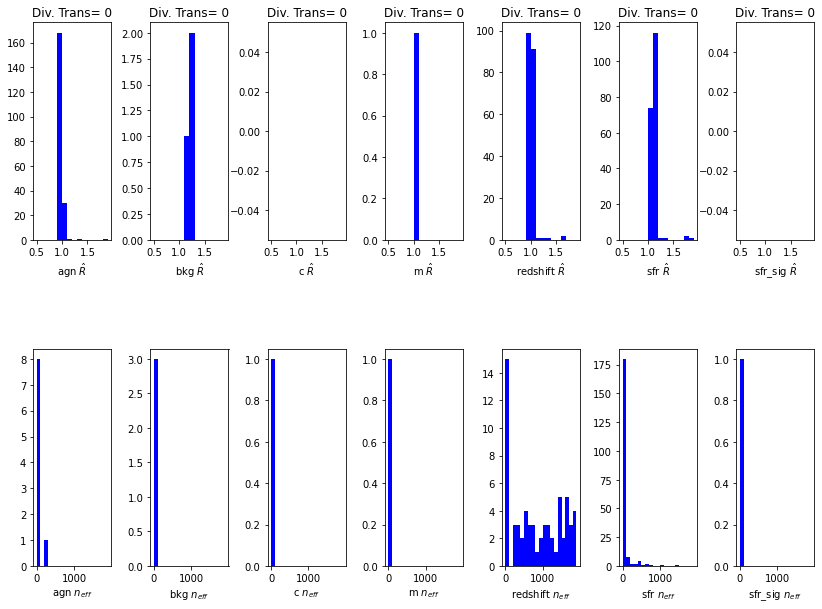

In [16]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['m'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

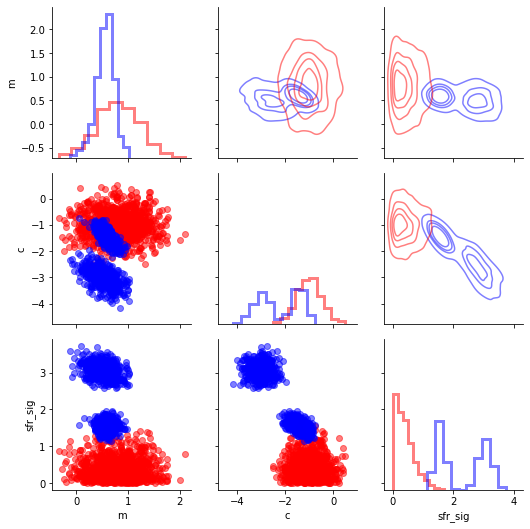

In [17]:
import pandas as pd
hier_param_names=['m','c','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#### Source parameters 

Text(0, 0.5, 'Redshift')

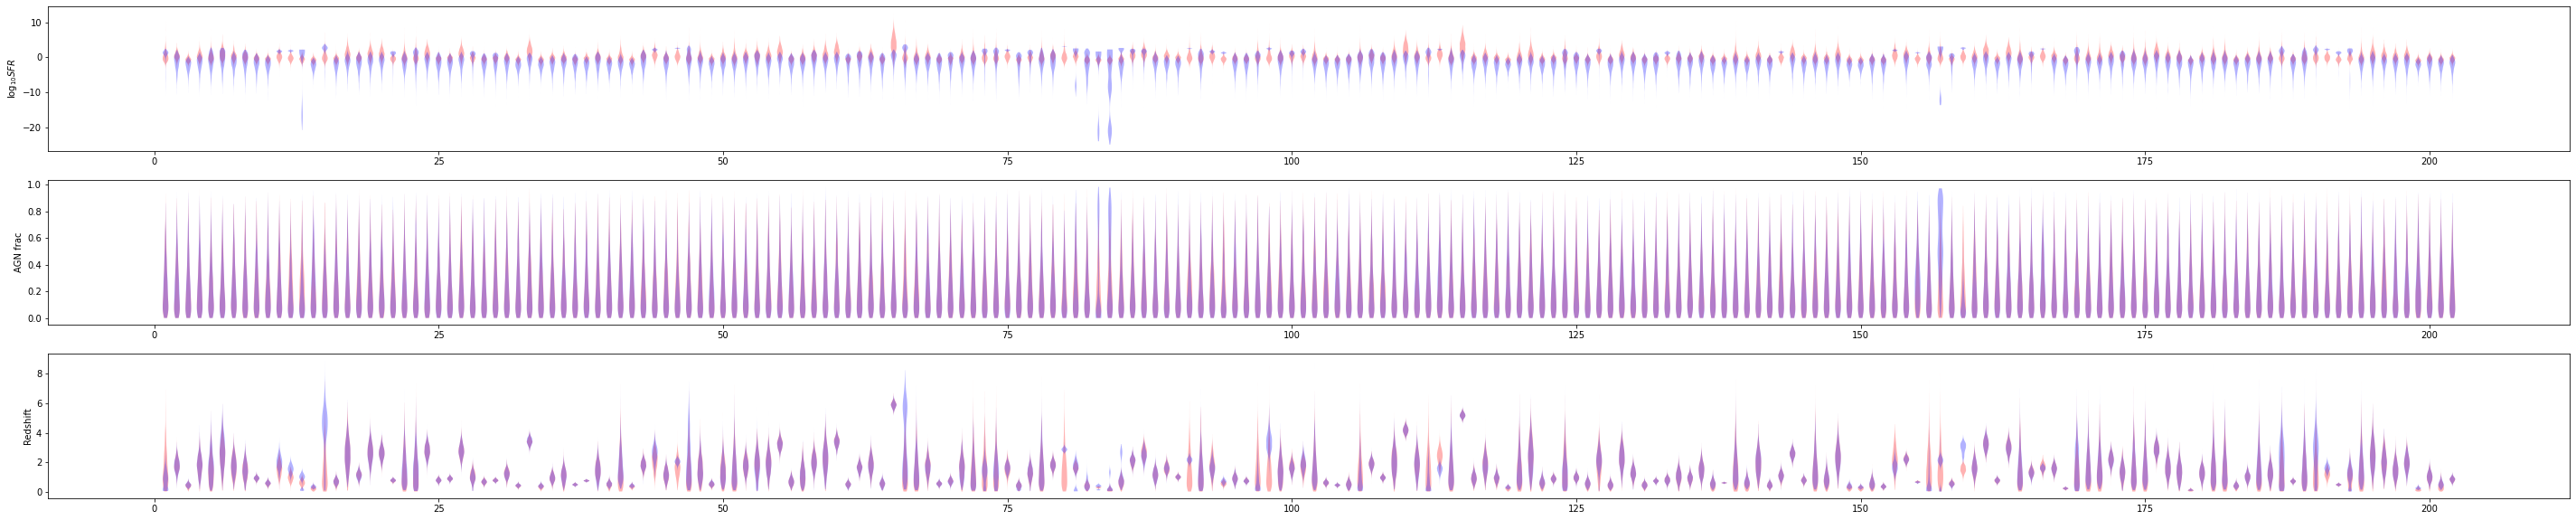

In [18]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

### Posterior Predicitive Checks

In [19]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 2.14 s, sys: 11.1 ms, total: 2.15 s
Wall time: 2.12 s


In [20]:
#feed the model map arrays the animation function
#xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

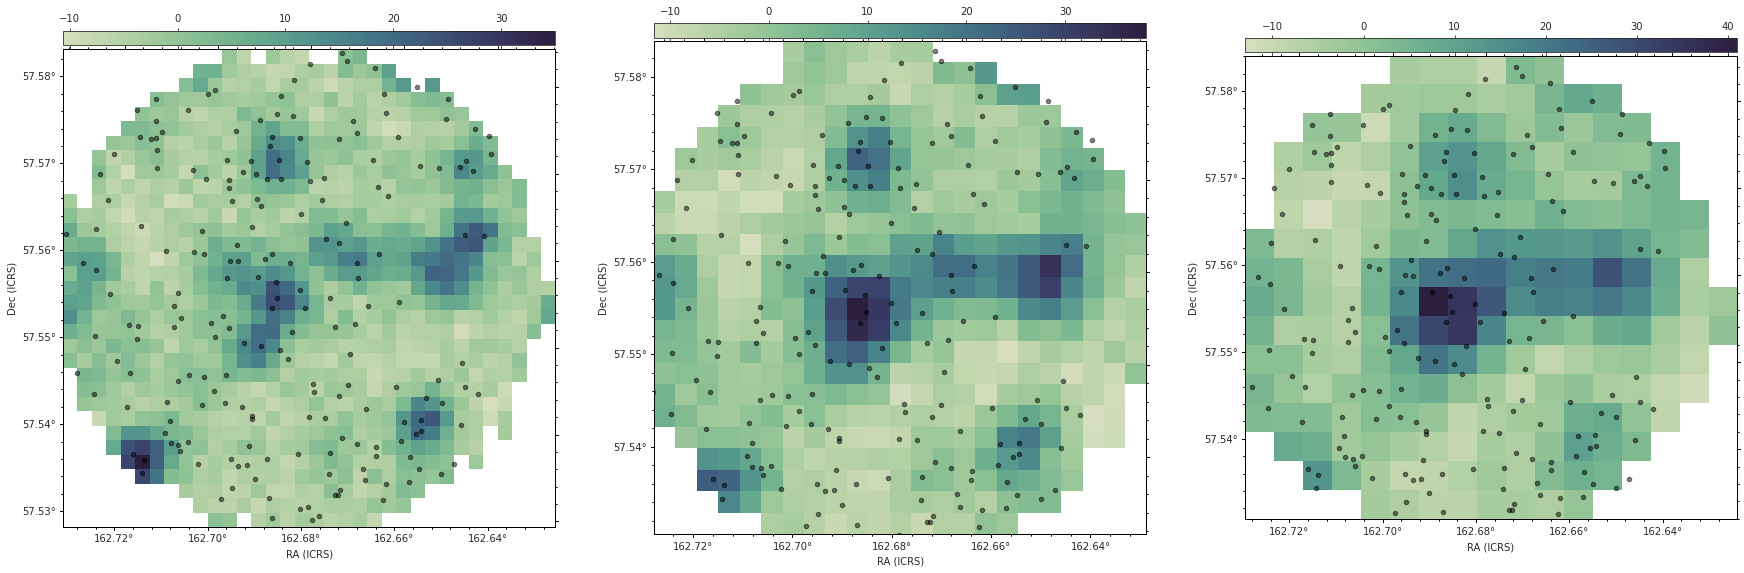

In [21]:
figures,fig=xidplus.plot_map(priors)

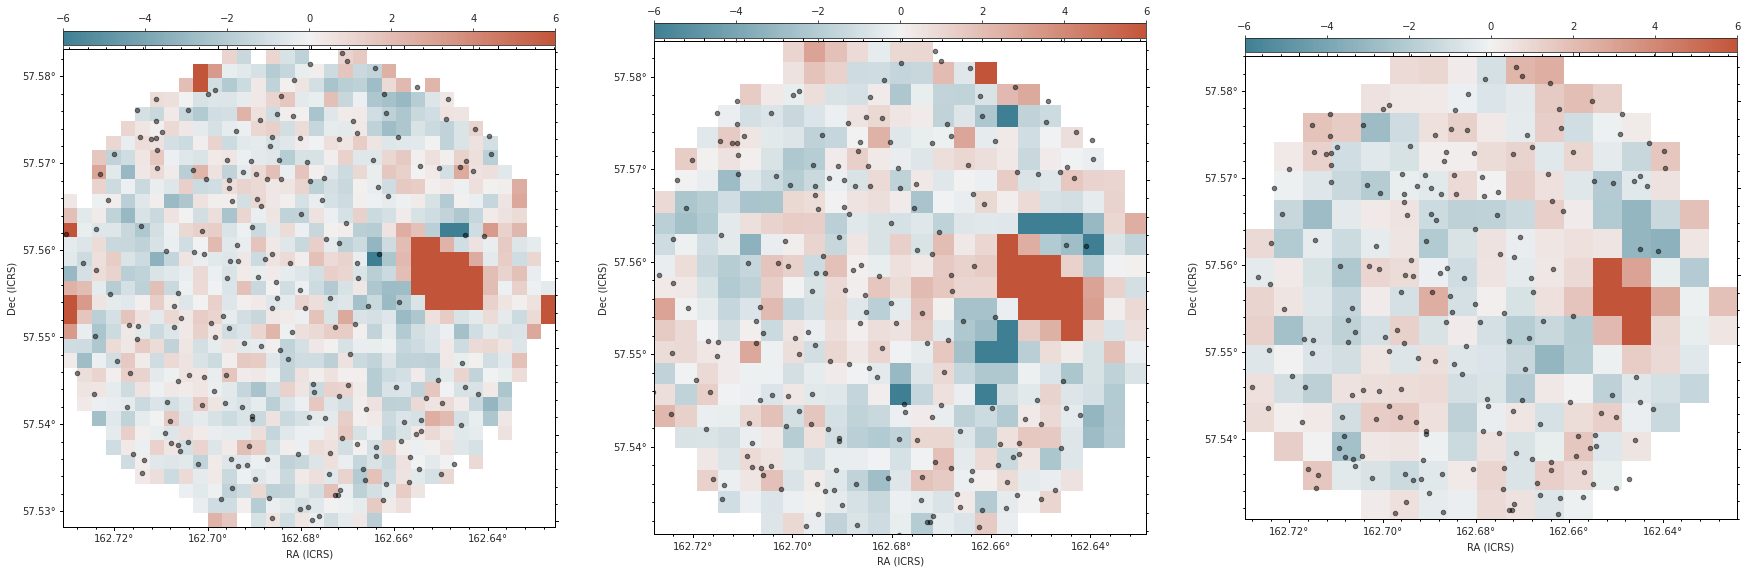

In [22]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(10 * len(priors), 10))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))
    
    
for i in range(0, len(priors)):
    figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=20, alpha=0.5)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')

As a demonstration of how the flux is being distributed to the two sources, we can plot the posterior probability distribution function of fluxes in the marginalised 2-D colour spaces.

`HELP_J104631.082+591021.253` is shown by the red contours and `HELP_J104631.170+591036.829` in blue. To illustrate how different these fluxes are from those coming from the blind catalogues, we show an additional contour, coming from running a blind source extraction routine on our replicated maps. This provides a probability distribution function for the flux that would be measured from our model of the data. We also plot the blind source extraction carried out on the real map, shown by the black dot.

The black dot lies on top of our blind source extractions from our generated map, indicating that our model of the data is similar to the real map in regard to blind source extraction.

More importantly, the flux probability contours for `HELP_J104631.170+591036.829` are in a completely different area of colour space with regard to those coming from the blind source extraction, where as there is some overlap with `HELP_J104631.082+591021.253`. We also plot the total flux of the two sources combined are shown in orange which is much greater than that coming from blind source extraction. This plot clearly illustrates how blind source extraction routines can give miss-leading results. Not only is the flux of `HELP_J104631.170+591036.829` significantly less than that coming from blind source extraction, but that these blind source extraction can significantly underestimate the total flux coming from slightly confused SPIRE sources.

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [23]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [24]:
#Run the DAOstarfinder on the original maps for all SPIRE bands
from photutils import DAOStarFinder
fwhm=[17.6,23.9,35.2]
new_scat_flux=[]
new_scat_pos=[]
for b in range(0,len(priors)):
    tmp_fits=postmaps.make_fits_image(priors[b],priors[b].sim)
    wcs_temp = wcs.WCS(tmp_fits[1].header)
    daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5.0,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5)    
    new_scat = daofind(tmp_fits[1].data)
    new_scat_coords=wcs_temp.pixel_to_world(new_scat['xcentroid'],new_scat['ycentroid'])
    idx_new, d2d_new, d3d_new = c.match_to_catalog_sky(new_scat_coords)
    new_scat_flux.append(new_scat['peak'][idx_new])
    new_scat_pos.append(new_scat_coords[idx_new])


In [25]:
posterior_blind_source_coords=[]
posterior_blind_source_flux=[]
# Run starfinder on all posterior maps
for s in range(0,mod_map_array_samp[0].shape[-1]):
    if s%1000==0:
        print(s)
    tmp_posterior_blind_source_coords=[]
    tmp_posterior_blind_source_flux=[]
    for b in range(0,len(priors)):
        tmp_fits=postmaps.make_fits_image(priors[b],mod_map_array_samp[b][...,s])
        #need to widen constriants on roundness and sharpness constraints
        daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5) 
        sources = daofind(tmp_fits[1].data)
        #print(sources)
        wcs_temp = wcs.WCS(tmp_fits[1].header)
        new_coords=wcs_temp.pixel_to_world(sources['xcentroid'],sources['ycentroid'])
   
            
        idx_tmp, d2d_tmp, d3d_tmp = c.match_to_catalog_sky(new_coords)
        tmp_posterior_blind_source_coords.append(new_coords[idx_tmp])
        tmp_posterior_blind_source_flux.append(sources[idx_tmp]['peak'])
    posterior_blind_source_coords.append(tmp_posterior_blind_source_coords)
    posterior_blind_source_flux.append(tmp_posterior_blind_source_flux)
        
    

0


1000


In [26]:
 # get original fluxes from scat
band=[250,350,500]
scat_flux=[]
scat_pos=[]
for b in band:
    scat=Table.read('../../../data/WP5-{}-SCAT{}-v1.0.fits.gz'.format(field[0],b))
    orig_scat_coords=SkyCoord(scat['RA'],scat['Dec'])
    idx, d2d, d3d = c.match_to_catalog_sky(orig_scat_coords)
    scat_flux.append(scat['F_SPIRE_{}'.format(b)][idx].data)
    scat_pos.append(orig_scat_coords[idx])
scat_flux=np.array(scat_flux)

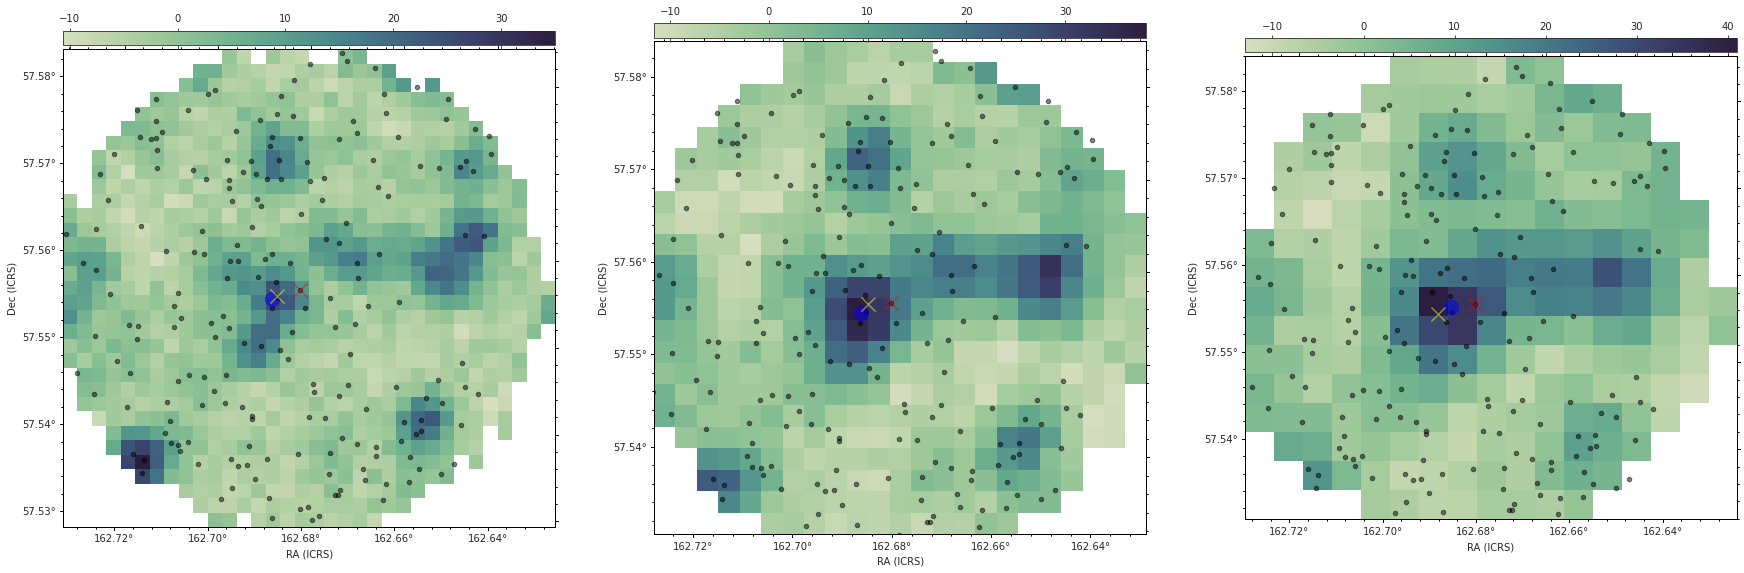

In [27]:
orig_map=xidplus.plot_map(priors)
for i in range(0,3):
    #plot new scat coords
    orig_map[0][i].show_markers(new_scat_pos[i].ra.value,new_scat_pos[i].dec.value,edgecolor='blue', facecolor='blue',
                marker='o', s=200, alpha=0.5)
    orig_map[0][i].show_markers(c.ra.value,c.dec.value, edgecolor='red', facecolor='red',
                marker='x', s=200, alpha=0.5)
    orig_map[0][i].show_markers(scat_pos[i].ra.value,scat_pos[i].dec.value,edgecolor='yellow', facecolor='yellow',
                marker='x', s=200, alpha=0.5)


In [28]:
#stack params and make vector ready to be used by emualator
params = jnp.stack((samples['sfr'].T, samples['agn'].T, samples['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((prior_pred['sfr'].T, prior_pred['agn'].T, prior_pred['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

In [29]:
src_f.shape

(2000, 202, 3)

In [30]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=new_scat_pos[0].separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J105045.711+573326.565
HELP_J105044.764+573324.832
HELP_J105044.670+573318.344
HELP_J105044.947+573313.983 
 are possible contributers to flux of extreme starburst


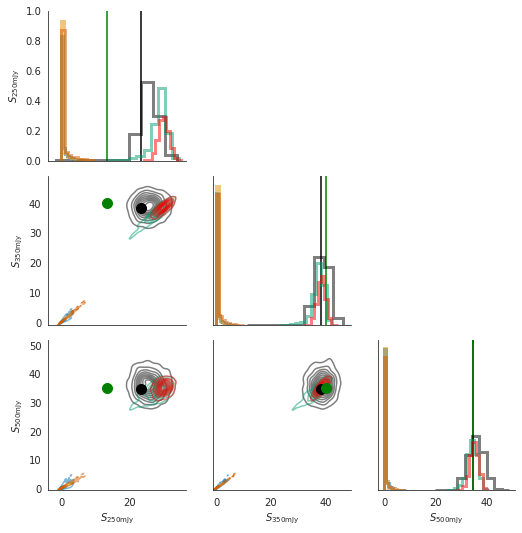

In [31]:
cmap=sns.color_palette('colorblind')
sns.set_style("white")
#set up Pairgrid plot and plot blind source flux
df_blind=pd.DataFrame(np.array(posterior_blind_source_flux)[:,:,0],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g=sns.PairGrid(df_blind)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='black')
#g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)

#plot the fluxes for the possible sources that could contribute
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    #g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

# plot the combination of flux from those sources
df_sum=pd.DataFrame(np.sum(src_f[:,contrib_sources,:],axis=1),columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df_sum
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')




g.data=df_blind
g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    #g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
g.data=df_sum
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
    
    
#turn off the axes not used
g.axes[0,1].set_axis_off()
g.axes[0,2].set_axis_off()
g.axes[1,2].set_axis_off()

#plot the fluxes from new scat and orig scat
for i in range(0,len(priors)):
    g.axes[i,i].axvline(x=new_scat_flux[i],color='black')
    g.axes[i,i].axvline(x=scat_flux[i],color='green')
    for j in range(0,len(priors)):
        if j>i:
            g.axes[j,i].plot(new_scat_flux[i],new_scat_flux[j],'ko',ms=10)
            g.axes[j,i].plot(scat_flux[i],scat_flux[j],'go',ms=10)
#g.axes[2,0].plot(0.39,32.63,'ko',ms=10)
#g.axes[3,0].plot(0.39,27.0,'ko',ms=10)


### Parameters of contributing sources
The physical parameters of our sources which could be contributing to the extreme starburst

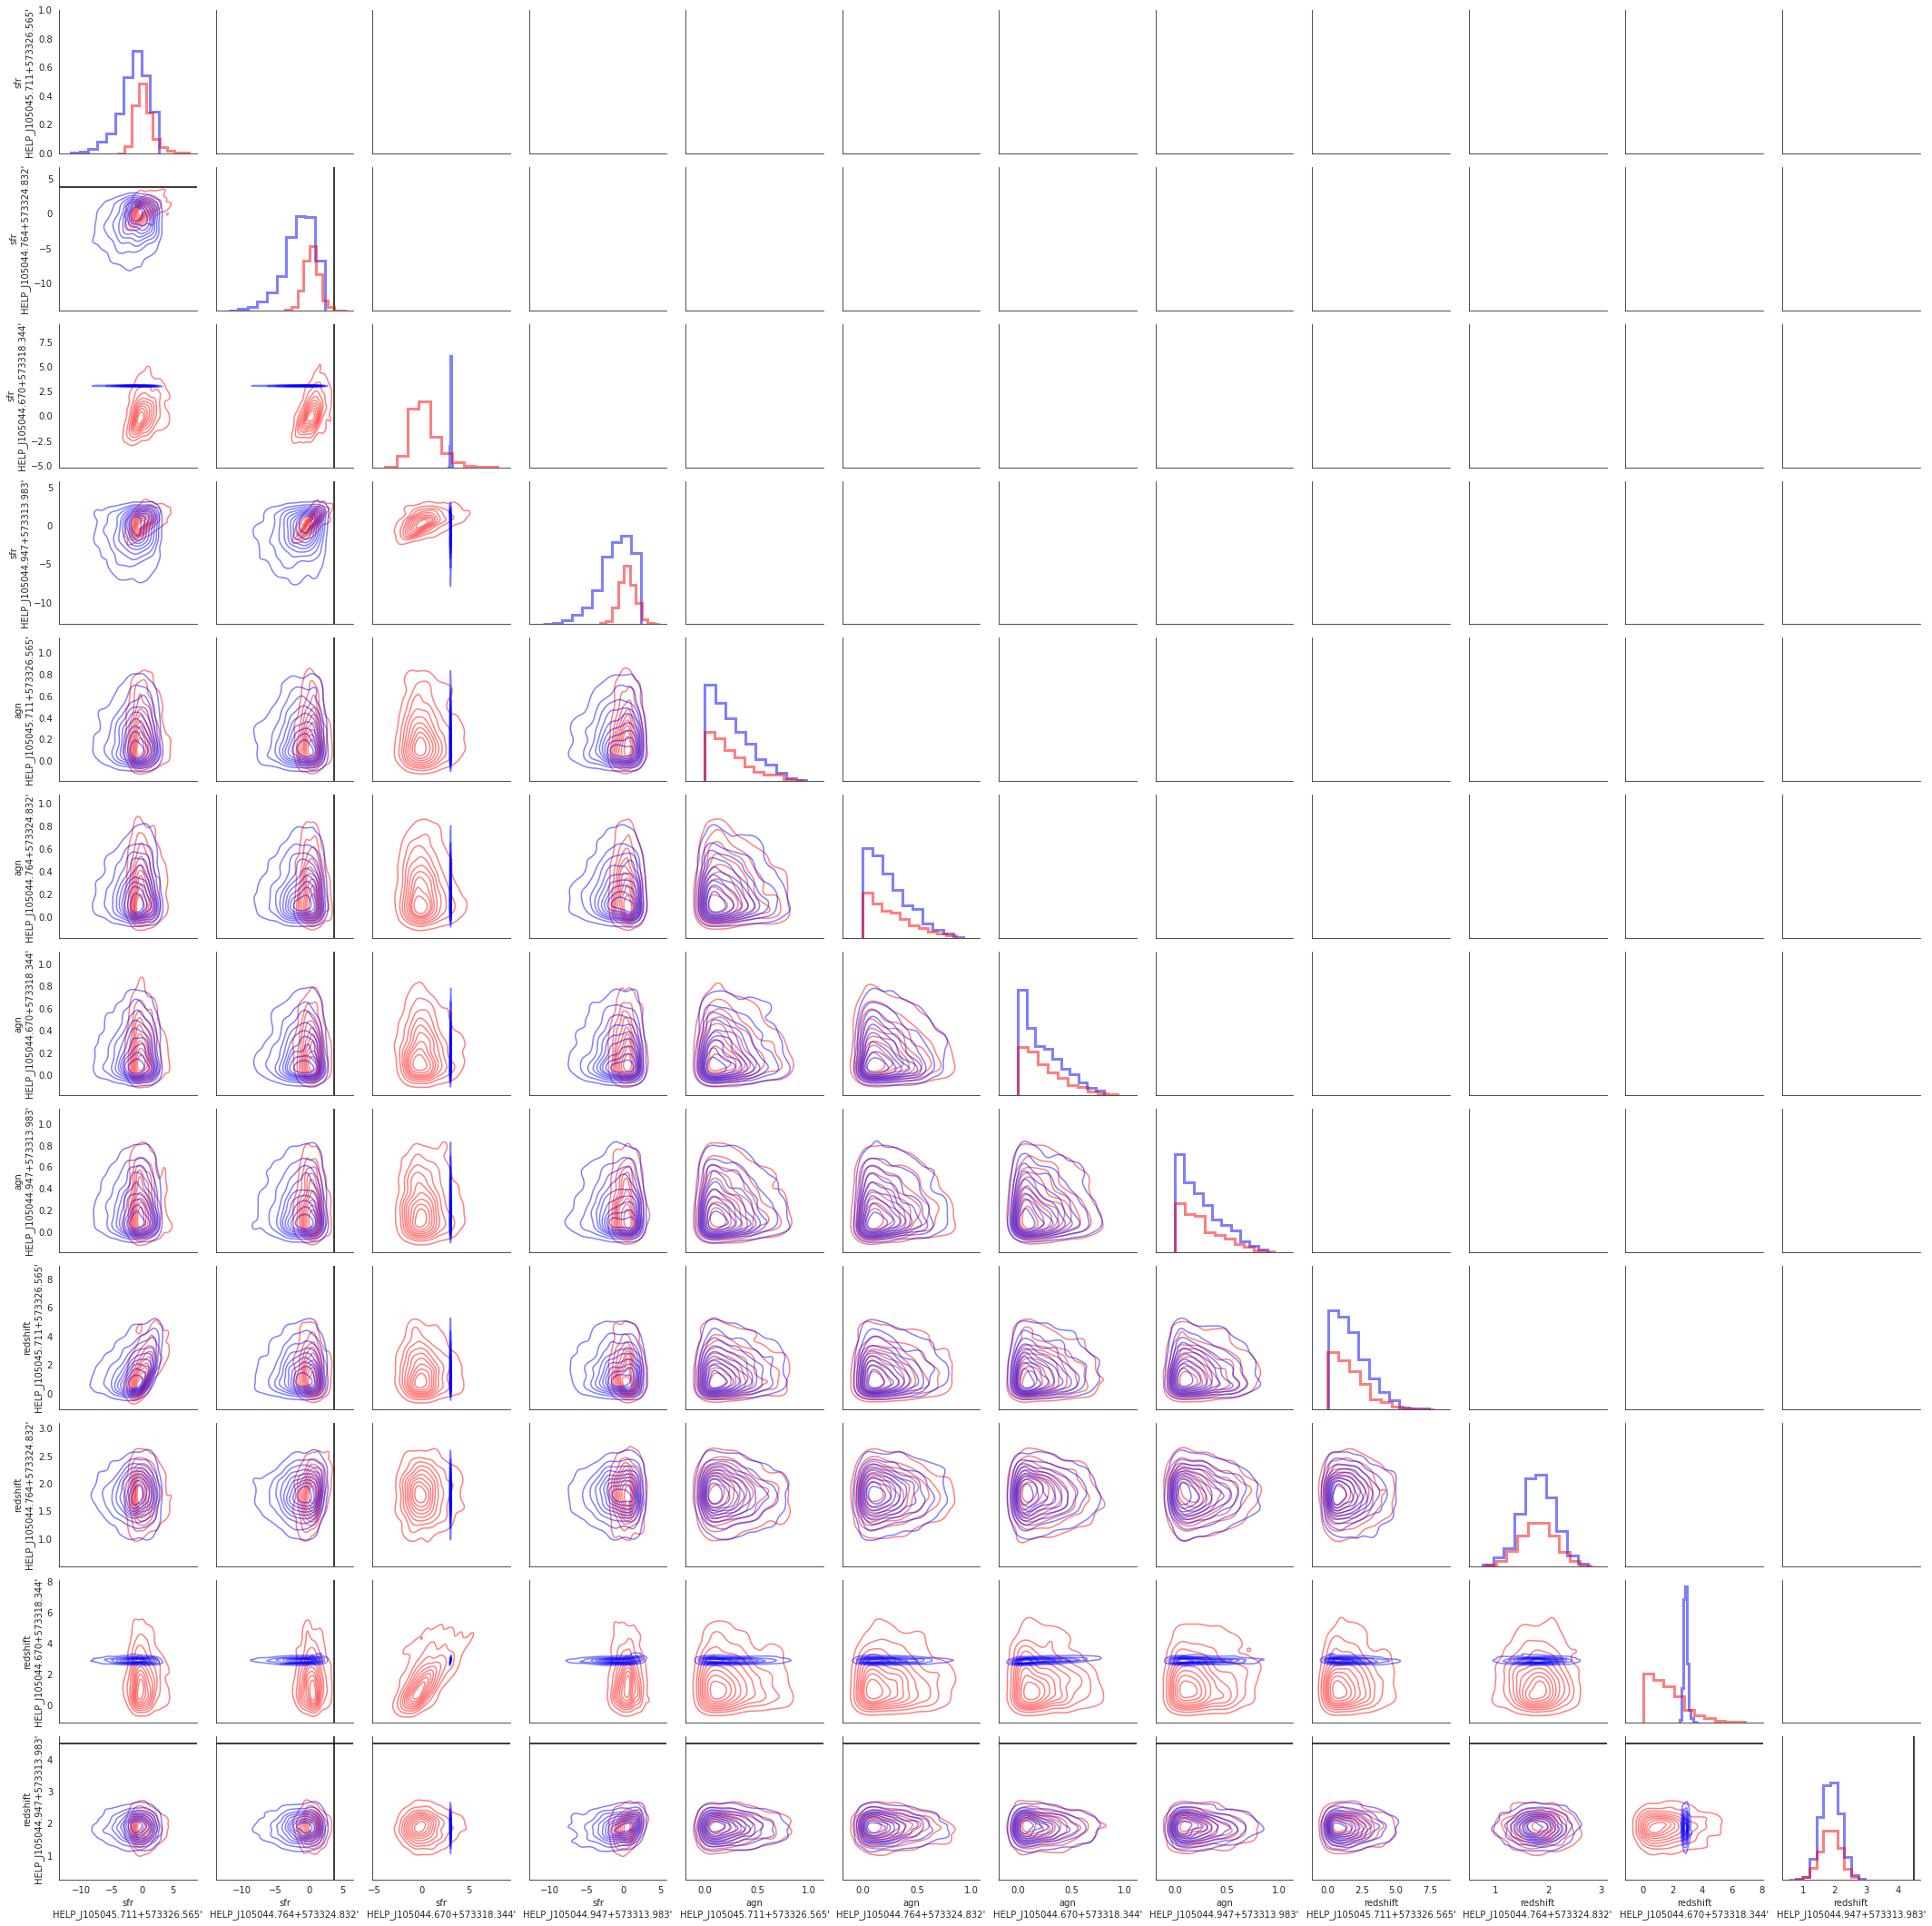

In [32]:
phys_params=['sfr','agn','redshift']
contrib_params=pd.DataFrame(np.array([samples[p][:,contrib_sources].T for p in phys_params]).reshape((len(phys_params)*contrib_sources.sum(),-1)).T,
                            columns=np.concatenate([[s+'\n'+str(priors[0].ID[contrib_sources][i]).split("b'")[1] for i in range(0,contrib_sources.sum())] for s in phys_params])
)
contrib_params_prior=pd.DataFrame(np.array([prior_pred[p][:,contrib_sources].T for p in phys_params]).reshape((len(phys_params)*contrib_sources.sum(),-1)).T,
                            columns=np.concatenate([[s+'\n'+str(priors[0].ID[contrib_sources][i]).split("b'")[1] for i in range(0,contrib_sources.sum())] for s in phys_params])
)
g=sns.PairGrid(contrib_params)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Blue')
g.data=contrib_params_prior
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

g.data=contrib_params
g.map_lower(sns.kdeplot, color='Blue',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

[a.axhline(y=esb[source[0]]['Z\xa0comb'],color='black') for a in g.axes[-1,:-1]]
g.axes[1,0].axhline(y=esb[source[0]]['SFR log(M\xa0sol. yr−1)'],color='black') 

g.axes[-1,-1].axvline(x=esb[source[0]]['Z\xa0comb'],color='black')
[a.axvline(x=esb[source[0]]['SFR log(M\xa0sol. yr−1)'],color='black') for a in g.axes[1:,1]]

